## 해야할 일

1. 시뮬레이션에서 a1,과 b1의 값이 어떻게 나오는지 확인하고 분석하기.
2. 분포를 그려서 시뮬레이션 확인해보기

In [190]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
from parfor import parfor
from tqdm.notebook import tqdm

In [191]:
@jit(nopython=True)
def RK4(f, y0, t, args=()):
    n = len(t)
    y = np.zeros((n,len(y0)))
    y[0] = y0

    for i in range(n - 1):
        h = t[i + 1] - t[i]
        k1 = f(y[i], t[i], *args)
        k2 = f(y[i] + k1 * h / 2.0, t[i] + h / 2.0, *args)
        k3 = f(y[i] + k2 * h / 2.0, t[i] + h / 2.0, *args)
        k4 = f(y[i] + k3 * h, t[i] + h, *args)
        y[i + 1] = y[i] + (h / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
    return y

@jit(nopython=True)
def dZ_dt(Zs,t,alpha,beta,eta1,eta2):
    a1real,a1imag,b1real,b1imag,a2real,a2imag,b2real,b2imag = Zs
    a1 = a1real + 1j*a1imag
    a2 = a2real + 1j*a2imag
    b1 = b1real + 1j*b1imag
    b2 = b2real + 1j*b2imag
    Z11 = 1/2 * (np.conj(a1)+np.conj(b1)) + eta1/2 * (np.conj(a1)-np.conj(b1))
    Z12 = 1/2 * (np.conj(a2)+np.conj(b2)) + eta2/2 * (np.conj(a2)-np.conj(b2))
    H1 = Z11**2 + 2*beta*Z11*Z12 + beta**2*Z12**2
    H2 = Z12**2 + 2*beta*Z11*Z12 + beta**2*Z11**2
    
    da1 = 1/2 *(np.conj(H1)*np.conj(a1)*np.exp(1j*alpha) - H1*a1**3*np.exp(-1j*alpha) )
    db1 = 1/2 *(np.conj(H1)*np.conj(b1)*np.exp(1j*alpha) - H1*b1**3*np.exp(-1j*alpha) )
    da2 = 1/2 *(np.conj(H2)*np.conj(a2)*np.exp(1j*alpha) - H2*a2**3*np.exp(-1j*alpha) )
    db2 = 1/2 *(np.conj(H2)*np.conj(b2)*np.exp(1j*alpha) - H2*b2**3*np.exp(-1j*alpha) )
    return np.array([da1.real,da1.imag,db1.real,db1.imag,da2.real,da2.imag,db2.real,db2.imag])


def to_complex(Zs):
    a1real,a1imag,b1real,b1imag,a2real,a2imag,b2real,b2imag = Zs.T
    a1 = a1real + 1j*a1imag
    a2 = a2real + 1j*a2imag
    b1 = b1real + 1j*b1imag
    b2 = b2real + 1j*b2imag
    return a1,b1,a2,b2

In [192]:
t = np.arange(0,50_000,0.1)
eta1 = 0.1
eta2 = 0.05

A1 = 1
A2 = np.sqrt(0.3)
shift = 0.0 * np.pi

a1 =  A1 *np.exp(0j)
b1 =  a1 * np.exp(np.pi*1j)
a2 =  A2*np.exp(shift*1.0j)
b2 =  a2* np.exp(np.pi*1j)
betas = np.linspace(0,1,51)[1:]
alphas = np.linspace(0,np.pi/2,50,endpoint=False)

In [195]:
alpha = alphas[-5]
@parfor(betas,args=(alpha,eta1,eta2),bar=False)
def get_QR_long(beta,alpha,eta1,eta2):
    Zs = RK4(dZ_dt,np.array([a1.real,a1.imag,b1.real,b1.imag,a2.real,a2.imag,b2.real,b2.imag]),t,args=(alpha,beta,eta1,eta2))
    a1s,b1s,a2s,b2s = to_complex(Zs[-10000::50])
    RZ1s = 1/2 * (np.conj(a1s)+np.conj(b1s)) + eta1/2 * (np.conj(a1s)-np.conj(b1s))
    QZ1s = 1/2 * (np.conj(a1s)**2+np.conj(b1s)**2) + eta1/2 * (np.conj(a1s)**2-np.conj(b1s)**2)

    RZ2s = 1/2 * (np.conj(a2s)+np.conj(b2s)) + eta2/2 * (np.conj(a2s)-np.conj(b2s))
    QZ2s = 1/2 * (np.conj(a2s)**2+np.conj(b2s)**2) + eta2/2 * (np.conj(a2s)**2-np.conj(b2s)**2)
    return RZ1s,QZ1s,RZ2s,QZ2s,a1s,b1s,a2s,b2s

RZ1,QZ1,RZ2,QZ2,a1s,b1s,a2s,b2s = map(np.array,zip(*get_QR_long))

In [196]:
R1s = np.abs(RZ1)
R2s = np.abs(RZ2)
Q1s = np.abs(QZ1)
Q2s = np.abs(QZ2)

In [197]:
a1s,b1s,a2s,b2s = map(np.array,[a1s,b1s,a2s,b2s])

In [198]:
def dist_ab(x,a,b,eta):
    a_ = a*np.exp(1j*x)/(1-a*np.exp(1j*x))
    b_ = b*np.exp(1j*x)/(1-b*np.exp(1j*x))
    f = 1/(2*np.pi) * (1+ (1/2+eta/2)*(a_+a_.conjugate())+(1/2-eta/2)*(b_+b_.conjugate()))# + np.conj(c_))
    return f


In [199]:
x =  np.linspace(0,2*np.pi,1000) + 1e-10

In [200]:
plt.plot(x,dist_ab(x,a1s[21][i*50],b1s[21][i*50],eta2),color='red')


NameError: name 'i' is not defined

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


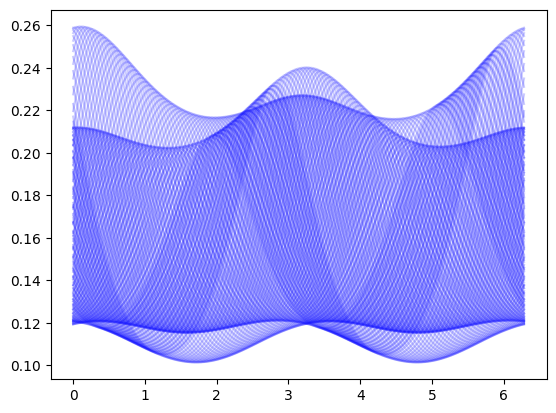

In [201]:
# plt.plot(x,dist_ab(x,a1s[22][-1],b1s[22][-1],eta1))
index = 28
for i in range(150):
    # plt.plot(x,dist_ab(x,a1s[21][i*50],b1s[21][i*50],eta2),color='red')

    plt.plot(x,dist_ab(x-np.angle(a1s[index][i]),a2s[index][i],b2s[index][i],eta2),color='blue',alpha=0.2)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


 ...]

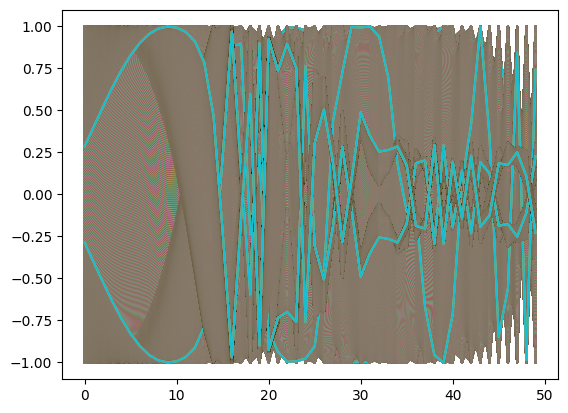

In [59]:
plt.plot(a1s[:,])
plt.plot(b1s[:,])
plt.plot(a2s[:,])
plt.plot(b2s[:,])

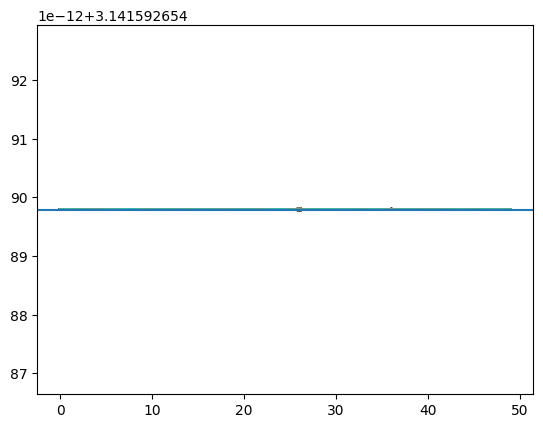

In [60]:
plt.plot(np.abs(np.angle(a1s[:,])-np.angle(b1s[:,])))
plt.axhline(np.pi)

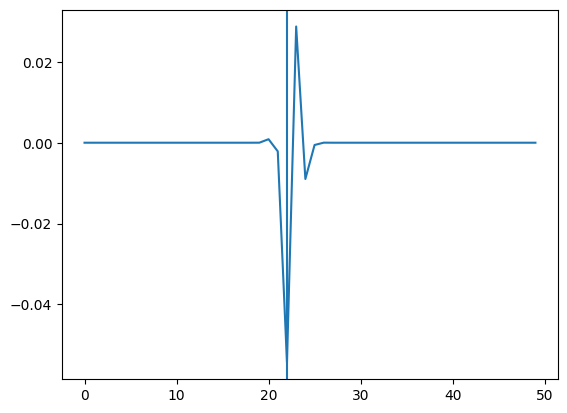

In [201]:
plt.plot(np.abs(np.angle(a2s[:,-1])-np.angle(b2s[:,-1]))- np.pi)
# plt.axhline(np.pi)
plt.axvline(22)

In [149]:
Q2s.shape

(50, 5000)

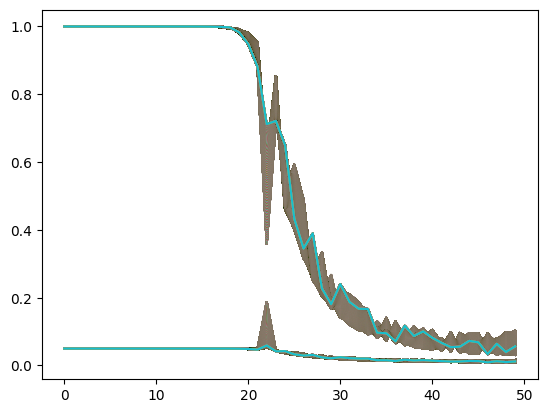

In [153]:
plt.plot(Q2s[:,-5000:]);
plt.plot(R2s[:,-5000:]);

order parameter  R 에서 $\eta_2$의 값이 안나타는 이유는 peak를 나타내는 a2s,a1s의 값들이 1값을 가지지 않기 때문 

In [204]:
t = np.arange(0,10_000,0.1)
eta1 = 0.1
eta2 = 0.05

A1 = 1
A2 = np.sqrt(0.3)
shift = 0.0 * np.pi

a1 =  A1 *np.exp(0j)
b1 =  a1 * np.exp(np.pi*1j)
a2 =  A2*np.exp(shift*1.0j)
b2 =  a2* np.exp(np.pi*1j)
betas = np.linspace(0,1,51)[1:]
alphas = np.linspace(0,np.pi/2,50,endpoint=False)

In [205]:

shift = 0.*np.pi
a1 =  A1 *np.exp(0j)
b1 =  a1 * np.exp(np.pi*1j)
a2 =  A2*np.exp(shift*1j)
b2 =  a2* np.exp(np.pi*1j)


Q1s,Q2s,R1s,R2s = [],[],[],[]
P1_D,P2_D,A1_D,A2_D = [],[],[],[]
for alpha in tqdm(alphas):
    @parfor(betas,args=(alpha,eta1,eta2),bar=False)
    def get_QR(beta,alpha,eta1,eta2):
        Zs = RK4(dZ_dt,np.array([a1.real,a1.imag,b1.real,b1.imag,a2.real,a2.imag,b2.real,b2.imag]),t,args=(alpha,beta,eta1,eta2))
        a1s,b1s,a2s,b2s = to_complex(Zs[-1])
        P1_diff = np.abs(a1s) -  np.abs(b1s)
        P2_diff = np.abs(a2s) -  np.abs(b2s)
        A1_diff = np.abs(np.angle(a1s) -  np.angle(b1s)) - np.pi
        A2_diff = np.abs(np.angle(a2s) -  np.angle(b2s)) - np.pi

        RZ1s = 1/2 * (np.conj(a1s)+np.conj(b1s)) + eta1/2 * (np.conj(a1s)-np.conj(b1s))
        QZ1s = 1/2 * (np.conj(a1s)**2+np.conj(b1s)**2) + eta1/2 * (np.conj(a1s)**2-np.conj(b1s)**2)

        RZ2s = 1/2 * (np.conj(a2s)+np.conj(b2s)) + eta2/2 * (np.conj(a2s)-np.conj(b2s))
        QZ2s = 1/2 * (np.conj(a2s)**2+np.conj(b2s)**2) + eta2/2 * (np.conj(a2s)**2-np.conj(b2s)**2)
        Q1 = np.abs(QZ1s)
        Q2 = np.abs(QZ2s)
        R1 = np.abs(RZ1s)
        R2 = np.abs(RZ2s)
        return Q1,Q2,R1,R2,P1_diff,P2_diff,A1_diff,A2_diff
    Q1,Q2,R1,R2,P1_diff,P2_diff,A1_diff,A2_diff = zip(*get_QR)
    Q1s.append(Q1)
    Q2s.append(Q2)
    R1s.append(R1)
    R2s.append(R2)
    P1_D.append(P1_diff)
    P2_D.append(P2_diff)
    A1_D.append(A1_diff)
    A2_D.append(A2_diff)
Q1s = np.array(Q1s).T
Q2s = np.array(Q2s).T
R1s = np.array(R1s).T
R2s = np.array(R2s).T

P1_D = np.array(P1_D).T
P2_D = np.array(P2_D).T
A1_D = np.array(A1_D).T
A2_D = np.array(A2_D).T

  0%|          | 0/50 [00:00<?, ?it/s]

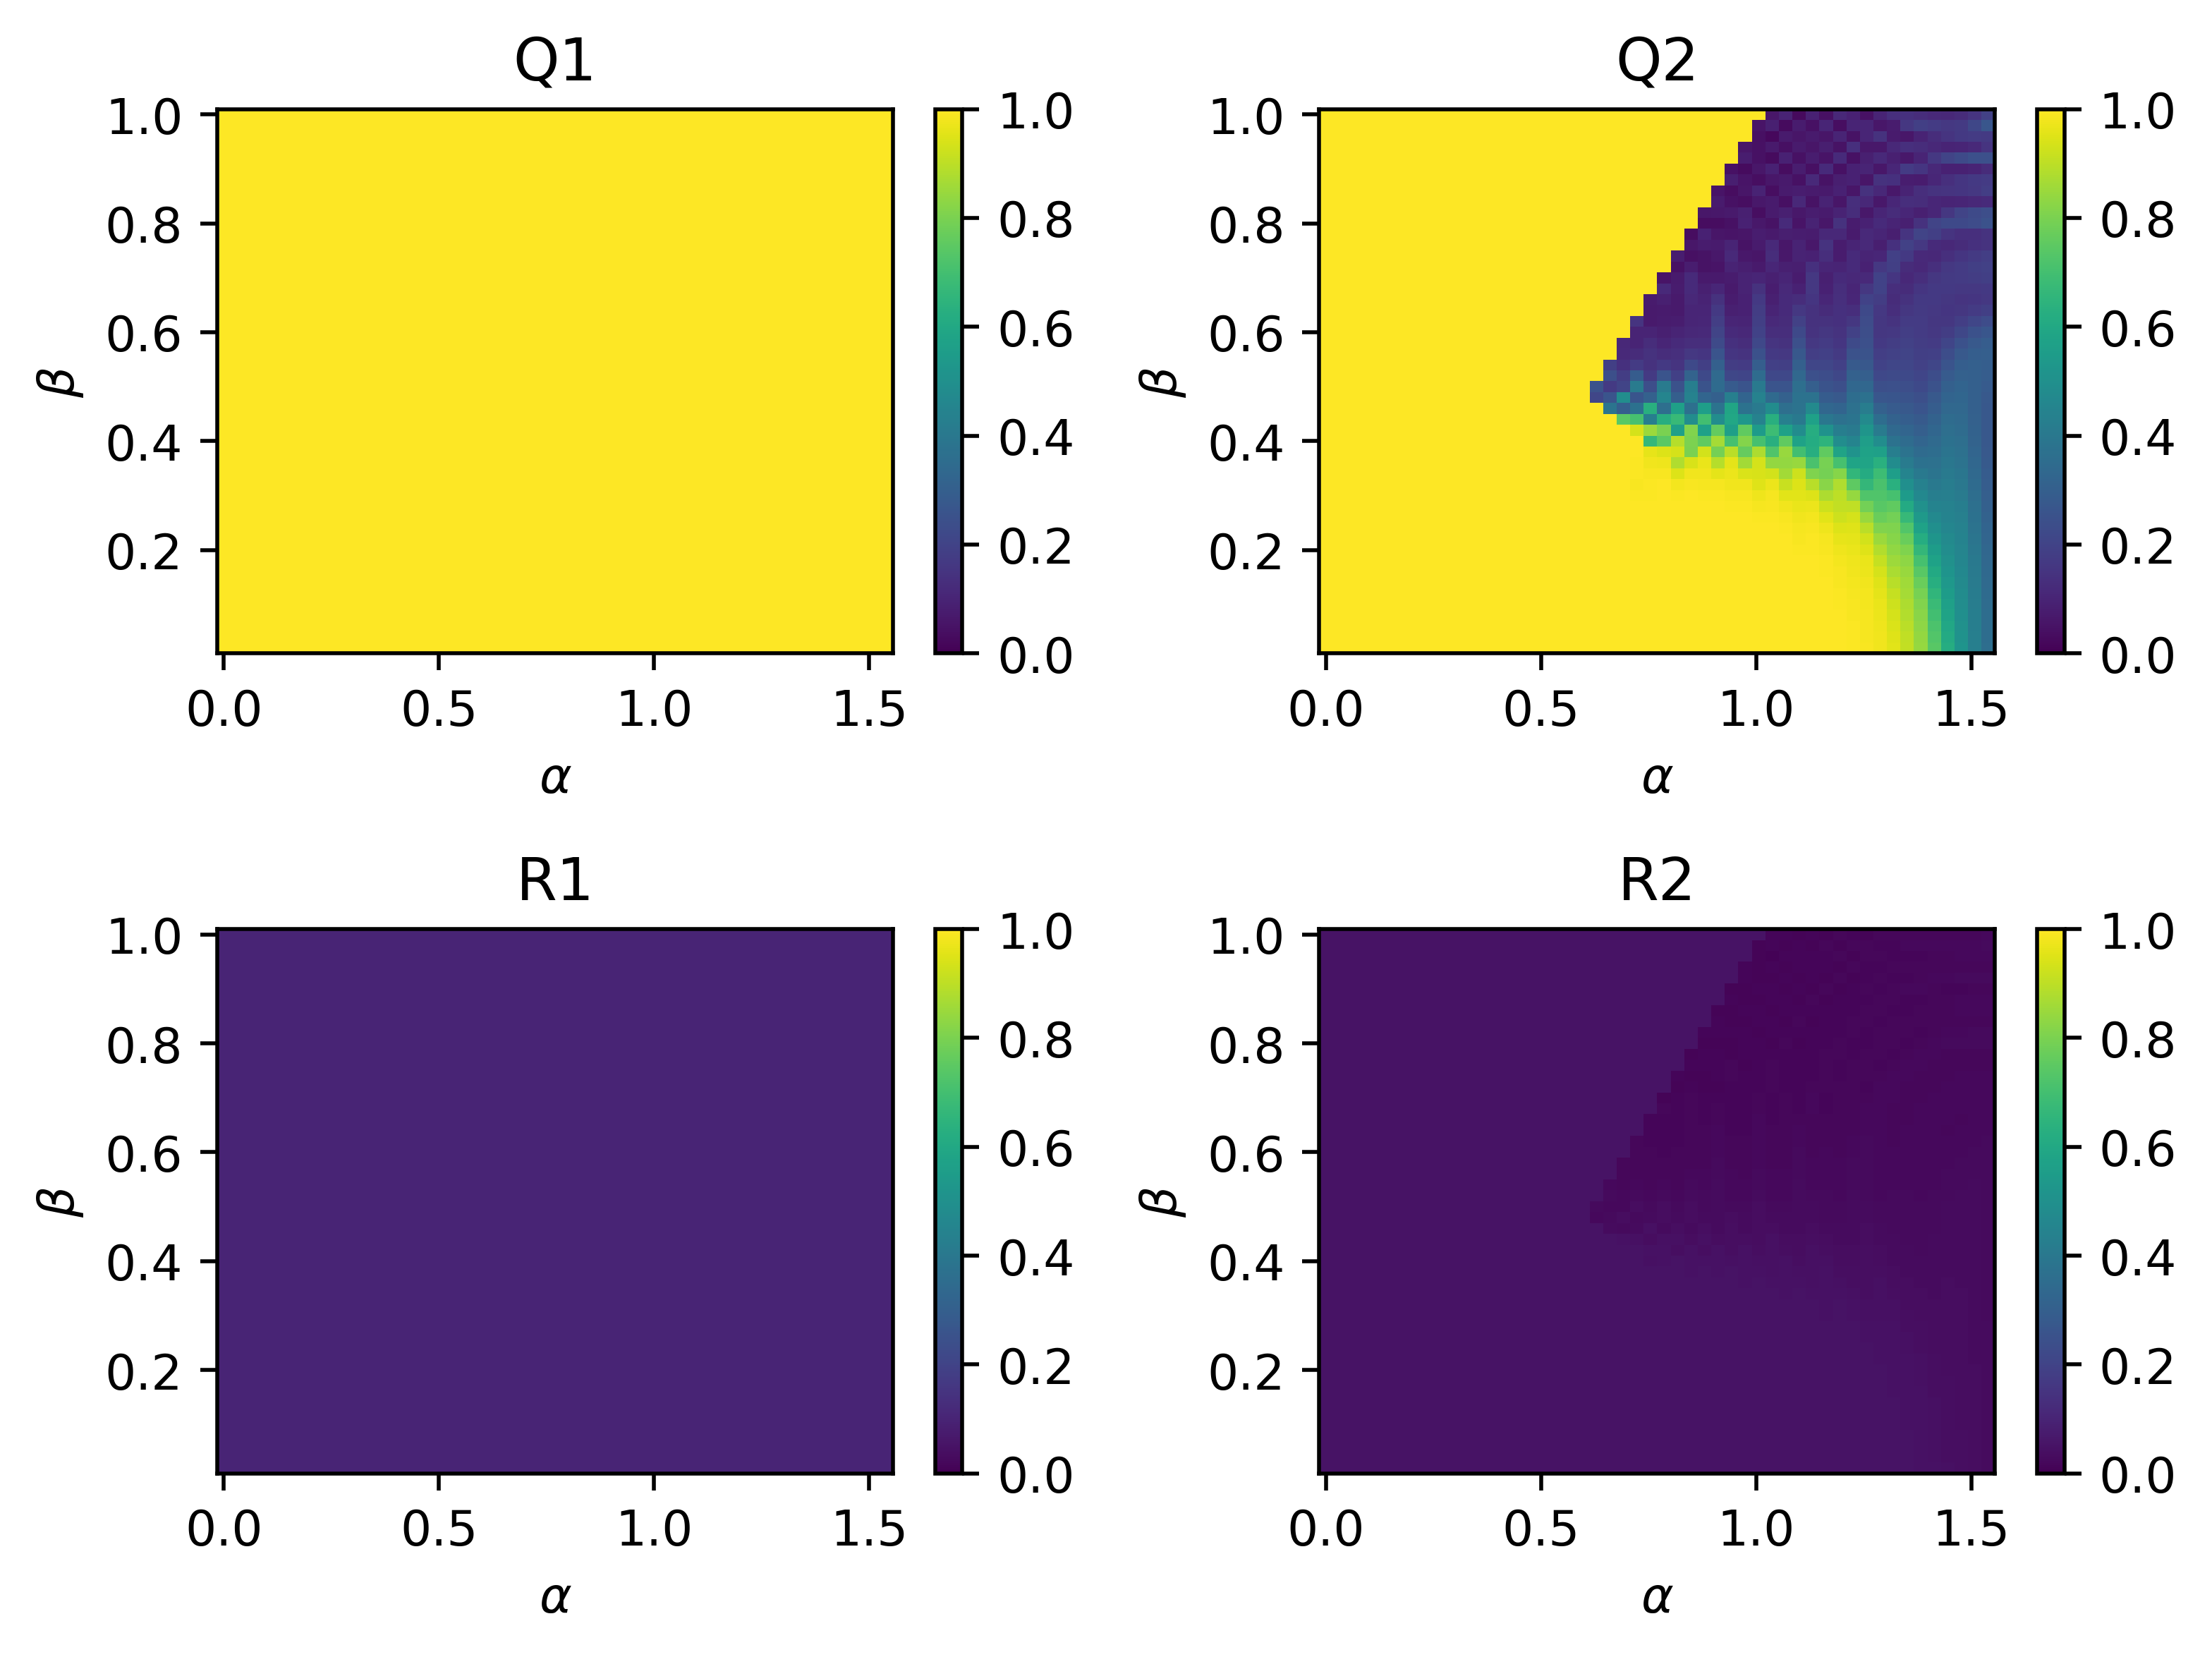

In [206]:
axs = []
fig,axs = plt.subplots(2,2,dpi=500)
((ax1,ax2),(ax3,ax4)) =  axs
# ((ax1,ax2),(ax1_1,ax2_1),(ax3,ax4)) =  axs
plt.sca(ax1)
plt.pcolormesh(alphas,betas,Q1s,vmin=0.0, vmax=1)
plt.colorbar(shrink=1)
plt.title('Q1')

plt.sca(ax2)
plt.pcolormesh(alphas,betas,Q2s,vmin=0.0, vmax=1.0)
plt.colorbar(shrink=1)
plt.title('Q2')


# plt.sca(ax1_1)
# plt.pcolormesh(alphas,betas,Q1_stds,vmin=0,vmax=0.1)
# plt.colorbar(shrink=1)
# plt.title(r'$\sigma_{Q1}$')

# plt.sca(ax2_1)
# plt.pcolormesh(alphas,betas,Q2_stds,vmin=0,)
# plt.colorbar(shrink=1)
# plt.title(r'$\sigma_{Q2}$')


plt.sca(ax3)
plt.pcolormesh(alphas,betas,R1s,vmin=0, vmax=1)
plt.colorbar(shrink=1)
plt.title('R1')

plt.sca(ax4)
plt.pcolormesh(alphas,betas,R2s,vmin=0, vmax=1)
plt.colorbar(shrink=1)
plt.title('R2')


for ax in axs.flatten():
    ax.set_ylabel(r'$\beta$')
    ax.set_xlabel(r'$\alpha$')


plt.tight_layout()


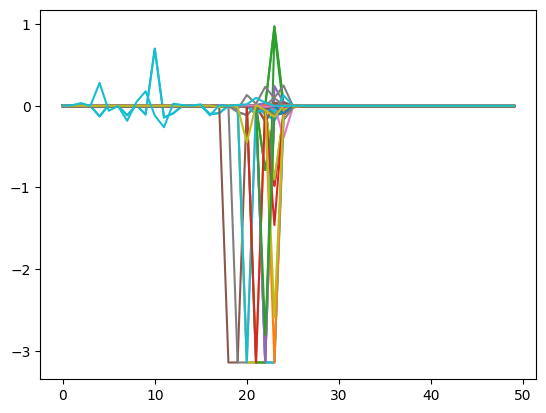

In [163]:
plt.plot(P2_D)
plt.plot(P2_D)
plt.plot(A2_D)


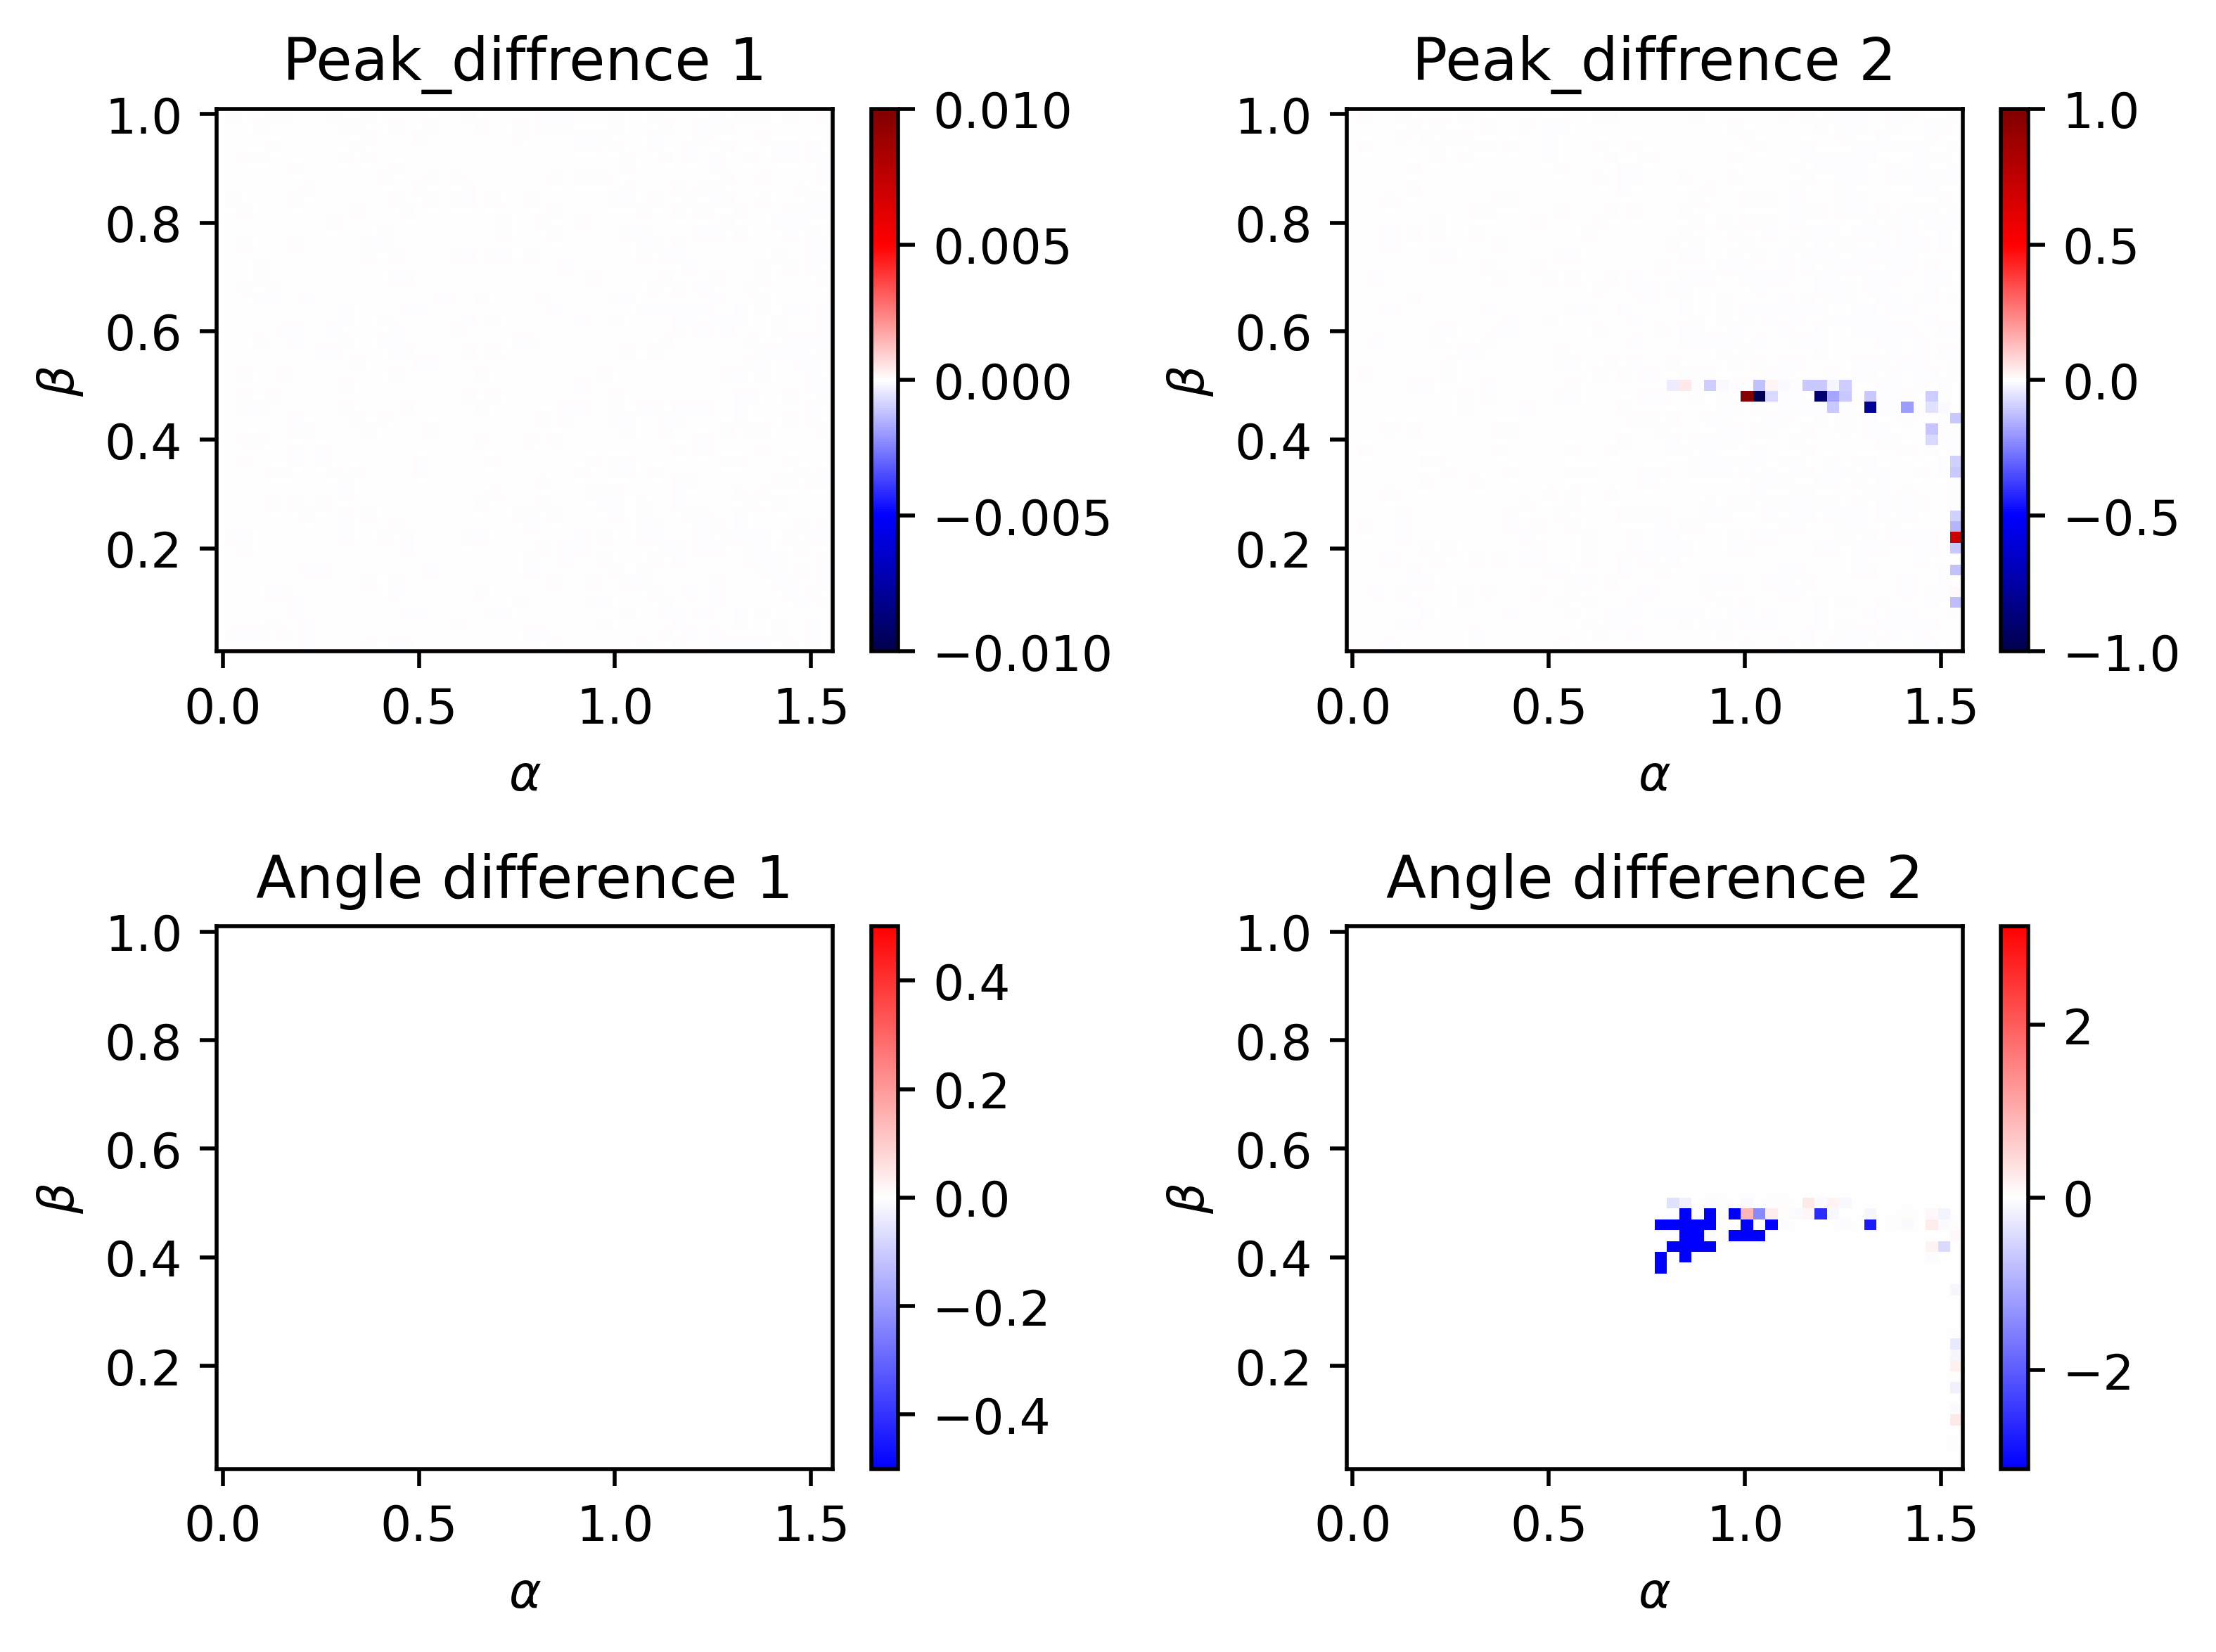

In [166]:
axs = []
fig,axs = plt.subplots(2,2,dpi=500)
((ax1,ax2),(ax3,ax4)) =  axs
# ((ax1,ax2),(ax1_1,ax2_1),(ax3,ax4)) =  axs
plt.sca(ax1)
plt.pcolormesh(alphas,betas,P1_D,vmin=-0.01, vmax=0.01,cmap= 'seismic')
plt.colorbar(shrink=1)
plt.title('Peak_diffrence 1')

plt.sca(ax2)
plt.pcolormesh(alphas,betas,P2_D,vmin=-1, vmax=1,cmap= 'seismic')
plt.colorbar(shrink=1)
plt.title('Peak_diffrence 2')



plt.sca(ax3)
plt.pcolormesh(alphas,betas,A1_D,vmin=-0.5, vmax=0.5,cmap= 'bwr')
plt.colorbar(shrink=1)
plt.title('Angle difference 1')

plt.sca(ax4)
plt.pcolormesh(alphas,betas,A2_D,vmin=-np.pi, vmax=np.pi,cmap= 'bwr')
plt.colorbar(shrink=1)
plt.title('Angle difference 2')


for ax in axs.flatten():
    ax.set_ylabel(r'$\beta$')
    ax.set_xlabel(r'$\alpha$')


plt.tight_layout()


# Solve equation

In [2]:
import sympy as sp

In [84]:
eta1,eta2,r,phi,alpha,beta = sp.symbols('eta1 eta2 r phi alpha beta',real=True)
beta_rp = eta2*r/(eta1*sp.cos(alpha+2*phi))*(-sp.cos(alpha+phi)+sp.sqrt(sp.cos(alpha+phi)**2-sp.cos(alpha)*sp.cos(alpha+2*phi)))
beta_rm = eta2*r/(eta1*sp.cos(alpha+2*phi))*(-sp.cos(alpha+phi)-sp.sqrt(sp.cos(alpha+phi)**2-sp.cos(alpha)*sp.cos(alpha+2*phi)))

dr = sp.Rational(1,2) * r* (1-r**2)*(eta2**2 * r**2 * sp.cos(alpha) + 2 * beta*eta1*eta2*r*sp.cos(alpha+phi) + beta **2 *eta1**2 * sp.cos(alpha + 2*phi))
dpsi2 = - sp.Rational(1,2) * (1+r**2)*(eta2**2 * r**2 * sp.sin(alpha) + 2 * beta*eta1*eta2*r*sp.sin(alpha+phi) + beta**2 * eta1**2 * sp.sin(alpha+2*phi))
dpsi1 = - sp.Rational(1,2) * (2)*(eta1**2 *sp.sin(alpha) + 2 * beta*eta1*eta2*r *sp.sin(alpha-phi) + beta**2 * eta2**2 * r**2 * sp.sin(alpha-2*phi))
dphi = dpsi2 - dpsi1
sol_rs =  sp.solve(dr,r)

In [64]:
dphi.trigsimp()

beta**2*eta2**2*r**2*sin(alpha - 2*phi) + 2*beta*eta1*eta2*r*sin(alpha - phi) + eta1**2*sin(alpha) + (-r**2/2 - 1/2)*(beta**2*eta1**2*sin(alpha + 2*phi) + 2*beta*eta1*eta2*r*sin(alpha + phi) + eta2**2*r**2*sin(alpha))

In [69]:
sol_rs[-1]

-beta*eta1*(cos(alpha + phi) + Abs(sin(phi)))/(eta2*cos(alpha))

In [68]:
beta_rp.simplify()

eta2*r*(-cos(alpha + phi) + Abs(sin(phi)))/(eta1*cos(alpha + 2*phi))

In [6]:
beta_rm.simplify()

-eta2*r*(cos(alpha + phi) + Abs(sin(phi)))/(eta1*cos(alpha + 2*phi))

In [7]:
beta_rp = eta2*r*(-sp.cos(alpha+phi) + sp.sin(phi))/ (eta1 * sp.cos(alpha+2*phi))
beta_rm = eta2*r*(-sp.cos(alpha+phi) - sp.sin(phi))/ (eta1 * sp.cos(alpha+2*phi))

In [8]:
dphi.subs(r,sol_rs[3]).simplify()

eta1**2*(-beta**4*eta2**2*(cos(alpha + phi) - Abs(sin(phi)))**2*sin(alpha - 2*phi)*cos(alpha)**2 + 2*beta**2*eta2**2*(cos(alpha + phi) - Abs(sin(phi)))*sin(alpha - phi)*cos(alpha)**3 + beta**2*(beta**2*eta1**2*(cos(alpha + phi) - Abs(sin(phi)))**2 + eta2**2*cos(alpha)**2)*(2*sin(alpha) + 4*sin(phi)*Abs(sin(phi)) - sin(alpha - 2*phi) - sin(alpha + 2*phi))/4 - eta2**2*sin(alpha)*cos(alpha)**4)/(eta2**2*cos(alpha)**4)

In [9]:
beta_rp.simplify()

eta2*r*(sin(phi) - cos(alpha + phi))/(eta1*cos(alpha + 2*phi))

In [10]:
n,_ = sp.fraction(dphi_sim)

NameError: name 'dphi_sim' is not defined

In [ ]:
n

-eta1**4*sin(alpha)*cos(alpha + 2*phi)**2 + eta1**2*eta2**2*r**2*(r**2 + 1)*((sin(phi) - cos(alpha + phi))**2*sin(alpha + 2*phi) + 2*(sin(phi) - cos(alpha + phi))*sin(alpha + phi)*cos(alpha + 2*phi) + sin(alpha)*cos(alpha + 2*phi)**2)/2 - 2*eta1**2*eta2**2*r**2*(sin(phi) - cos(alpha + phi))*sin(alpha - phi)*cos(alpha + 2*phi) - eta2**4*r**4*(sin(phi) - cos(alpha + phi))**2*sin(alpha - 2*phi)

In [ ]:
A = n.simplify()

In [ ]:
A

-eta1**4*sin(alpha)*cos(alpha + 2*phi)**2 + eta1**2*eta2**2*r**2*(r**2 + 1)*((sin(phi) - cos(alpha + phi))**2*sin(alpha + 2*phi) + 2*(sin(phi) - cos(alpha + phi))*sin(alpha + phi)*cos(alpha + 2*phi) + sin(alpha)*cos(alpha + 2*phi)**2)/2 - 2*eta1**2*eta2**2*r**2*(sin(phi) - cos(alpha + phi))*sin(alpha - phi)*cos(alpha + 2*phi) - eta2**4*r**4*(sin(phi) - cos(alpha + phi))**2*sin(alpha - 2*phi)

In [ ]:
A.trigsimp()

-eta1**4*sin(alpha)*cos(alpha + 2*phi)**2 + eta1**2*eta2**2*r**2*(r**2 + 1)*((sin(phi) - cos(alpha + phi))**2*sin(alpha + 2*phi) + 2*(sin(phi) - cos(alpha + phi))*sin(alpha + phi)*cos(alpha + 2*phi) + sin(alpha)*cos(alpha + 2*phi)**2)/2 - 2*eta1**2*eta2**2*r**2*(sin(phi) - cos(alpha + phi))*sin(alpha - phi)*cos(alpha + 2*phi) - eta2**4*r**4*(sin(phi) - cos(alpha + phi))**2*sin(alpha - 2*phi)

In [ ]:
sp.solve(A,r)[0]

-sqrt(-eta1**2*eta2*sin(alpha)*cos(alpha + 2*phi)**2/(2*eta1**2*eta2*sin(alpha)*cos(alpha + 2*phi)**2 + 2*eta1**2*eta2*sin(phi)**2*sin(alpha + 2*phi) + 4*eta1**2*eta2*sin(phi)*sin(alpha + phi)*cos(alpha + 2*phi) - 4*eta1**2*eta2*sin(phi)*sin(alpha + 2*phi)*cos(alpha + phi) - 4*eta1**2*eta2*sin(alpha + phi)*cos(alpha + phi)*cos(alpha + 2*phi) + 2*eta1**2*eta2*sin(alpha + 2*phi)*cos(alpha + phi)**2 - 4*eta2**3*sin(phi)**2*sin(alpha - 2*phi) + 8*eta2**3*sin(phi)*sin(alpha - 2*phi)*cos(alpha + phi) - 4*eta2**3*sin(alpha - 2*phi)*cos(alpha + phi)**2) - eta1**2*eta2*sin(phi)**2*sin(alpha + 2*phi)/(2*eta1**2*eta2*sin(alpha)*cos(alpha + 2*phi)**2 + 2*eta1**2*eta2*sin(phi)**2*sin(alpha + 2*phi) + 4*eta1**2*eta2*sin(phi)*sin(alpha + phi)*cos(alpha + 2*phi) - 4*eta1**2*eta2*sin(phi)*sin(alpha + 2*phi)*cos(alpha + phi) - 4*eta1**2*eta2*sin(alpha + phi)*cos(alpha + phi)*cos(alpha + 2*phi) + 2*eta1**2*eta2*sin(alpha + 2*phi)*cos(alpha + phi)**2 - 4*eta2**3*sin(phi)**2*sin(alpha - 2*phi) + 8*eta2**3*

In [ ]:
sp.solve(dr,r)#[3]#.subs(beta,beta_rp).simplify()

[-1,
 0,
 1,
 beta*eta1*(-cos(alpha + phi) + Abs(sin(phi)))/(eta2*cos(alpha)),
 -beta*eta1*(cos(alpha + phi) + Abs(sin(phi)))/(eta2*cos(alpha))]

In [163]:
def r0_p(phi,alpha,beta,eta1,eta2):
    r0 = beta*eta1*(-np.cos(alpha+phi)+np.sin(phi)) / (eta2*np.cos(alpha))
    return r0

def r0_m(phi,alpha,beta,eta1,eta2):
    r0 = beta*eta1*(-np.cos(alpha+phi)-np.sin(phi)) / (eta2*np.cos(alpha))
    return r0

def r0_1(phi,alpha,beta,eta1,eta2):
    return np.ones_like(phi)

def r0_0(phi,alpha,beta,eta1,eta2):
    return np.zeros_like(phi)

def phi0(phi,alpha,beta,eta1,eta2,r):
    # eta1 delta peak의 분포 차
    r0 = r(phi,alpha,beta,eta1,eta2)
    dpsi2 = - 1/2 * (1+r0**2)*(eta2*r0*np.sin(alpha)+2*beta*eta1*eta2*r0*np.sin(alpha+phi)+beta**2*eta1**2*np.sin(alpha+2*phi))
    dpsi1 = - 1/2 * (2)*(eta1*np.sin(alpha)+2*beta*eta1*eta2*r0*np.sin(alpha-phi)+beta**2*eta2**2*r0**2*np.sin(alpha-2*phi))
    dphi = dpsi2 - dpsi1
    return dphi    




def phi0_p(phi,alpha,beta,eta1,eta2):
    # eta1 delta peak의 분포 차
    r0 = beta*eta1*(-np.cos(alpha+phi)+np.abs(np.sin(phi))) / (eta2*np.cos(alpha))
    dpsi2 = - 1/2 * (1+r0**2)*(eta2*r0*np.sin(alpha)+2*beta*eta1*eta2*r0*np.sin(alpha+phi)+beta**2*eta1**2*np.sin(alpha+2*phi))
    dpsi1 = - 1/2 * (2)*(eta1*np.sin(alpha)+2*beta*eta1*eta2*r0*np.sin(alpha-phi)+beta**2*eta2**2*r0**2*np.sin(alpha-2*phi))
    dphi = dpsi2 - dpsi1
    return dphi    






def phi0_m(phi,alpha,beta,eta1,eta2):
    # eta1 delta peak의 분포 차
    r0 = beta*eta1*(-np.cos(alpha+phi)-np.abs(np.sin(phi))) / (eta2*np.cos(alpha))
    dpsi2 = - 1/2 * (1+r0**2)*(eta2*r0*np.sin(alpha)+2*beta*eta1*eta2*r0*np.sin(alpha+phi)+beta**2*eta1**2*np.sin(alpha+2*phi))
    dpsi1 = - 1/2 * (2)*(eta1*np.sin(alpha)+2*beta*eta1*eta2*r0*np.sin(alpha-phi)+beta**2*eta2**2*r0**2*np.sin(alpha-2*phi))
    dphi = dpsi2 - dpsi1
    return dphi    


def phi0_p(phi,alpha,beta,eta1,eta2):
    # eta1 delta peak의 분포 차
    r0 = beta*eta1*(-np.cos(alpha+phi)+np.abs(np.sin(phi))) / (eta2*np.cos(alpha))
    dpsi2 = - 1/2 * (1+r0**2)*(eta2*r0*np.sin(alpha)+2*beta*eta1*eta2*r0*np.sin(alpha+phi)+beta**2*eta1**2*np.sin(alpha+2*phi))
    dpsi1 = - 1/2 * (2)*(eta1*np.sin(alpha)+2*beta*eta1*eta2*r0*np.sin(alpha-phi)+beta**2*eta2**2*r0**2*np.sin(alpha-2*phi))
    dphi = dpsi2 - dpsi1
    return dphi    

def phi0_0(phi,alpha,beta,eta1,eta2):
    # eta1 delta peak의 분포 차
    r0 = 0
    dpsi2 = - 1/2 * (1+r0**2)*(eta2*r0*np.sin(alpha)+2*beta*eta1*eta2*r0*np.sin(alpha+phi)+beta**2*eta1**2*np.sin(alpha+2*phi))
    dpsi1 = - 1/2 * (2)*(eta1*np.sin(alpha)+2*beta*eta1*eta2*r0*np.sin(alpha-phi)+beta**2*eta2**2*r0**2*np.sin(alpha-2*phi))
    dphi = dpsi2 - dpsi1
    return dphi    

def phi0_p1(phi,alpha,beta,eta1,eta2):
    # eta1 delta peak의 분포 차
    r0 = 1
    dpsi2 = - 1/2 * (1+r0**2)*(eta2*r0*np.sin(alpha)+2*beta*eta1*eta2*r0*np.sin(alpha+phi)+beta**2*eta1**2*np.sin(alpha+2*phi))
    dpsi1 = - 1/2 * (2)*(eta1*np.sin(alpha)+2*beta*eta1*eta2*r0*np.sin(alpha-phi)+beta**2*eta2**2*r0**2*np.sin(alpha-2*phi))
    dphi = dpsi2 - dpsi1
    return dphi  

def phi0_m1(phi,alpha,beta,eta1,eta2):
    # eta1 delta peak의 분포 차
    r0 = -1
    dpsi2 = - 1/2 * (1+r0**2)*(eta2*r0*np.sin(alpha)+2*beta*eta1*eta2*r0*np.sin(alpha+phi)+beta**2*eta1**2*np.sin(alpha+2*phi))
    dpsi1 = - 1/2 * (2)*(eta1*np.sin(alpha)+2*beta*eta1*eta2*r0*np.sin(alpha-phi)+beta**2*eta2**2*r0**2*np.sin(alpha-2*phi))
    dphi = dpsi2 - dpsi1
    return dphi  

In [90]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar

In [105]:
def F_Jm(r,phi,alpha,eta1,eta2):
    beta = eta2*r*(-np.cos(alpha+phi) - np.sin(phi))/ (eta1 * np.cos(alpha+2*phi))
    drdr = -r**2*(beta**2*eta1**2*np.cos(alpha + 2*phi) + 2*beta*eta1*eta2*r*np.cos(alpha + phi) + eta2**2*r**2*np.cos(alpha)) + r*(1 - r**2)*(2*beta*eta1*eta2*np.cos(alpha + phi) + 2*eta2**2*r*np.cos(alpha))/2 + (1 - r**2)*(beta**2*eta1**2*np.cos(alpha + 2*phi) + 2*beta*eta1*eta2*r*np.cos(alpha + phi) + eta2**2*r**2*np.cos(alpha))/2
    drdphi = r*(1 - r**2)*(-2*beta**2*eta1**2*np.sin(alpha + 2*phi) - 2*beta*eta1*eta2*r*np.sin(alpha + phi))/2
    dphidr = 2*beta**2*eta2**2*r*np.sin(alpha - 2*phi) + 2*beta*eta1*eta2*np.sin(alpha - phi) - r*(beta**2*eta1**2*np.sin(alpha + 2*phi) + 2*beta*eta1*eta2*r*np.sin(alpha + phi) + eta2**2*r**2*np.sin(alpha)) + (-r**2/2 - 1/2)*(2*beta*eta1*eta2*np.sin(alpha + phi) + 2*eta2**2*r*np.sin(alpha))
    dphidphi = -2*beta**2*eta2**2*r**2*np.cos(alpha - 2*phi) - 2*beta*eta1*eta2*r*np.cos(alpha - phi) + (-r**2/2 - 1/2)*(2*beta**2*eta1**2*np.cos(alpha + 2*phi) + 2*beta*eta1*eta2*r*np.cos(alpha + phi))
    J = np.array([[drdr,drdphi],[dphidr,dphidphi]])
    D = np.linalg.det(J)
    tau = np.trace(J)
    discriminant = tau**2 - 4*D
    return np.linalg.det(J),np.trace(J),discriminant

In [117]:
def Linear_analysis(Det,Trace,Delta):
    D_sign = np.sign(Det)
    T_sign = np.sign(Trace)
    Delta_sign = np.sign(Delta)
    if Delta_sign == 1:
        C = 'node'
    elif Delta_sign == -1:
        C = 'spiral'
    else:
        C = 'Degenerate'
    if D_sign == -1:
        return 'Saddle'
    elif D_sign == 0:
        return 'Line/ need to analysis nonlinearity'
    
    if T_sign == 1:
        B = 'Stable'
    elif T_sign == -1:
        B = 'Unstable'
    else:
        return 'Center/ Need to analysis nonlinearity'
    return B + ' ' + C
    


In [116]:
np.sign(-1)

-1

In [217]:
phis = np.linspace(0,2*np.pi,10000)
alpha = 0.4
beta = 0.8
eta1 = 0.1
eta2 = 0.05

In [220]:
print('1')
Range = [(0,np.pi/2),(np.pi/2,np.pi),(np.pi,3*np.pi/2),(3*np.pi/2,2*np.pi)]
for R_i,R_f in Range:
    try:
        rot = root_scalar(phi0,args=(alpha,beta,eta1,eta2,r0_1),bracket=[R_i,R_f])
        J_S = F_Jm(r0_1(rot.root,alpha,beta,eta1,eta2),rot.root,alpha,eta1,eta2)
        print(r0_1(rot.root,alpha,beta,eta1,eta2),rot.root,Linear_analysis(*J_S))

    except ValueError:
        pass
        # print(R_i,R_f,'There is no solution') 

print('0')
Range = [(0,np.pi/2),(np.pi/2,np.pi),(np.pi,3*np.pi/2),(3*np.pi/2,2*np.pi)]
for R_i,R_f in Range:
    try:
        rot = root_scalar(phi0,args=(alpha,beta,eta1,eta2,r0_0),bracket=[R_i,R_f])
        r0_0(rot.root,alpha,beta,eta1,eta2),rot.root
        J_S = F_Jm(r0_0(rot.root,alpha,beta,eta1,eta2),rot.root,alpha,eta1,eta2)
        print(r0_0(rot.root,alpha,beta,eta1,eta2),rot.root,Linear_analysis(*J_S))

    except ValueError:
        pass
        # print(R_i,R_f,'There is no solution') 

1
0


In [221]:
print('Plus')
Range = [(0,np.pi/2),(np.pi/2,np.pi),(np.pi,3*np.pi/2),(3*np.pi/2,2*np.pi)]
for R_i,R_f in Range:
    try:
        rot = root_scalar(phi0,args=(alpha,beta,eta1,eta2,r0_p),bracket=[R_i,R_f])
        r0_p(rot.root,alpha,beta,eta1,eta2),rot.root
        J_S = F_Jm(r0_p(rot.root,alpha,beta,eta1,eta2),rot.root,alpha,eta1,eta2)
        print(r0_p(rot.root,alpha,beta,eta1,eta2),rot.root,Linear_analysis(*J_S))

    except ValueError:
        pass
        # print(R_i,R_f,'There is no solution') 

print('Minus')
Range = [(0,np.pi/2),(np.pi/2,np.pi),(np.pi,3*np.pi/2),(3*np.pi/2,2*np.pi)]
for R_i,R_f in Range:
    try:
        rot = root_scalar(phi0,args=(alpha,beta,eta1,eta2,r0_m),bracket=[R_i,R_f])
        r0_m(rot.root,alpha,beta,eta1,eta2),rot.root
        J_S = F_Jm(r0_m(rot.root,alpha,beta,eta1,eta2),rot.root,alpha,eta1,eta2)
        print(r0_m(rot.root,alpha,beta,eta1,eta2),rot.root,Linear_analysis(*J_S))

    except ValueError:
        pass
        # print(R_i,R_f,'There is no solution') 

Plus
1.0165701685474917 0.9440949572839463 Unstable node
1.3744430999841404 3.232436674060827 Stable spiral
Minus
1.3646870402238491 2.9469857338315215 Saddle
1.6765750065192087 4.235682253454142 Stable spiral


In [154]:
Range = [(0,np.pi/2),(np.pi/2,np.pi),(np.pi,3*np.pi/2),(3*np.pi/2,2*np.pi)]
for R_i,R_f in Range:
    try:
        rot = root_scalar(phi0,args=(alpha,beta,eta1,eta2,r0_m),bracket=[R_i,R_f])
        r0_m(rot.root,alpha,beta,eta1,eta2),rot.root
        J_S = F_Jm(r0_m(rot.root,alpha,beta,eta1,eta2),rot.root,alpha,eta1,eta2)
        print(r0_m(rot.root,alpha,beta,eta1,eta2),rot.root,Linear_analysis(*J_S))

    except ValueError:
        pass
        # print(R_i,R_f,'There is no solution') 

In [126]:
J_S = F_Jm(r0_p(rot.root,alpha,beta,eta1,eta2),rot.root,alpha,eta1,eta2)
Linear_analysis(*J_S)

'Unstable node'

In [127]:
rot = root_scalar(phi0,args=(alpha,beta,eta1,eta2,r0_p),bracket=[np.pi,3*np.pi/2])
r0_p(rot.root,alpha,beta,eta1,eta2)

1.3762149128398884

In [46]:
rot = root_scalar(phi0,args=(alpha,beta,eta1,eta2,r0_m),bracket=[np.pi,3*np.pi/2])
r0_m(rot.root,alpha,beta,eta1,eta2)

ValueError: f(a) and f(b) must have different signs

In [32]:
rot = root_scalar(phi0,args=(alpha,beta,eta1,eta2,r0_p),bracket=[np.pi/2,np.pi])
r0_p(rot.root,alpha,beta,eta1,eta2)

ValueError: f(a) and f(b) must have different signs

In [33]:
# alphas = np.linspace(np.pi)
for alpha in alphas

SyntaxError: expected ':' (1605554632.py, line 2)

In [34]:
root_scalar(phi0,x0=0,args=(alpha,beta,eta1,eta2,r0_m),bracket=[0,np.pi],method='newton')

      converged: True
           flag: converged
 function_calls: 16
     iterations: 8
           root: -3.1749979887620823
         method: newton

In [35]:
root_scalar(phi0,x0=0,args=(alpha,beta,eta1,eta2,r0_p),bracket=[0,np.pi],method='newton')

      converged: True
           flag: converged
 function_calls: 14
     iterations: 7
           root: 0.8851287246514958
         method: newton

In [36]:
rot = root_scalar(phi0,args=(alpha,beta,eta1,eta2,r0_p),bracket=[0,np.pi/2])
r0_p(rot.root,alpha,beta,eta1,eta2)

1.1677759756755661

In [37]:
rot = root_scalar(phi0,args=(alpha,beta,eta1,eta2,r0_m),bracket=[np.pi,np.pi*2])
r0_m(rot.root,alpha,beta,eta1,eta2)

1.4841784872547863

In [38]:
rot = root_scalar(phi0,args=(alpha,beta,eta1,eta2,r0_p),bracket=[0,np.pi])
r0_p(rot.root,alpha,beta,eta1,eta2)

1.1677759756755663

In [39]:
rot = root_scalar(phi0,args=(alpha,beta,eta1,eta2,r0_p),bracket=[np.pi,np.pi*2])
r0_p(rot.root,alpha,beta,eta1,eta2)

1.3764102584971254

In [40]:
import numpy as np
impo

NameError: name 'impo' is not defined

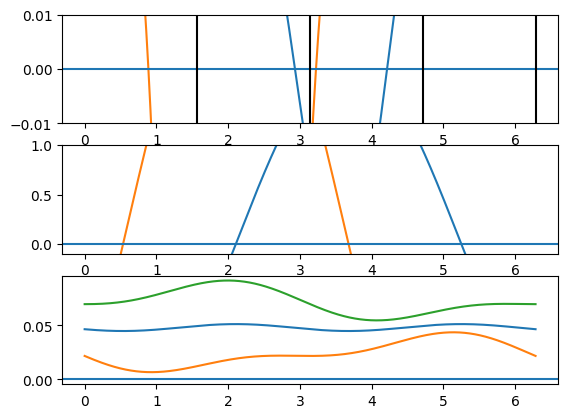

In [223]:
phis = np.linspace(0,2*np.pi,10000)
alpha = 0.5
beta = 0.8
eta1 = 0.1
eta2 = 0.05

plt.subplot(311)
plt.plot(phis,phi0(phis,alpha,beta,eta1,eta2,r0_m))
plt.plot(phis,phi0(phis,alpha,beta,eta1,eta2,r0_p))
plt.axhline(0)
plt.axvline(np.pi/2,color='black')
plt.axvline(np.pi,color='black')
plt.axvline(3*np.pi/2,color='black')
plt.axvline(4*np.pi/2,color='black')
plt.ylim(-1e-2,1e-2)

plt.subplot(312)
plt.plot(phis,r0_m(phis,alpha,beta,eta1,eta2))
plt.plot(phis,r0_p(phis,alpha,beta,eta1,eta2))
plt.axhline(0)
plt.ylim(-0.1,1)
plt.subplot(313)
plt.plot(phis,phi0_0(phis,alpha,beta,eta1,eta2))
plt.plot(phis,phi0_p1(phis,alpha,beta,eta1,eta2))
plt.plot(phis,phi0_m1(phis,alpha,beta,eta1,eta2))
plt.axhline(0)




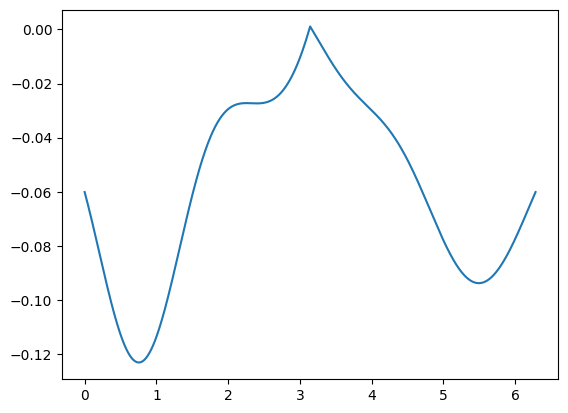

In [123]:
plt.plot(phi,phi0(phi,alpha,beta,eta1,eta2))

In [83]:
dphi.subs(r,1).simplify()

beta**2*eta1**2*sin(alpha + 2*phi) - beta**2*eta2**2*sin(alpha - 2*phi) - 2*beta*eta1*eta2*sin(alpha - phi) + 2*beta*eta1*eta2*sin(alpha + phi) - eta1*sin(alpha) + eta2*sin(alpha)

In [18]:
solve_ = eta2**2*r**2 * sp.cos(alpha) + 2*beta*eta1*eta2*r*sp.cos(alpha+phi) + beta**2*eta1**2*sp.cos(alpha+2*phi)

In [43]:
beta_rp = sp.solve(solve_,beta)[0]#.simplify()
beta_rm = sp.solve(solve_,beta)[1]#.simplify()

In [37]:
sp.solve(solve_,beta)[0]

eta2*r*(-cos(alpha + phi) + Abs(sin(phi)))/(eta1*cos(alpha + 2*phi))

In [53]:
dphi.subs(beta,beta_rp).simplify()

(-eta1**3*sin(alpha)*cos(alpha + 2*phi)**2 - 2*eta1**2*eta2**2*r**2*(-cos(alpha + phi) + Abs(sin(phi)))*sin(alpha - phi)*cos(alpha + 2*phi) + eta1**2*eta2*r*(r**2 + 1)*(eta2*r*(-cos(alpha + phi) + Abs(sin(phi)))**2*sin(alpha + 2*phi) + 2*eta2*r*(-cos(alpha + phi) + Abs(sin(phi)))*sin(alpha + phi)*cos(alpha + 2*phi) + sin(alpha)*cos(alpha + 2*phi)**2)/2 - eta2**4*r**4*(-cos(alpha + phi) + Abs(sin(phi)))**2*sin(alpha - 2*phi))/(eta1**2*cos(alpha + 2*phi)**2)

In [45]:
beta_rp

eta2*r*(-cos(alpha + phi) + Abs(sin(phi)))/(eta1*cos(alpha + 2*phi))

In [40]:
dr.subs(beta,beta_rp).simplify()


0

In [94]:
eta1,eta2,r,phi,alpha,beta,A = sp.symbols('eta1 eta2 r phi alpha beta A',real=True)
beta_rp = eta2*r/(eta1*sp.cos(alpha+2*phi))*(-sp.cos(alpha+phi)+sp.sqrt(sp.cos(alpha+phi)**2-sp.cos(alpha)*sp.cos(alpha+2*phi)))
beta_rm = eta2*r/(eta1*sp.cos(alpha+2*phi))*(-sp.cos(alpha+phi)-sp.sqrt(sp.cos(alpha+phi)**2-sp.cos(alpha)*sp.cos(alpha+2*phi)))

dr = sp.Rational(1,2) * r* (1-r**2)*(eta2**2 * r**2 * sp.cos(alpha) + 2 * beta*eta1*eta2*r*sp.cos(alpha+phi) + beta**2 * eta1**2 * sp.cos(alpha + 2*phi))
dpsi2 = - sp.Rational(1,2) * (1+r**2)*(eta2**2 * r**2 * sp.sin(alpha) + 2 * beta*eta1*eta2*r*sp.sin(alpha+phi) + beta**2 * eta1**2 * sp.sin(alpha + 2*phi))
dpsi1 = - sp.Rational(1,2) * (2)*(eta1**2 * sp.sin(alpha) + 2 * beta*eta1*eta2*r *sp.sin(alpha-phi) + beta**2 * eta2**2 * r**2 * sp.sin(alpha-2*phi))
dphi = dpsi2 - dpsi1
sol_rs =  sp.solve(dr,r)


drdphi = sp.diff(dr,phi)
drdr   = sp.diff(dr,r)

dphidphi = sp.diff(dphi,phi)
dphidr   = sp.diff(dphi,r)


beta_rp = eta2*r*(-sp.cos(alpha+phi) + sp.sin(phi))/ (eta1 * sp.cos(alpha+2*phi))
beta_rm = eta2*r*(-sp.cos(alpha+phi) - sp.sin(phi))/ (eta1 * sp.cos(alpha+2*phi))

# drdr = drdr.subs(beta,beta_rm).simplify()
# drdphi = drdphi.subs(beta,beta_rm).simplify()
# dphidr = dphidr.subs(beta,beta_rm).simplify()
# dphidphi = dphidphi.subs(beta,beta_rm).simplify()


In [95]:
dphi_sim_p = dphi.subs(beta,beta_rp).simplify()
sol_dphi_rp = sp.solve(dphi_sim_p,r)

dphi_sim_m = dphi.subs(beta,beta_rm).simplify()
sol_dphi_rm = sp.solve(dphi_sim_m,r)

In [110]:
F_dphi0_rm1 = sp.lambdify((phi,(alpha,eta1,eta2)),sol_dphi_rm[1])
F_dphi0_rm2 = sp.lambdify((phi,(alpha,eta1,eta2)),sol_dphi_rm[3])
F_dphi0_rp1 = sp.lambdify((phi,(alpha,eta1,eta2)),sol_dphi_rp[1])
F_dphi0_rp2 = sp.lambdify((phi,(alpha,eta1,eta2)),sol_dphi_rp[3])

In [98]:
print(dphidphi)

-2*beta**2*eta2**2*r**2*cos(alpha - 2*phi) - 2*beta*eta1*eta2*r*cos(alpha - phi) + (-r**2/2 - 1/2)*(2*beta**2*eta1**2*cos(alpha + 2*phi) + 2*beta*eta1*eta2*r*cos(alpha + phi))


In [121]:
J = sp.Matrix([[drdr,drdphi],[dphidr,dphidphi]])
# F_J_det_m = sp.lambdify((phi,(alpha,eta1,eta2)),J.subs(beta,beta_rm).det())
# F_J_det_p = sp.lambdify((phi,(alpha,eta1,eta2)),J.subs(beta,beta_rp).det())

# F_J_trace_m = sp.lambdify((phi,(alpha,eta1,eta2)),J.subs(beta,beta_rm).trace())
# F_J_trace_p = sp.lambdify((phi,(alpha,eta1,eta2)),J.subs(beta,beta_rp).trace())


In [ ]:
-2*beta**2*eta2**2*r**2*np.cos(alpha - 2*phi) - 2*beta*eta1*eta2*r*np.cos(alpha - phi) + (-r**2/2 - 1/2)*(2*beta**2*eta1**2*np.cos(alpha + 2*phi) + 2*beta*eta1*eta2*r*np.cos(alpha + phi))

In [99]:
def F_Jm(r,phi,alpha,eta1,eta2):
    beta = eta2*r*(-np.cos(alpha+phi) - np.sin(phi))/ (eta1 * np.cos(alpha+2*phi))
    drdr = -r**2*(beta**2*eta1**2*np.cos(alpha + 2*phi) + 2*beta*eta1*eta2*r*np.cos(alpha + phi) + eta2**2*r**2*np.cos(alpha)) + r*(1 - r**2)*(2*beta*eta1*eta2*np.cos(alpha + phi) + 2*eta2**2*r*np.cos(alpha))/2 + (1 - r**2)*(beta**2*eta1**2*np.cos(alpha + 2*phi) + 2*beta*eta1*eta2*r*np.cos(alpha + phi) + eta2**2*r**2*np.cos(alpha))/2
    drdphi = r*(1 - r**2)*(-2*beta**2*eta1**2*np.sin(alpha + 2*phi) - 2*beta*eta1*eta2*r*np.sin(alpha + phi))/2
    dphidr = 2*beta**2*eta2**2*r*np.sin(alpha - 2*phi) + 2*beta*eta1*eta2*np.sin(alpha - phi) - r*(beta**2*eta1**2*np.sin(alpha + 2*phi) + 2*beta*eta1*eta2*r*np.sin(alpha + phi) + eta2**2*r**2*np.sin(alpha)) + (-r**2/2 - 1/2)*(2*beta*eta1*eta2*np.sin(alpha + phi) + 2*eta2**2*r*np.sin(alpha))
    dphidphi = -2*beta**2*eta2**2*r**2*np.cos(alpha - 2*phi) - 2*beta*eta1*eta2*r*np.cos(alpha - phi) + (-r**2/2 - 1/2)*(2*beta**2*eta1**2*np.cos(alpha + 2*phi) + 2*beta*eta1*eta2*r*np.cos(alpha + phi))
    J = np.array([[drdr,drdphi],[dphidr,dphidphi]])
    return np.linalg.det(J),np.trace(J)

In [22]:
beta_R = eta2*r*A

In [24]:
JDET = J.det().subs(beta,beta_R).simplify()

In [25]:
n,_ = sp.fraction(JDET)

In [30]:
NR = n/(A*eta2**4*r**4)

In [36]:
PS1,PS2,PC1,PC2 = sp.symbols('PS1 PS2 PC1 PC2',real=True)
MS1,MS2,MC1,MC2 = sp.symbols('MS1 MS2 MC1 MC2',real=True)

In [ ]:
[(sp.sin(alpha-2*phi),MS2),(sp.sin(alpha+2*phi),PS2),(sp.sin(alpha-2*phi),MS1),(sp.sin(alpha-2*phi),PS1)]

In [40]:
SNR = NR.subs([(sp.cos(alpha-2*phi),MC2),(sp.cos(alpha+2*phi),PC2),(sp.cos(alpha-phi),MC1),(sp.cos(alpha+phi),PC1),(sp.sin(alpha-2*phi),MS2),(sp.sin(alpha+2*phi),PS2),(sp.sin(alpha-phi),MS1),(sp.sin(alpha+phi),PS1)])

In [42]:
NR

-2*A**3*eta1**4*r**4*sin(alpha + 2*phi)**2 - 3*A**3*eta1**4*r**4*cos(alpha + 2*phi)**2 + 2*A**3*eta1**4*r**2*sin(alpha + 2*phi)**2 - 2*A**3*eta1**4*r**2*cos(alpha + 2*phi)**2 + A**3*eta1**4*cos(alpha + 2*phi)**2 + 4*A**3*eta1**2*eta2**2*r**4*sin(alpha - 2*phi)*sin(alpha + 2*phi) - 6*A**3*eta1**2*eta2**2*r**4*cos(alpha - 2*phi)*cos(alpha + 2*phi) - 4*A**3*eta1**2*eta2**2*r**2*sin(alpha - 2*phi)*sin(alpha + 2*phi) + 2*A**3*eta1**2*eta2**2*r**2*cos(alpha - 2*phi)*cos(alpha + 2*phi) - 8*A**2*eta1**3*r**4*sin(alpha + phi)*sin(alpha + 2*phi) - 11*A**2*eta1**3*r**4*cos(alpha + phi)*cos(alpha + 2*phi) + 4*A**2*eta1**3*r**2*sin(alpha - phi)*sin(alpha + 2*phi) + 6*A**2*eta1**3*r**2*sin(alpha + phi)*sin(alpha + 2*phi) - 6*A**2*eta1**3*r**2*cos(alpha - phi)*cos(alpha + 2*phi) - 6*A**2*eta1**3*r**2*cos(alpha + phi)*cos(alpha + 2*phi) - 4*A**2*eta1**3*sin(alpha - phi)*sin(alpha + 2*phi) + 2*A**2*eta1**3*sin(alpha + phi)*sin(alpha + 2*phi) + 2*A**2*eta1**3*cos(alpha - phi)*cos(alpha + 2*phi) + 5*A**2

In [43]:
det_r0 = sp.solve(SNR,r)#.simplify()

In [44]:
det_r0[1].simplify()

sqrt((A**3*MC2*PC2*eta1**2*eta2**2 - 2*A**3*MS2*PS2*eta1**2*eta2**2 - A**3*PC2**2*eta1**4 + A**3*PS2**2*eta1**4 - 3*A**2*MC1*PC2*eta1**3 + 4*A**2*MC2*PC1*eta1*eta2**2 + 2*A**2*MS1*PS2*eta1**3 - 2*A**2*MS2*PS1*eta1*eta2**2 - 3*A**2*PC1*PC2*eta1**3 + 3*A**2*PS1*PS2*eta1**3 - 8*A*MC1*PC1*eta1**2 + 3*A*MC2*eta2**2*cos(alpha) + 2*A*MS1*PS1*eta1**2 - 2*A*PC1**2*eta1**2 - A*PC2*eta1**2*cos(alpha) + 2*A*PS1**2*eta1**2 + A*PS2*eta1**2*sin(alpha) - 5*MC1*eta1*cos(alpha) - PC1*eta1*cos(alpha) + PS1*eta1*sin(alpha) - sqrt(A**6*MC2**2*PC2**2*eta1**4*eta2**4 - 4*A**6*MC2*MS2*PC2*PS2*eta1**4*eta2**4 + 4*A**6*MC2*PC2**3*eta1**6*eta2**2 + 2*A**6*MC2*PC2*PS2**2*eta1**6*eta2**2 + 4*A**6*MS2**2*PS2**2*eta1**4*eta2**4 - 4*A**6*MS2*PS2**3*eta1**6*eta2**2 + 4*A**6*PC2**4*eta1**8 + A**6*PS2**4*eta1**8 + 6*A**5*MC1*MC2*PC2**2*eta1**5*eta2**2 + 4*A**5*MC1*MS2*PC2*PS2*eta1**5*eta2**2 + 12*A**5*MC1*PC2**3*eta1**7 - 2*A**5*MC1*PC2*PS2**2*eta1**7 + 8*A**5*MC2**2*PC1*PC2*eta1**3*eta2**4 - 20*A**5*MC2*MS1*PC2*PS2*eta

In [122]:
J_trace_0m = sp.solve(J.trace().subs(beta,beta_rm),r)
J_trace_0p = sp.solve(J.trace().subs(beta,beta_rp),r)

In [123]:
J_trace_0m[2]

eta1*sqrt((3*sin(phi)**2 - 4*sin(phi)*cos(alpha - phi) + 3*cos(alpha)*cos(alpha + 2*phi) - 4*cos(alpha - phi)*cos(alpha + phi) - 3*cos(alpha + phi)**2)*cos(alpha + 2*phi)/(eta1**2*sin(phi)**2*cos(alpha + 2*phi) - 4*eta1**2*sin(phi)*cos(alpha + phi)*cos(alpha + 2*phi) + 5*eta1**2*cos(alpha)*cos(alpha + 2*phi)**2 - 5*eta1**2*cos(alpha + phi)**2*cos(alpha + 2*phi) - 4*eta2**2*sin(phi)**2*cos(alpha - 2*phi) - 8*eta2**2*sin(phi)*cos(alpha - 2*phi)*cos(alpha + phi) - 4*eta2**2*cos(alpha - 2*phi)*cos(alpha + phi)**2))

In [124]:
F_trace0_rm = sp.lambdify((phi,(alpha,eta1,eta2)),J_trace_0m[2])
F_trace0_rp = sp.lambdify((phi,(alpha,eta1,eta2)),J_trace_0p[2])

In [112]:
J_det_0m = sp.solve(J.det().subs(beta,beta_rm),r)
J_det_0p = sp.solve(J.det().subs(beta,beta_rp),r)


In [45]:
A_temp = J_det_0m[2]

In [ ]:
C = sp.sym('C',real=True)


In [65]:
SPHI = sp.sin(phi)
CPHI = sp.cos(phi)
SA = sp.sin(alpha)
CA = sp.cos(alpha)
A2SPHI = sp.sin(alpha + 2*phi)
A1SPHI = sp.sin(alpha + phi)
A2CPHI = sp.cos(alpha + 2*phi)
A1CPHI = sp.cos(alpha + phi)
A2MSPHI = sp.sin(alpha - 2*phi)
A1MSPHI = sp.sin(alpha - phi)
A1MCPHI = sp.cos(alpha - phi)
A2MCPHI = sp.cos(alpha - 2*phi)

C = sp.IndexedBase('C',real=True)
NN1 = sp.symbols('NN',real=True)
Cs =[(eta1**2*SA*SPHI*A2SPHI*A2CPHI**2, C[1]),
    (eta1**2*SA*A1SPHI*A2CPHI**3, C[2]),
    (eta1**2*SA*A2SPHI*A1CPHI*A2CPHI**2, C[3]),
    (eta1**2*SPHI**3*A2SPHI**2, C[4]),
    (eta1**2*SPHI**3*A2CPHI**2, C[5]),
    (eta1**2*SPHI**2*A1SPHI*A2SPHI*A2CPHI, C[6]),
    (eta1**2*SPHI**2*A2SPHI**2*A1CPHI, C[7]),
    (eta1**2*SPHI**2*A1CPHI*A2CPHI**2, C[8]),
    (eta1**2*SPHI*A1SPHI**2*A2CPHI**2, C[9]),
    (eta1**2*SPHI*A1SPHI*A2SPHI*A1CPHI*A2CPHI, C[10]),
    (eta1**2*SPHI*A2SPHI**2*A1CPHI**2, C[11]),
    (eta1**2*SPHI*CA*A2CPHI**3, C[12]),
    (eta1**2*SPHI*A1CPHI**2*A2CPHI**2, C[13]),
    (eta1**2*A1SPHI**2*A1CPHI*A2CPHI**2, C[14]),
    (eta1**2*A1SPHI*A2SPHI*A1CPHI**2*A2CPHI, C[15]),
    (eta1**2*A2SPHI**2*A1CPHI**3, C[16]),
    (eta2**2*SPHI**3*A2MSPHI*A2SPHI, C[17]),
    (eta2**2*SPHI**3*A2MCPHI*A2CPHI, C[18]),
    (eta2**2*SPHI**2*A2MSPHI*A1SPHI*A2CPHI, C[19]),
    (eta2**2*SPHI**2*A2MSPHI*A2SPHI*A1CPHI, C[20]),
    (eta2**2*SPHI**2*A2MCPHI*A1CPHI*A2CPHI, C[21]),
    (eta2**2*SPHI*A2MSPHI*A1SPHI*A1CPHI*A2CPHI, C[22]),
    (eta2**2*SPHI*A2MSPHI*A2SPHI*A1CPHI**2, C[23]),
    (eta2**2*SPHI*CA*A2MCPHI*A2CPHI**2, C[24]),
    (eta2**2*SPHI*A2MCPHI*A1CPHI**2*A2CPHI, C[25]),
    (eta2**2*A2MSPHI*A1SPHI*A1CPHI**2*A2CPHI, C[26]),
    (eta2**2*A2MSPHI*A2SPHI*A1CPHI**3, C[27]),
    (eta2**2*CA*A2MCPHI*A1CPHI*A2CPHI**2, C[28]),
    (eta2**2*A2MCPHI*A1CPHI**3*A2CPHI, C[29])]

NN =  -16*C[10] + 6*C[11] + 5*C[12] - 5*C[13] + 6*C[14] - 8*C[15] + 2*C[16] - 4*C[17] + 6*C[18] + 4*C[19] + 4*C[1] - 12*C[20] + 2*C[21] + 8*C[22] - 12*C[23] + 10*C[24] - 14*C[25] + 4*C[26] - 4*C[27] + 10*C[28] - 10*C[29] - 4*C[2] + 4*C[3] + 2*C[4] + 3*C[5] - 8*C[6] + 6*C[7] - 2*C[8] + 6*C[9]
C1 = eta1**2*SA*SPHI*A2SPHI*A2CPHI**2
C17 = eta2**2*SPHI**3*A2MSPHI*A2SPHI
C20 = eta2**2*SPHI**2*A2MSPHI*A2SPHI*A1CPHI

AA = (sp.sqrt(9*C1**2 - 18*eta1**4*SA**2*SPHI*A1SPHI*A2SPHI*A2CPHI**5 + 18*eta1**4*SA**2*SPHI*A2SPHI**2*A1CPHI*A2CPHI**4 + 9*eta1**4*SA**2*A1SPHI**2*A2CPHI**6 - 18*eta1**4*SA**2*A1SPHI*A2SPHI*A1CPHI*A2CPHI**5 + 9*eta1**4*SA**2*A2SPHI**2*A1CPHI**2*A2CPHI**4 + 6*eta1**4*SA*SPHI**4*A2SPHI**3*A2CPHI**2 + 8*eta1**4*SA*SPHI**4*A2SPHI*A2CPHI**4 + 12*eta1**4*SA*SPHI**3*A1MSPHI*A2SPHI**2*A2CPHI**3 - 36*eta1**4*SA*SPHI**3*A1SPHI*A2SPHI**2*A2CPHI**3 - 8*eta1**4*SA*SPHI**3*A1SPHI*A2CPHI**5 + 24*eta1**4*SA*SPHI**3*A2SPHI**3*A1CPHI*A2CPHI**2 - 2*eta1**4*SA*SPHI**3*A2SPHI*A1MCPHI*A2CPHI**4 - 4*eta1**4*SA*SPHI**3*A2SPHI*A1CPHI*A2CPHI**4 - 24*eta1**4*SA*SPHI**2*A1MSPHI*A1SPHI*A2SPHI*A2CPHI**4 + 36*eta1**4*SA*SPHI**2*A1MSPHI*A2SPHI**2*A1CPHI*A2CPHI**3 + 54*eta1**4*SA*SPHI**2*A1SPHI**2*A2SPHI*A2CPHI**4 - 108*eta1**4*SA*SPHI**2*A1SPHI*A2SPHI**2*A1CPHI*A2CPHI**3 + 2*eta1**4*SA*SPHI**2*A1SPHI*A1MCPHI*A2CPHI**5 + 12*eta1**4*SA*SPHI**2*A1SPHI*A1CPHI*A2CPHI**5 + 36*eta1**4*SA*SPHI**2*A2SPHI**3*A1CPHI**2*A2CPHI**2 + 20*eta1**4*SA*SPHI**2*A2SPHI*CA*A2CPHI**5 + 10*eta1**4*SA*SPHI**2*A2SPHI*A1MCPHI*A1CPHI*A2CPHI**4 - 32*eta1**4*SA*SPHI**2*A2SPHI*A1CPHI**2*A2CPHI**4 + 12*eta1**4*SA*SPHI*A1MSPHI*A1SPHI**2*A2CPHI**5 - 48*eta1**4*SA*SPHI*A1MSPHI*A1SPHI*A2SPHI*A1CPHI*A2CPHI**4 + 36*eta1**4*SA*SPHI*A1MSPHI*A2SPHI**2*A1CPHI**2*A2CPHI**3 - 24*eta1**4*SA*SPHI*A1SPHI**3*A2CPHI**5 + 108*eta1**4*SA*SPHI*A1SPHI**2*A2SPHI*A1CPHI*A2CPHI**4 - 108*eta1**4*SA*SPHI*A1SPHI*A2SPHI**2*A1CPHI**2*A2CPHI**3 - 20*eta1**4*SA*SPHI*A1SPHI*CA*A2CPHI**6 - 12*eta1**4*SA*SPHI*A1SPHI*A1MCPHI*A1CPHI*A2CPHI**5 + 20*eta1**4*SA*SPHI*A1SPHI*A1CPHI**2*A2CPHI**5 + 24*eta1**4*SA*SPHI*A2SPHI**3*A1CPHI**3*A2CPHI**2 - 14*eta1**4*SA*SPHI*A2SPHI*CA*A1MCPHI*A2CPHI**5 + 20*eta1**4*SA*SPHI*A2SPHI*CA*A1CPHI*A2CPHI**5 + 26*eta1**4*SA*SPHI*A2SPHI*A1MCPHI*A1CPHI**2*A2CPHI**4 - 20*eta1**4*SA*SPHI*A2SPHI*A1CPHI**3*A2CPHI**4 + 12*eta1**4*SA*A1MSPHI*A1SPHI**2*A1CPHI*A2CPHI**5 - 24*eta1**4*SA*A1MSPHI*A1SPHI*A2SPHI*A1CPHI**2*A2CPHI**4 + 12*eta1**4*SA*A1MSPHI*A2SPHI**2*A1CPHI**3*A2CPHI**3 - 24*eta1**4*SA*A1SPHI**3*A1CPHI*A2CPHI**5 + 54*eta1**4*SA*A1SPHI**2*A2SPHI*A1CPHI**2*A2CPHI**4 - 36*eta1**4*SA*A1SPHI*A2SPHI**2*A1CPHI**3*A2CPHI**3 + 14*eta1**4*SA*A1SPHI*CA*A1MCPHI*A2CPHI**6 - 14*eta1**4*SA*A1SPHI*A1MCPHI*A1CPHI**2*A2CPHI**5 + 6*eta1**4*SA*A2SPHI**3*A1CPHI**4*A2CPHI**2 - 14*eta1**4*SA*A2SPHI*CA*A1MCPHI*A1CPHI*A2CPHI**5 + 14*eta1**4*SA*A2SPHI*A1MCPHI*A1CPHI**3*A2CPHI**4 + eta1**4*SPHI**6*A2SPHI**4 + 4*eta1**4*SPHI**6*A2CPHI**4 + 4*eta1**4*SPHI**5*A1MSPHI*A2SPHI**3*A2CPHI + 16*eta1**4*SPHI**5*A1MSPHI*A2SPHI*A2CPHI**3 - 10*eta1**4*SPHI**5*A1SPHI*A2SPHI**3*A2CPHI - 8*eta1**4*SPHI**5*A1SPHI*A2SPHI*A2CPHI**3 + 6*eta1**4*SPHI**5*A2SPHI**4*A1CPHI + 2*eta1**4*SPHI**5*A2SPHI**2*A1MCPHI*A2CPHI**2 - 4*eta1**4*SPHI**5*A2SPHI**2*A1CPHI*A2CPHI**2 - 12*eta1**4*SPHI**5*A1MCPHI*A2CPHI**4 - 8*eta1**4*SPHI**5*A1CPHI*A2CPHI**4 + 4*eta1**4*SPHI**4*A1MSPHI**2*A2SPHI**2*A2CPHI**2 - 24*eta1**4*SPHI**4*A1MSPHI*A1SPHI*A2SPHI**2*A2CPHI**2 - 16*eta1**4*SPHI**4*A1MSPHI*A1SPHI*A2CPHI**4 + 20*eta1**4*SPHI**4*A1MSPHI*A2SPHI**3*A1CPHI*A2CPHI - 12*eta1**4*SPHI**4*A1MSPHI*A2SPHI*A1MCPHI*A2CPHI**3 + 24*eta1**4*SPHI**4*A1MSPHI*A2SPHI*A1CPHI*A2CPHI**3 + 33*eta1**4*SPHI**4*A1SPHI**2*A2SPHI**2*A2CPHI**2 + 8*eta1**4*SPHI**4*A1SPHI**2*A2CPHI**4 - 50*eta1**4*SPHI**4*A1SPHI*A2SPHI**3*A1CPHI*A2CPHI - 2*eta1**4*SPHI**4*A1SPHI*A2SPHI*A1MCPHI*A2CPHI**3 + 4*eta1**4*SPHI**4*A1SPHI*A2SPHI*A1CPHI*A2CPHI**3 + 15*eta1**4*SPHI**4*A2SPHI**4*A1CPHI**2 + 4*eta1**4*SPHI**4*A2SPHI**2*CA*A2CPHI**3 + 10*eta1**4*SPHI**4*A2SPHI**2*A1MCPHI*A1CPHI*A2CPHI**2 - 16*eta1**4*SPHI**4*A2SPHI**2*A1CPHI**2*A2CPHI**2 + 16*eta1**4*SPHI**4*CA*A2CPHI**5 + 9*eta1**4*SPHI**4*A1MCPHI**2*A2CPHI**4 + 20*eta1**4*SPHI**4*A1MCPHI*A1CPHI*A2CPHI**4 - 12*eta1**4*SPHI**4*A1CPHI**2*A2CPHI**4 - 8*eta1**4*SPHI**3*A1MSPHI**2*A1SPHI*A2SPHI*A2CPHI**3 + 16*eta1**4*SPHI**3*A1MSPHI**2*A2SPHI**2*A1CPHI*A2CPHI**2 + 36*eta1**4*SPHI**3*A1MSPHI*A1SPHI**2*A2SPHI*A2CPHI**3 - 96*eta1**4*SPHI**3*A1MSPHI*A1SPHI*A2SPHI**2*A1CPHI*A2CPHI**2 + 12*eta1**4*SPHI**3*A1MSPHI*A1SPHI*A1MCPHI*A2CPHI**4 - 8*eta1**4*SPHI**3*A1MSPHI*A1SPHI*A1CPHI*A2CPHI**4 + 40*eta1**4*SPHI**3*A1MSPHI*A2SPHI**3*A1CPHI**2*A2CPHI + 24*eta1**4*SPHI**3*A1MSPHI*A2SPHI*CA*A2CPHI**4 - 16*eta1**4*SPHI**3*A1MSPHI*A2SPHI*A1MCPHI*A1CPHI*A2CPHI**3 - 24*eta1**4*SPHI**3*A1MSPHI*A2SPHI*A1CPHI**2*A2CPHI**3 - 40*eta1**4*SPHI**3*A1SPHI**3*A2SPHI*A2CPHI**3 + 132*eta1**4*SPHI**3*A1SPHI**2*A2SPHI**2*A1CPHI*A2CPHI**2 - 8*eta1**4*SPHI**3*A1SPHI**2*A1CPHI*A2CPHI**4 - 100*eta1**4*SPHI**3*A1SPHI*A2SPHI**3*A1CPHI**2*A2CPHI - 28*eta1**4*SPHI**3*A1SPHI*A2SPHI*CA*A2CPHI**4 - 24*eta1**4*SPHI**3*A1SPHI*A2SPHI*A1MCPHI*A1CPHI*A2CPHI**3 + 60*eta1**4*SPHI**3*A1SPHI*A2SPHI*A1CPHI**2*A2CPHI**3 + 20*eta1**4*SPHI**3*A2SPHI**4*A1CPHI**3 - 2*eta1**4*SPHI**3*A2SPHI**2*CA*A1MCPHI*A2CPHI**3 + 12*eta1**4*SPHI**3*A2SPHI**2*CA*A1CPHI*A2CPHI**3 + 20*eta1**4*SPHI**3*A2SPHI**2*A1MCPHI*A1CPHI**2*A2CPHI**2 - 24*eta1**4*SPHI**3*A2SPHI**2*A1CPHI**3*A2CPHI**2 - 44*eta1**4*SPHI**3*CA*A1MCPHI*A2CPHI**5 - 16*eta1**4*SPHI**3*CA*A1CPHI*A2CPHI**5 - 12*eta1**4*SPHI**3*A1MCPHI**2*A1CPHI*A2CPHI**4 + 36*eta1**4*SPHI**3*A1MCPHI*A1CPHI**2*A2CPHI**4 + 16*eta1**4*SPHI**3*A1CPHI**3*A2CPHI**4 + 4*eta1**4*SPHI**2*A1MSPHI**2*A1SPHI**2*A2CPHI**4 - 24*eta1**4*SPHI**2*A1MSPHI**2*A1SPHI*A2SPHI*A1CPHI*A2CPHI**3 + 24*eta1**4*SPHI**2*A1MSPHI**2*A2SPHI**2*A1CPHI**2*A2CPHI**2 - 16*eta1**4*SPHI**2*A1MSPHI*A1SPHI**3*A2CPHI**4 + 108*eta1**4*SPHI**2*A1MSPHI*A1SPHI**2*A2SPHI*A1CPHI*A2CPHI**3 - 144*eta1**4*SPHI**2*A1MSPHI*A1SPHI*A2SPHI**2*A1CPHI**2*A2CPHI**2 - 24*eta1**4*SPHI**2*A1MSPHI*A1SPHI*CA*A2CPHI**5 + 4*eta1**4*SPHI**2*A1MSPHI*A1SPHI*A1MCPHI*A1CPHI*A2CPHI**4 + 32*eta1**4*SPHI**2*A1MSPHI*A1SPHI*A1CPHI**2*A2CPHI**4 + 40*eta1**4*SPHI**2*A1MSPHI*A2SPHI**3*A1CPHI**3*A2CPHI - 20*eta1**4*SPHI**2*A1MSPHI*A2SPHI*CA*A1MCPHI*A2CPHI**4 + 48*eta1**4*SPHI**2*A1MSPHI*A2SPHI*CA*A1CPHI*A2CPHI**4 + 24*eta1**4*SPHI**2*A1MSPHI*A2SPHI*A1MCPHI*A1CPHI**2*A2CPHI**3 - 56*eta1**4*SPHI**2*A1MSPHI*A2SPHI*A1CPHI**3*A2CPHI**3 + 16*eta1**4*SPHI**2*A1SPHI**4*A2CPHI**4 - 120*eta1**4*SPHI**2*A1SPHI**3*A2SPHI*A1CPHI*A2CPHI**3 + 198*eta1**4*SPHI**2*A1SPHI**2*A2SPHI**2*A1CPHI**2*A2CPHI**2 + 24*eta1**4*SPHI**2*A1SPHI**2*CA*A2CPHI**5 + 16*eta1**4*SPHI**2*A1SPHI**2*A1MCPHI*A1CPHI*A2CPHI**4 - 40*eta1**4*SPHI**2*A1SPHI**2*A1CPHI**2*A2CPHI**4 - 100*eta1**4*SPHI**2*A1SPHI*A2SPHI**3*A1CPHI**3*A2CPHI + 18*eta1**4*SPHI**2*A1SPHI*A2SPHI*CA*A1MCPHI*A2CPHI**4 - 56*eta1**4*SPHI**2*A1SPHI*A2SPHI*CA*A1CPHI*A2CPHI**4 - 60*eta1**4*SPHI**2*A1SPHI*A2SPHI*A1MCPHI*A1CPHI**2*A2CPHI**3 + 76*eta1**4*SPHI**2*A1SPHI*A2SPHI*A1CPHI**3*A2CPHI**3 + 15*eta1**4*SPHI**2*A2SPHI**4*A1CPHI**4 - 6*eta1**4*SPHI**2*A2SPHI**2*CA*A1MCPHI*A1CPHI*A2CPHI**3 + 12*eta1**4*SPHI**2*A2SPHI**2*CA*A1CPHI**2*A2CPHI**3 + 20*eta1**4*SPHI**2*A2SPHI**2*A1MCPHI*A1CPHI**3*A2CPHI**2 - 16*eta1**4*SPHI**2*A2SPHI**2*A1CPHI**4*A2CPHI**2 + 16*eta1**4*SPHI**2*CA**2*A2CPHI**6 + 30*eta1**4*SPHI**2*CA*A1MCPHI**2*A2CPHI**5 + 36*eta1**4*SPHI**2*CA*A1MCPHI*A1CPHI*A2CPHI**5 - 32*eta1**4*SPHI**2*CA*A1CPHI**2*A2CPHI**5 - 26*eta1**4*SPHI**2*A1MCPHI**2*A1CPHI**2*A2CPHI**4 - 36*eta1**4*SPHI**2*A1MCPHI*A1CPHI**3*A2CPHI**4 + 16*eta1**4*SPHI**2*A1CPHI**4*A2CPHI**4 + 8*eta1**4*SPHI*A1MSPHI**2*A1SPHI**2*A1CPHI*A2CPHI**4 - 24*eta1**4*SPHI*A1MSPHI**2*A1SPHI*A2SPHI*A1CPHI**2*A2CPHI**3 + 16*eta1**4*SPHI*A1MSPHI**2*A2SPHI**2*A1CPHI**3*A2CPHI**2 - 32*eta1**4*SPHI*A1MSPHI*A1SPHI**3*A1CPHI*A2CPHI**4 + 108*eta1**4*SPHI*A1MSPHI*A1SPHI**2*A2SPHI*A1CPHI**2*A2CPHI**3 - 96*eta1**4*SPHI*A1MSPHI*A1SPHI*A2SPHI**2*A1CPHI**3*A2CPHI**2 + 20*eta1**4*SPHI*A1MSPHI*A1SPHI*CA*A1MCPHI*A2CPHI**5 - 24*eta1**4*SPHI*A1MSPHI*A1SPHI*CA*A1CPHI*A2CPHI**5 - 28*eta1**4*SPHI*A1MSPHI*A1SPHI*A1MCPHI*A1CPHI**2*A2CPHI**4 + 24*eta1**4*SPHI*A1MSPHI*A1SPHI*A1CPHI**3*A2CPHI**4 + 20*eta1**4*SPHI*A1MSPHI*A2SPHI**3*A1CPHI**4*A2CPHI - 40*eta1**4*SPHI*A1MSPHI*A2SPHI*CA*A1MCPHI*A1CPHI*A2CPHI**4 + 24*eta1**4*SPHI*A1MSPHI*A2SPHI*CA*A1CPHI**2*A2CPHI**4 + 48*eta1**4*SPHI*A1MSPHI*A2SPHI*A1MCPHI*A1CPHI**3*A2CPHI**3 - 24*eta1**4*SPHI*A1MSPHI*A2SPHI*A1CPHI**4*A2CPHI**3 + 32*eta1**4*SPHI*A1SPHI**4*A1CPHI*A2CPHI**4 - 120*eta1**4*SPHI*A1SPHI**3*A2SPHI*A1CPHI**2*A2CPHI**3 + 132*eta1**4*SPHI*A1SPHI**2*A2SPHI**2*A1CPHI**3*A2CPHI**2 - 16*eta1**4*SPHI*A1SPHI**2*CA*A1MCPHI*A2CPHI**5 + 24*eta1**4*SPHI*A1SPHI**2*CA*A1CPHI*A2CPHI**5 + 32*eta1**4*SPHI*A1SPHI**2*A1MCPHI*A1CPHI**2*A2CPHI**4 - 24*eta1**4*SPHI*A1SPHI**2*A1CPHI**3*A2CPHI**4 - 50*eta1**4*SPHI*A1SPHI*A2SPHI**3*A1CPHI**4*A2CPHI + 36*eta1**4*SPHI*A1SPHI*A2SPHI*CA*A1MCPHI*A1CPHI*A2CPHI**4 - 28*eta1**4*SPHI*A1SPHI*A2SPHI*CA*A1CPHI**2*A2CPHI**4 - 56*eta1**4*SPHI*A1SPHI*A2SPHI*A1MCPHI*A1CPHI**3*A2CPHI**3 + 28*eta1**4*SPHI*A1SPHI*A2SPHI*A1CPHI**4*A2CPHI**3 + 6*eta1**4*SPHI*A2SPHI**4*A1CPHI**5 - 6*eta1**4*SPHI*A2SPHI**2*CA*A1MCPHI*A1CPHI**2*A2CPHI**3 + 4*eta1**4*SPHI*A2SPHI**2*CA*A1CPHI**3*A2CPHI**3 + 10*eta1**4*SPHI*A2SPHI**2*A1MCPHI*A1CPHI**4*A2CPHI**2 - 4*eta1**4*SPHI*A2SPHI**2*A1CPHI**5*A2CPHI**2 - 40*eta1**4*SPHI*CA**2*A1MCPHI*A2CPHI**6 - 20*eta1**4*SPHI*CA*A1MCPHI**2*A1CPHI*A2CPHI**5 + 80*eta1**4*SPHI*CA*A1MCPHI*A1CPHI**2*A2CPHI**5 + 20*eta1**4*SPHI*A1MCPHI**2*A1CPHI**3*A2CPHI**4 - 40*eta1**4*SPHI*A1MCPHI*A1CPHI**4*A2CPHI**4 + 4*eta1**4*A1MSPHI**2*A1SPHI**2*A1CPHI**2*A2CPHI**4 - 8*eta1**4*A1MSPHI**2*A1SPHI*A2SPHI*A1CPHI**3*A2CPHI**3 + 4*eta1**4*A1MSPHI**2*A2SPHI**2*A1CPHI**4*A2CPHI**2 - 16*eta1**4*A1MSPHI*A1SPHI**3*A1CPHI**2*A2CPHI**4 + 36*eta1**4*A1MSPHI*A1SPHI**2*A2SPHI*A1CPHI**3*A2CPHI**3 - 24*eta1**4*A1MSPHI*A1SPHI*A2SPHI**2*A1CPHI**4*A2CPHI**2 + 20*eta1**4*A1MSPHI*A1SPHI*CA*A1MCPHI*A1CPHI*A2CPHI**5 - 20*eta1**4*A1MSPHI*A1SPHI*A1MCPHI*A1CPHI**3*A2CPHI**4 + 4*eta1**4*A1MSPHI*A2SPHI**3*A1CPHI**5*A2CPHI - 20*eta1**4*A1MSPHI*A2SPHI*CA*A1MCPHI*A1CPHI**2*A2CPHI**4 + 20*eta1**4*A1MSPHI*A2SPHI*A1MCPHI*A1CPHI**4*A2CPHI**3 + 16*eta1**4*A1SPHI**4*A1CPHI**2*A2CPHI**4 - 40*eta1**4*A1SPHI**3*A2SPHI*A1CPHI**3*A2CPHI**3 + 33*eta1**4*A1SPHI**2*A2SPHI**2*A1CPHI**4*A2CPHI**2 - 16*eta1**4*A1SPHI**2*CA*A1MCPHI*A1CPHI*A2CPHI**5 + 16*eta1**4*A1SPHI**2*A1MCPHI*A1CPHI**3*A2CPHI**4 - 10*eta1**4*A1SPHI*A2SPHI**3*A1CPHI**5*A2CPHI + 18*eta1**4*A1SPHI*A2SPHI*CA*A1MCPHI*A1CPHI**2*A2CPHI**4 - 18*eta1**4*A1SPHI*A2SPHI*A1MCPHI*A1CPHI**4*A2CPHI**3 + eta1**4*A2SPHI**4*A1CPHI**6 - 2*eta1**4*A2SPHI**2*CA*A1MCPHI*A1CPHI**3*A2CPHI**3 + 2*eta1**4*A2SPHI**2*A1MCPHI*A1CPHI**5*A2CPHI**2 + 25*eta1**4*CA**2*A1MCPHI**2*A2CPHI**6 - 50*eta1**4*CA*A1MCPHI**2*A1CPHI**2*A2CPHI**5 + 25*eta1**4*A1MCPHI**2*A1CPHI**4*A2CPHI**4 - 12*eta1**2*eta2**2*SA*SPHI**4*A2MSPHI*A2SPHI**2*A2CPHI**2 + 14*eta1**2*eta2**2*SA*SPHI**4*A2SPHI*A2MCPHI*A2CPHI**3 + 24*eta1**2*eta2**2*SA*SPHI**3*A2MSPHI*A1SPHI*A2SPHI*A2CPHI**3 - 48*eta1**2*eta2**2*SA*SPHI**3*A2MSPHI*A2SPHI**2*A1CPHI*A2CPHI**2 - 14*eta1**2*eta2**2*SA*SPHI**3*A1SPHI*A2MCPHI*A2CPHI**4 + 16*eta1**2*eta2**2*SA*SPHI**3*A2SPHI*A2MCPHI*A1CPHI*A2CPHI**3 - 12*eta1**2*eta2**2*SA*SPHI**2*A2MSPHI*A1SPHI**2*A2CPHI**4 + 72*eta1**2*eta2**2*SA*SPHI**2*A2MSPHI*A1SPHI*A2SPHI*A1CPHI*A2CPHI**3 - 72*eta1**2*eta2**2*SA*SPHI**2*A2MSPHI*A2SPHI**2*A1CPHI**2*A2CPHI**2 - 2*eta1**2*eta2**2*SA*SPHI**2*A1SPHI*A2MCPHI*A1CPHI*A2CPHI**4 + 26*eta1**2*eta2**2*SA*SPHI**2*A2SPHI*CA*A2MCPHI*A2CPHI**4 - 36*eta1**2*eta2**2*SA*SPHI**2*A2SPHI*A2MCPHI*A1CPHI**2*A2CPHI**3 - 24*eta1**2*eta2**2*SA*SPHI*A2MSPHI*A1SPHI**2*A1CPHI*A2CPHI**4 + 72*eta1**2*eta2**2*SA*SPHI*A2MSPHI*A1SPHI*A2SPHI*A1CPHI**2*A2CPHI**3 - 48*eta1**2*eta2**2*SA*SPHI*A2MSPHI*A2SPHI**2*A1CPHI**3*A2CPHI**2 - 26*eta1**2*eta2**2*SA*SPHI*A1SPHI*CA*A2MCPHI*A2CPHI**5 + 38*eta1**2*eta2**2*SA*SPHI*A1SPHI*A2MCPHI*A1CPHI**2*A2CPHI**4 + 52*eta1**2*eta2**2*SA*SPHI*A2SPHI*CA*A2MCPHI*A1CPHI*A2CPHI**4 - 64*eta1**2*eta2**2*SA*SPHI*A2SPHI*A2MCPHI*A1CPHI**3*A2CPHI**3 - 12*eta1**2*eta2**2*SA*A2MSPHI*A1SPHI**2*A1CPHI**2*A2CPHI**4 + 24*eta1**2*eta2**2*SA*A2MSPHI*A1SPHI*A2SPHI*A1CPHI**3*A2CPHI**3 - 12*eta1**2*eta2**2*SA*A2MSPHI*A2SPHI**2*A1CPHI**4*A2CPHI**2 - 26*eta1**2*eta2**2*SA*A1SPHI*CA*A2MCPHI*A1CPHI*A2CPHI**5 + 26*eta1**2*eta2**2*SA*A1SPHI*A2MCPHI*A1CPHI**3*A2CPHI**4 + 26*eta1**2*eta2**2*SA*A2SPHI*CA*A2MCPHI*A1CPHI**2*A2CPHI**4 - 26*eta1**2*eta2**2*SA*A2SPHI*A2MCPHI*A1CPHI**4*A2CPHI**3 - 4*eta1**2*eta2**2*SPHI**6*A2MSPHI*A2SPHI**3 + 2*eta1**2*eta2**2*SPHI**6*A2SPHI**2*A2MCPHI*A2CPHI + 4*eta1**2*eta2**2*SPHI**6*A2MCPHI*A2CPHI**3 - 8*eta1**2*eta2**2*SPHI**5*A2MSPHI*A1MSPHI*A2SPHI**2*A2CPHI + 24*eta1**2*eta2**2*SPHI**5*A2MSPHI*A1SPHI*A2SPHI**2*A2CPHI - 24*eta1**2*eta2**2*SPHI**5*A2MSPHI*A2SPHI**3*A1CPHI - 4*eta1**2*eta2**2*SPHI**5*A2MSPHI*A2SPHI*A1MCPHI*A2CPHI**2 + 8*eta1**2*eta2**2*SPHI**5*A2MSPHI*A2SPHI*A1CPHI*A2CPHI**2 + 20*eta1**2*eta2**2*SPHI**5*A1MSPHI*A2SPHI*A2MCPHI*A2CPHI**2 - 18*eta1**2*eta2**2*SPHI**5*A1SPHI*A2SPHI*A2MCPHI*A2CPHI**2 + 4*eta1**2*eta2**2*SPHI**5*A2SPHI**2*A2MCPHI*A1CPHI*A2CPHI - 6*eta1**2*eta2**2*SPHI**5*A2MCPHI*A1MCPHI*A2CPHI**3 - 8*eta1**2*eta2**2*SPHI**5*A2MCPHI*A1CPHI*A2CPHI**3 + 16*eta1**2*eta2**2*SPHI**4*A2MSPHI*A1MSPHI*A1SPHI*A2SPHI*A2CPHI**2 - 40*eta1**2*eta2**2*SPHI**4*A2MSPHI*A1MSPHI*A2SPHI**2*A1CPHI*A2CPHI - 36*eta1**2*eta2**2*SPHI**4*A2MSPHI*A1SPHI**2*A2SPHI*A2CPHI**2 + 120*eta1**2*eta2**2*SPHI**4*A2MSPHI*A1SPHI*A2SPHI**2*A1CPHI*A2CPHI + 4*eta1**2*eta2**2*SPHI**4*A2MSPHI*A1SPHI*A1MCPHI*A2CPHI**3 - 8*eta1**2*eta2**2*SPHI**4*A2MSPHI*A1SPHI*A1CPHI*A2CPHI**3 - 60*eta1**2*eta2**2*SPHI**4*A2MSPHI*A2SPHI**3*A1CPHI**2 - 8*eta1**2*eta2**2*SPHI**4*A2MSPHI*A2SPHI*CA*A2CPHI**3 - 20*eta1**2*eta2**2*SPHI**4*A2MSPHI*A2SPHI*A1MCPHI*A1CPHI*A2CPHI**2 + 32*eta1**2*eta2**2*SPHI**4*A2MSPHI*A2SPHI*A1CPHI**2*A2CPHI**2 - 20*eta1**2*eta2**2*SPHI**4*A1MSPHI*A1SPHI*A2MCPHI*A2CPHI**3 + 52*eta1**2*eta2**2*SPHI**4*A1MSPHI*A2SPHI*A2MCPHI*A1CPHI*A2CPHI**2 + 16*eta1**2*eta2**2*SPHI**4*A1SPHI**2*A2MCPHI*A2CPHI**3 - 34*eta1**2*eta2**2*SPHI**4*A1SPHI*A2SPHI*A2MCPHI*A1CPHI*A2CPHI**2 + 6*eta1**2*eta2**2*SPHI**4*A2SPHI**2*CA*A2MCPHI*A2CPHI**2 - 10*eta1**2*eta2**2*SPHI**4*A2SPHI**2*A2MCPHI*A1CPHI**2*A2CPHI + 20*eta1**2*eta2**2*SPHI**4*CA*A2MCPHI*A2CPHI**4 + 10*eta1**2*eta2**2*SPHI**4*A2MCPHI*A1MCPHI*A1CPHI*A2CPHI**3 - 24*eta1**2*eta2**2*SPHI**4*A2MCPHI*A1CPHI**2*A2CPHI**3 - 8*eta1**2*eta2**2*SPHI**3*A2MSPHI*A1MSPHI*A1SPHI**2*A2CPHI**3 + 64*eta1**2*eta2**2*SPHI**3*A2MSPHI*A1MSPHI*A1SPHI*A2SPHI*A1CPHI*A2CPHI**2 - 80*eta1**2*eta2**2*SPHI**3*A2MSPHI*A1MSPHI*A2SPHI**2*A1CPHI**2*A2CPHI + 16*eta1**2*eta2**2*SPHI**3*A2MSPHI*A1SPHI**3*A2CPHI**3 - 144*eta1**2*eta2**2*SPHI**3*A2MSPHI*A1SPHI**2*A2SPHI*A1CPHI*A2CPHI**2 + 240*eta1**2*eta2**2*SPHI**3*A2MSPHI*A1SPHI*A2SPHI**2*A1CPHI**2*A2CPHI + 8*eta1**2*eta2**2*SPHI**3*A2MSPHI*A1SPHI*CA*A2CPHI**4 + 16*eta1**2*eta2**2*SPHI**3*A2MSPHI*A1SPHI*A1MCPHI*A1CPHI*A2CPHI**3 - 24*eta1**2*eta2**2*SPHI**3*A2MSPHI*A1SPHI*A1CPHI**2*A2CPHI**3 - 80*eta1**2*C17**3*A1CPHI**3 + 4*eta1**2*C17*CA*A1MCPHI*A2CPHI**3 - 24*eta1**2*C17*CA*A1CPHI*A2CPHI**3 - 40*eta1**2*C17*A1MCPHI*A1CPHI**2*A2CPHI**2 + 48*eta1**2*C17*A1CPHI**3*A2CPHI**2 - 32*eta1**2*eta2**2*SPHI**3*A1MSPHI*A1SPHI*A2MCPHI*A1CPHI*A2CPHI**3 + 28*eta1**2*eta2**2*SPHI**3*A1MSPHI*A2SPHI*CA*A2MCPHI*A2CPHI**3 + 8*eta1**2*eta2**2*SPHI**3*A1MSPHI*A2SPHI*A2MCPHI*A1CPHI**2*A2CPHI**2 + 16*eta1**2*eta2**2*SPHI**3*A1SPHI**2*A2MCPHI*A1CPHI*A2CPHI**3 - 38*eta1**2*eta2**2*SPHI**3*A1SPHI*A2SPHI*CA*A2MCPHI*A2CPHI**3 + 44*eta1**2*eta2**2*SPHI**3*A1SPHI*A2SPHI*A2MCPHI*A1CPHI**2*A2CPHI**2 + 24*eta1**2*eta2**2*SPHI**3*A2SPHI**2*CA*A2MCPHI*A1CPHI*A2CPHI**2 - 40*eta1**2*eta2**2*SPHI**3*A2SPHI**2*A2MCPHI*A1CPHI**3*A2CPHI - 28*eta1**2*eta2**2*SPHI**3*CA*A2MCPHI*A1MCPHI*A2CPHI**4 - 8*eta1**2*eta2**2*SPHI**3*CA*A2MCPHI*A1CPHI*A2CPHI**4 + 36*eta1**2*eta2**2*SPHI**3*A2MCPHI*A1MCPHI*A1CPHI**2*A2CPHI**3 + 16*eta1**2*eta2**2*SPHI**3*A2MCPHI*A1CPHI**3*A2CPHI**3 - 24*eta1**2*eta2**2*SPHI**2*A2MSPHI*A1MSPHI*A1SPHI**2*A1CPHI*A2CPHI**3 + 96*eta1**2*eta2**2*SPHI**2*A2MSPHI*A1MSPHI*A1SPHI*A2SPHI*A1CPHI**2*A2CPHI**2 - 80*eta1**2*eta2**2*SPHI**2*A2MSPHI*A1MSPHI*A2SPHI**2*A1CPHI**3*A2CPHI + 48*eta1**2*eta2**2*SPHI**2*A2MSPHI*A1SPHI**3*A1CPHI*A2CPHI**3 - 216*eta1**2*eta2**2*SPHI**2*A2MSPHI*A1SPHI**2*A2SPHI*A1CPHI**2*A2CPHI**2 + 240*eta1**2*eta2**2*SPHI**2*A2MSPHI*A1SPHI*A2SPHI**2*A1CPHI**3*A2CPHI - 4*eta1**2*eta2**2*SPHI**2*A2MSPHI*A1SPHI*CA*A1MCPHI*A2CPHI**4 + 16*eta1**2*eta2**2*SPHI**2*A2MSPHI*A1SPHI*CA*A1CPHI*A2CPHI**4 + 24*eta1**2*eta2**2*SPHI**2*A2MSPHI*A1SPHI*A1MCPHI*A1CPHI**2*A2CPHI**3 - 24*eta1**2*eta2**2*SPHI**2*A2MSPHI*A1SPHI*A1CPHI**3*A2CPHI**3 - 60*eta1**2*eta2**2*SPHI**2*A2MSPHI*A2SPHI**3*A1CPHI**4 + 12*eta1**2*eta2**2*SPHI**2*A2MSPHI*A2SPHI*CA*A1MCPHI*A1CPHI*A2CPHI**3 - 24*eta1**2*eta2**2*SPHI**2*A2MSPHI*A2SPHI*CA*A1CPHI**2*A2CPHI**3 - 40*eta1**2*eta2**2*SPHI**2*A2MSPHI*A2SPHI*A1MCPHI*A1CPHI**3*A2CPHI**2 + 32*eta1**2*C20**4*A2CPHI**2 - 28*eta1**2*eta2**2*SPHI**2*A1MSPHI*A1SPHI*CA*A2MCPHI*A2CPHI**4 + 24*eta1**2*eta2**2*SPHI**2*A1MSPHI*A1SPHI*A2MCPHI*A1CPHI**2*A2CPHI**3 + 84*eta1**2*eta2**2*SPHI**2*A1MSPHI*A2SPHI*CA*A2MCPHI*A1CPHI*A2CPHI**3 - 88*eta1**2*eta2**2*SPHI**2*A1MSPHI*A2SPHI*A2MCPHI*A1CPHI**3*A2CPHI**2 + 32*eta1**2*eta2**2*SPHI**2*A1SPHI**2*CA*A2MCPHI*A2CPHI**4 - 48*eta1**2*eta2**2*SPHI**2*A1SPHI**2*A2MCPHI*A1CPHI**2*A2CPHI**3 - 114*eta1**2*eta2**2*SPHI**2*A1SPHI*A2SPHI*CA*A2MCPHI*A1CPHI*A2CPHI**3 + 156*eta1**2*eta2**2*SPHI**2*A1SPHI*A2SPHI*A2MCPHI*A1CPHI**3*A2CPHI**2 + 36*eta1**2*eta2**2*SPHI**2*A2SPHI**2*CA*A2MCPHI*A1CPHI**2*A2CPHI**2 - 50*eta1**2*eta2**2*SPHI**2*A2SPHI**2*A2MCPHI*A1CPHI**4*A2CPHI + 24*eta1**2*eta2**2*SPHI**2*CA**2*A2MCPHI*A2CPHI**5 + 4*eta1**2*eta2**2*SPHI**2*CA*A2MCPHI*A1MCPHI*A1CPHI*A2CPHI**4 - 76*eta1**2*eta2**2*SPHI**2*CA*A2MCPHI*A1CPHI**2*A2CPHI**4 - 12*eta1**2*eta2**2*SPHI**2*A2MCPHI*A1MCPHI*A1CPHI**3*A2CPHI**3 + 52*eta1**2*eta2**2*SPHI**2*A2MCPHI*A1CPHI**4*A2CPHI**3 - 24*eta1**2*eta2**2*SPHI*A2MSPHI*A1MSPHI*A1SPHI**2*A1CPHI**2*A2CPHI**3 + 64*eta1**2*eta2**2*SPHI*A2MSPHI*A1MSPHI*A1SPHI*A2SPHI*A1CPHI**3*A2CPHI**2 - 40*eta1**2*eta2**2*SPHI*A2MSPHI*A1MSPHI*A2SPHI**2*A1CPHI**4*A2CPHI + 48*eta1**2*eta2**2*SPHI*A2MSPHI*A1SPHI**3*A1CPHI**2*A2CPHI**3 - 144*eta1**2*eta2**2*SPHI*A2MSPHI*A1SPHI**2*A2SPHI*A1CPHI**3*A2CPHI**2 + 120*eta1**2*eta2**2*SPHI*A2MSPHI*A1SPHI*A2SPHI**2*A1CPHI**4*A2CPHI - 8*eta1**2*eta2**2*SPHI*A2MSPHI*A1SPHI*CA*A1MCPHI*A1CPHI*A2CPHI**4 + 8*eta1**2*eta2**2*SPHI*A2MSPHI*A1SPHI*CA*A1CPHI**2*A2CPHI**4 + 16*eta1**2*eta2**2*SPHI*A2MSPHI*A1SPHI*A1MCPHI*A1CPHI**3*A2CPHI**3 - 8*eta1**2*eta2**2*SPHI*A2MSPHI*A1SPHI*A1CPHI**4*A2CPHI**3 - 24*eta1**2*eta2**2*SPHI*A2MSPHI*A2SPHI**3*A1CPHI**5 + 12*eta1**2*eta2**2*SPHI*A2MSPHI*A2SPHI*CA*A1MCPHI*A1CPHI**2*A2CPHI**3 - 8*eta1**2*eta2**2*SPHI*A2MSPHI*A2SPHI*CA*A1CPHI**3*A2CPHI**3 - 20*eta1**2*eta2**2*SPHI*A2MSPHI*A2SPHI*A1MCPHI*A1CPHI**4*A2CPHI**2 + 8*eta1**2*eta2**2*SPHI*A2MSPHI*A2SPHI*A1CPHI**5*A2CPHI**2 - 56*eta1**2*eta2**2*SPHI*A1MSPHI*A1SPHI*CA*A2MCPHI*A1CPHI*A2CPHI**4 + 64*eta1**2*eta2**2*SPHI*A1MSPHI*A1SPHI*A2MCPHI*A1CPHI**3*A2CPHI**3 + 84*eta1**2*eta2**2*SPHI*A1MSPHI*A2SPHI*CA*A2MCPHI*A1CPHI**2*A2CPHI**3 - 92*eta1**2*eta2**2*SPHI*A1MSPHI*A2SPHI*A2MCPHI*A1CPHI**4*A2CPHI**2 + 64*eta1**2*eta2**2*SPHI*A1SPHI**2*CA*A2MCPHI*A1CPHI*A2CPHI**4 - 80*eta1**2*eta2**2*SPHI*A1SPHI**2*A2MCPHI*A1CPHI**3*A2CPHI**3 - 114*eta1**2*eta2**2*SPHI*A1SPHI*A2SPHI*CA*A2MCPHI*A1CPHI**2*A2CPHI**3 + 134*eta1**2*eta2**2*SPHI*A1SPHI*A2SPHI*A2MCPHI*A1CPHI**4*A2CPHI**2 + 24*eta1**2*eta2**2*SPHI*A2SPHI**2*CA*A2MCPHI*A1CPHI**3*A2CPHI**2 - 28*eta1**2*eta2**2*SPHI*A2SPHI**2*A2MCPHI*A1CPHI**5*A2CPHI - 30*eta1**2*eta2**2*SPHI*CA**2*A2MCPHI*A1MCPHI*A2CPHI**5 + 24*eta1**2*eta2**2*SPHI*CA**2*A2MCPHI*A1CPHI*A2CPHI**5 + 92*eta1**2*eta2**2*SPHI*CA*A2MCPHI*A1MCPHI*A1CPHI**2*A2CPHI**4 - 48*eta1**2*eta2**2*SPHI*CA*A2MCPHI*A1CPHI**3*A2CPHI**4 - 62*eta1**2*eta2**2*SPHI*A2MCPHI*A1MCPHI*A1CPHI**4*A2CPHI**3 + 24*eta1**2*eta2**2*SPHI*A2MCPHI*A1CPHI**5*A2CPHI**3 - 8*eta1**2*eta2**2*A2MSPHI*A1MSPHI*A1SPHI**2*A1CPHI**3*A2CPHI**3 + 16*eta1**2*eta2**2*A2MSPHI*A1MSPHI*A1SPHI*A2SPHI*A1CPHI**4*A2CPHI**2 - 8*eta1**2*eta2**2*A2MSPHI*A1MSPHI*A2SPHI**2*A1CPHI**5*A2CPHI + 16*eta1**2*eta2**2*A2MSPHI*A1SPHI**3*A1CPHI**3*A2CPHI**3 - 36*eta1**2*eta2**2*A2MSPHI*A1SPHI**2*A2SPHI*A1CPHI**4*A2CPHI**2 + 24*eta1**2*eta2**2*A2MSPHI*A1SPHI*A2SPHI**2*A1CPHI**5*A2CPHI - 4*eta1**2*eta2**2*A2MSPHI*A1SPHI*CA*A1MCPHI*A1CPHI**2*A2CPHI**4 + 4*eta1**2*eta2**2*A2MSPHI*A1SPHI*A1MCPHI*A1CPHI**4*A2CPHI**3 - 4*eta1**2*eta2**2*A2MSPHI*A2SPHI**3*A1CPHI**6 + 4*eta1**2*eta2**2*A2MSPHI*A2SPHI*CA*A1MCPHI*A1CPHI**3*A2CPHI**3 - 4*eta1**2*eta2**2*A2MSPHI*A2SPHI*A1MCPHI*A1CPHI**5*A2CPHI**2 - 28*eta1**2*eta2**2*A1MSPHI*A1SPHI*CA*A2MCPHI*A1CPHI**2*A2CPHI**4 + 28*eta1**2*eta2**2*A1MSPHI*A1SPHI*A2MCPHI*A1CPHI**4*A2CPHI**3 + 28*eta1**2*eta2**2*A1MSPHI*A2SPHI*CA*A2MCPHI*A1CPHI**3*A2CPHI**3 - 28*eta1**2*eta2**2*A1MSPHI*A2SPHI*A2MCPHI*A1CPHI**5*A2CPHI**2 + 32*eta1**2*eta2**2*A1SPHI**2*CA*A2MCPHI*A1CPHI**2*A2CPHI**4 - 32*eta1**2*eta2**2*A1SPHI**2*A2MCPHI*A1CPHI**4*A2CPHI**3 - 38*eta1**2*eta2**2*A1SPHI*A2SPHI*CA*A2MCPHI*A1CPHI**3*A2CPHI**3 + 38*eta1**2*eta2**2*A1SPHI*A2SPHI*A2MCPHI*A1CPHI**5*A2CPHI**2 + 6*eta1**2*eta2**2*A2SPHI**2*CA*A2MCPHI*A1CPHI**4*A2CPHI**2 - 6*eta1**2*eta2**2*A2SPHI**2*A2MCPHI*A1CPHI**6*A2CPHI - 30*eta1**2*eta2**2*CA**2*A2MCPHI*A1MCPHI*A1CPHI*A2CPHI**5 + 60*eta1**2*eta2**2*CA*A2MCPHI*A1MCPHI*A1CPHI**3*A2CPHI**4 - 30*eta1**2*eta2**2*A2MCPHI*A1MCPHI*A1CPHI**5*A2CPHI**3 + 4*eta2**4*SPHI**6*A2MSPHI**2*A2SPHI**2 - 4*eta2**4*SPHI**6*A2MSPHI*A2SPHI*A2MCPHI*A2CPHI + eta2**4*SPHI**6*A2MCPHI**2*A2CPHI**2 - 8*eta2**4*SPHI**5*A2MSPHI**2*A1SPHI*A2SPHI*A2CPHI + 24*eta2**4*SPHI**5*A2MSPHI**2*A2SPHI**2*A1CPHI + 4*eta2**4*SPHI**5*A2MSPHI*A1SPHI*A2MCPHI*A2CPHI**2 - 8*eta2**4*SPHI**5*A2MSPHI*A2SPHI*A2MCPHI*A1CPHI*A2CPHI - 2*eta2**4*SPHI**5*A2MCPHI**2*A1CPHI*A2CPHI**2 + 4*eta2**4*SPHI**4*A2MSPHI**2*A1SPHI**2*A2CPHI**2 - 40*eta2**4*SPHI**4*A2MSPHI**2*A1SPHI*A2SPHI*A1CPHI*A2CPHI + 60*eta2**4*SPHI**4*A2MSPHI**2*A2SPHI**2*A1CPHI**2 + 4*eta2**4*SPHI**4*A2MSPHI*A1SPHI*A2MCPHI*A1CPHI*A2CPHI**2 - 12*eta2**4*SPHI**4*A2MSPHI*A2SPHI*CA*A2MCPHI*A2CPHI**2 + 20*eta2**4*SPHI**4*A2MSPHI*A2SPHI*A2MCPHI*A1CPHI**2*A2CPHI + 6*eta2**4*SPHI**4*CA*A2MCPHI**2*A2CPHI**3 - 9*eta2**4*SPHI**4*A2MCPHI**2*A1CPHI**2*A2CPHI**2 + 16*eta2**4*SPHI**3*A2MSPHI**2*A1SPHI**2*A1CPHI*A2CPHI**2 - 80*eta2**4*SPHI**3*A2MSPHI**2*A1SPHI*A2SPHI*A1CPHI**2*A2CPHI + 80*eta2**4*SPHI**3*A2MSPHI**2*A2SPHI**2*A1CPHI**3 + 12*eta2**4*SPHI**3*A2MSPHI*A1SPHI*CA*A2MCPHI*A2CPHI**3 - 24*eta2**4*SPHI**3*A2MSPHI*A1SPHI*A2MCPHI*A1CPHI**2*A2CPHI**2 - 48*eta2**4*SPHI**3*A2MSPHI*A2SPHI*CA*A2MCPHI*A1CPHI*A2CPHI**2 + 80*eta2**4*SPHI**3*A2MSPHI*A2SPHI*A2MCPHI*A1CPHI**3*A2CPHI + 4*eta2**4*SPHI**3*A2MCPHI**2*A1CPHI**3*A2CPHI**2 + 24*eta2**4*SPHI**2*A2MSPHI**2*A1SPHI**2*A1CPHI**2*A2CPHI**2 - 80*eta2**4*SPHI**2*A2MSPHI**2*A1SPHI*A2SPHI*A1CPHI**3*A2CPHI + 60*eta2**4*SPHI**2*A2MSPHI**2*A2SPHI**2*A1CPHI**4 + 36*eta2**4*SPHI**2*A2MSPHI*A1SPHI*CA*A2MCPHI*A1CPHI*A2CPHI**3 - 56*eta2**4*SPHI**2*A2MSPHI*A1SPHI*A2MCPHI*A1CPHI**3*A2CPHI**2 - 72*eta2**4*SPHI**2*A2MSPHI*A2SPHI*CA*A2MCPHI*A1CPHI**2*A2CPHI**2 + 100*eta2**4*SPHI**2*A2MSPHI*A2SPHI*A2MCPHI*A1CPHI**4*A2CPHI + 9*eta2**4*SPHI**2*CA**2*A2MCPHI**2*A2CPHI**4 - 36*eta2**4*SPHI**2*CA*A2MCPHI**2*A1CPHI**2*A2CPHI**3 + 31*eta2**4*SPHI**2*A2MCPHI**2*A1CPHI**4*A2CPHI**2 + 16*eta2**4*SPHI*A2MSPHI**2*A1SPHI**2*A1CPHI**3*A2CPHI**2 - 40*eta2**4*SPHI*A2MSPHI**2*A1SPHI*A2SPHI*A1CPHI**4*A2CPHI + 24*eta2**4*SPHI*A2MSPHI**2*A2SPHI**2*A1CPHI**5 + 36*eta2**4*SPHI*A2MSPHI*A1SPHI*CA*A2MCPHI*A1CPHI**2*A2CPHI**3 - 44*eta2**4*SPHI*A2MSPHI*A1SPHI*A2MCPHI*A1CPHI**4*A2CPHI**2 - 48*eta2**4*SPHI*A2MSPHI*A2SPHI*CA*A2MCPHI*A1CPHI**3*A2CPHI**2 + 56*eta2**4*SPHI*A2MSPHI*A2SPHI*A2MCPHI*A1CPHI**5*A2CPHI + 18*eta2**4*SPHI*CA**2*A2MCPHI**2*A1CPHI*A2CPHI**4 - 48*eta2**4*SPHI*CA*A2MCPHI**2*A1CPHI**3*A2CPHI**3 + 30*eta2**4*SPHI*A2MCPHI**2*A1CPHI**5*A2CPHI**2 + 4*eta2**4*A2MSPHI**2*A1SPHI**2*A1CPHI**4*A2CPHI**2 - 8*eta2**4*A2MSPHI**2*A1SPHI*A2SPHI*A1CPHI**5*A2CPHI + 4*eta2**4*A2MSPHI**2*A2SPHI**2*A1CPHI**6 + 12*eta2**4*A2MSPHI*A1SPHI*CA*A2MCPHI*A1CPHI**3*A2CPHI**3 - 12*eta2**4*A2MSPHI*A1SPHI*A2MCPHI*A1CPHI**5*A2CPHI**2 - 12*eta2**4*A2MSPHI*A2SPHI*CA*A2MCPHI*A1CPHI**4*A2CPHI**2 + 12*eta2**4*A2MSPHI*A2SPHI*A2MCPHI*A1CPHI**6*A2CPHI + 9*eta2**4*CA**2*A2MCPHI**2*A1CPHI**2*A2CPHI**4 - 18*eta2**4*CA*A2MCPHI**2*A1CPHI**4*A2CPHI**3 + 9*eta2**4*A2MCPHI**2*A1CPHI**6*A2CPHI**2)/NN)



In [66]:
AA.simplify()

KeyboardInterrupt: 

In [58]:
A_temp.subs(Cs).subs((1/NN,NN1))

TypeError: cannot unpack non-iterable Pow object

In [101]:
def F_det0_rm1(phi,alpha,eta1,eta2):
    SPHI = np.sin(phi)
    CPHI = np.cos(phi)
    SA = np.sin(alpha)
    CA = np.cos(alpha)
    A2SPHI = np.sin(alpha + 2*phi)
    A1SPHI = np.sin(alpha + phi)
    A2CPHI = np.cos(alpha + 2*phi)
    A1CPHI = np.cos(alpha + phi)



    A2MSPHI = np.sin(alpha - 2*phi)
    A1MSPHI = np.sin(alpha - phi)


    A1MCPHI = np.cos(alpha - phi)
    A2MCPHI = np.cos(alpha - 2*phi)
    C1 = eta1**2*SA*SPHI*A2SPHI*A2CPHI**2
    C2 = eta1**2*SA*A1SPHI*A2CPHI**3
    C3 = eta1**2*SA*A2SPHI*A1CPHI*A2CPHI**2
    C4 = eta1**2*SPHI**3*A2SPHI**2
    C5 = eta1**2*SPHI**3*A2CPHI**2
    C6 = eta1**2*SPHI**2*A1SPHI*A2SPHI*A2CPHI
    C7 = eta1**2*SPHI**2*A2SPHI**2*A1CPHI
    C8 = eta1**2*SPHI**2*A1CPHI*A2CPHI**2
    C9 = eta1**2*SPHI*A1SPHI**2*A2CPHI**2
    C10 = eta1**2*SPHI*A1SPHI*A2SPHI*A1CPHI*A2CPHI
    C11 = eta1**2*SPHI*A2SPHI**2*A1CPHI**2
    C12 = eta1**2*SPHI*CA*A2CPHI**3
    C13 = eta1**2*SPHI*A1CPHI**2*A2CPHI**2
    C14 = eta1**2*A1SPHI**2*A1CPHI*A2CPHI**2
    C15 = eta1**2*A1SPHI*A2SPHI*A1CPHI**2*A2CPHI
    C16 = eta1**2*A2SPHI**2*A1CPHI**3
    C17 = eta2**2*SPHI**3*A2MSPHI*A2SPHI
    C18 = eta2**2*SPHI**3*A2MCPHI*A2CPHI
    C19 = eta2**2*SPHI**2*A2MSPHI*A1SPHI*A2CPHI
    C20 = eta2**2*SPHI**2*A2MSPHI*A2SPHI*A1CPHI
    C21 = eta2**2*SPHI**2*A2MCPHI*A1CPHI*A2CPHI
    C22 = eta2**2*SPHI*A2MSPHI*A1SPHI*A1CPHI*A2CPHI
    C23 = eta2**2*SPHI*A2MSPHI*A2SPHI*A1CPHI**2
    C24 = eta2**2*SPHI*CA*A2MCPHI*A2CPHI**2
    C25 = eta2**2*SPHI*A2MCPHI*A1CPHI**2*A2CPHI
    C26 = eta2**2*A2MSPHI*A1SPHI*A1CPHI**2*A2CPHI
    C27 = eta2**2*A2MSPHI*A2SPHI*A1CPHI**3
    C28 = eta2**2*CA*A2MCPHI*A1CPHI*A2CPHI**2
    C29 = eta2**2*A2MCPHI*A1CPHI**3*A2CPHI

    E14 = eta1**4
    E12 = eta1**2
    E24 = eta2**4
    NN1 = (4*C1 - 4*C2 + 4*C3 + 2*C4 + 3*C5 - 8*C6 + 6*C7 - 2*eta1**2*SPHI**2*A1CPHI*A2CPHI**2 + 6*eta1**2*SPHI*A1SPHI**2*A2CPHI**2 - 16*eta1**2*SPHI*A1SPHI*A2SPHI*A1CPHI*A2CPHI + 6*eta1**2*SPHI*A2SPHI**2*A1CPHI**2 + 5*eta1**2*SPHI*CA*A2CPHI**3 - 5*eta1**2*SPHI*A1CPHI**2*A2CPHI**2 + 6*eta1**2*A1SPHI**2*A1CPHI*A2CPHI**2 - 8*eta1**2*A1SPHI*A2SPHI*A1CPHI**2*A2CPHI + 2*eta1**2*A2SPHI**2*A1CPHI**3 - 4*eta2**2*SPHI**3*A2MSPHI*A2SPHI + 6*eta2**2*SPHI**3*A2MCPHI*A2CPHI + 4*eta2**2*SPHI**2*A2MSPHI*A1SPHI*A2CPHI - 12*eta2**2*SPHI**2*A2MSPHI*A2SPHI*A1CPHI + 2*eta2**2*SPHI**2*A2MCPHI*A1CPHI*A2CPHI + 8*eta2**2*SPHI*A2MSPHI*A1SPHI*A1CPHI*A2CPHI - 12*eta2**2*SPHI*A2MSPHI*A2SPHI*A1CPHI**2 + 10*eta2**2*SPHI*CA*A2MCPHI*A2CPHI**2 - 14*eta2**2*SPHI*A2MCPHI*A1CPHI**2*A2CPHI + 4*eta2**2*A2MSPHI*A1SPHI*A1CPHI**2*A2CPHI - 4*eta2**2*A2MSPHI*A2SPHI*A1CPHI**3 + 10*eta2**2*CA*A2MCPHI*A1CPHI*A2CPHI**2 - 10*eta2**2*A2MCPHI*A1CPHI**3*A2CPHI)
    SQ = np.sqrt(9*C1**2 - 18*E14*SA**2*SPHI*A1SPHI*A2SPHI*A2CPHI**5 + 18*E14*SA**2*SPHI*A2SPHI**2*A1CPHI*A2CPHI**4 + 9*E14*SA**2*A1SPHI**2*A2CPHI**6 - 18*E14*SA**2*A1SPHI*A2SPHI*A1CPHI*A2CPHI**5 + 9*E14*SA**2*A2SPHI**2*A1CPHI**2*A2CPHI**4 + 6*E14*SA*SPHI**4*A2SPHI**3*A2CPHI**2 + 8*E14*SA*SPHI**4*A2SPHI*A2CPHI**4 + 12*E14*SA*SPHI**3*A1MSPHI*A2SPHI**2*A2CPHI**3 - 36*E14*SA*SPHI**3*A1SPHI*A2SPHI**2*A2CPHI**3 - 8*E14*SA*SPHI**3*A1SPHI*A2CPHI**5 + 24*E14*SA*SPHI**3*A2SPHI**3*A1CPHI*A2CPHI**2 - 2*E14*SA*SPHI**3*A2SPHI*A1MCPHI*A2CPHI**4 - 4*E14*SA*SPHI**3*A2SPHI*A1CPHI*A2CPHI**4 - 24*E14*SA*SPHI**2*A1MSPHI*A1SPHI*A2SPHI*A2CPHI**4 + 36*E14*SA*SPHI**2*A1MSPHI*A2SPHI**2*A1CPHI*A2CPHI**3 + 54*E14*SA*SPHI**2*A1SPHI**2*A2SPHI*A2CPHI**4 - 108*E14*SA*SPHI**2*A1SPHI*A2SPHI**2*A1CPHI*A2CPHI**3 + 2*E14*SA*SPHI**2*A1SPHI*A1MCPHI*A2CPHI**5 + 12*E14*SA*SPHI**2*A1SPHI*A1CPHI*A2CPHI**5 + 36*E14*SA*SPHI**2*A2SPHI**3*A1CPHI**2*A2CPHI**2 + 20*E14*SA*SPHI**2*A2SPHI*CA*A2CPHI**5 + 10*E14*SA*SPHI**2*A2SPHI*A1MCPHI*A1CPHI*A2CPHI**4 - 32*E14*SA*SPHI**2*A2SPHI*A1CPHI**2*A2CPHI**4 + 12*E14*SA*SPHI*A1MSPHI*A1SPHI**2*A2CPHI**5 - 48*E14*SA*SPHI*A1MSPHI*A1SPHI*A2SPHI*A1CPHI*A2CPHI**4 + 36*E14*SA*SPHI*A1MSPHI*A2SPHI**2*A1CPHI**2*A2CPHI**3 - 24*E14*SA*SPHI*A1SPHI**3*A2CPHI**5 + 108*E14*SA*SPHI*A1SPHI**2*A2SPHI*A1CPHI*A2CPHI**4 - 108*E14*SA*SPHI*A1SPHI*A2SPHI**2*A1CPHI**2*A2CPHI**3 - 20*E14*SA*SPHI*A1SPHI*CA*A2CPHI**6 - 12*E14*SA*SPHI*A1SPHI*A1MCPHI*A1CPHI*A2CPHI**5 + 20*E14*SA*SPHI*A1SPHI*A1CPHI**2*A2CPHI**5 + 24*E14*SA*SPHI*A2SPHI**3*A1CPHI**3*A2CPHI**2 - 14*E14*SA*SPHI*A2SPHI*CA*A1MCPHI*A2CPHI**5 + 20*E14*SA*SPHI*A2SPHI*CA*A1CPHI*A2CPHI**5 + 26*E14*SA*SPHI*A2SPHI*A1MCPHI*A1CPHI**2*A2CPHI**4 - 20*E14*SA*SPHI*A2SPHI*A1CPHI**3*A2CPHI**4 + 12*E14*SA*A1MSPHI*A1SPHI**2*A1CPHI*A2CPHI**5 - 24*E14*SA*A1MSPHI*A1SPHI*A2SPHI*A1CPHI**2*A2CPHI**4 + 12*E14*SA*A1MSPHI*A2SPHI**2*A1CPHI**3*A2CPHI**3 - 24*E14*SA*A1SPHI**3*A1CPHI*A2CPHI**5 + 54*E14*SA*A1SPHI**2*A2SPHI*A1CPHI**2*A2CPHI**4 - 36*E14*SA*A1SPHI*A2SPHI**2*A1CPHI**3*A2CPHI**3 + 14*E14*SA*A1SPHI*CA*A1MCPHI*A2CPHI**6 - 14*E14*SA*A1SPHI*A1MCPHI*A1CPHI**2*A2CPHI**5 + 6*E14*SA*A2SPHI**3*A1CPHI**4*A2CPHI**2 - 14*E14*SA*A2SPHI*CA*A1MCPHI*A1CPHI*A2CPHI**5 + 14*E14*SA*A2SPHI*A1MCPHI*A1CPHI**3*A2CPHI**4 + E14*SPHI**6*A2SPHI**4 + 4*E14*SPHI**6*A2CPHI**4 + 4*E14*SPHI**5*A1MSPHI*A2SPHI**3*A2CPHI + 16*E14*SPHI**5*A1MSPHI*A2SPHI*A2CPHI**3 - 10*E14*SPHI**5*A1SPHI*A2SPHI**3*A2CPHI - 8*E14*SPHI**5*A1SPHI*A2SPHI*A2CPHI**3 + 6*E14*SPHI**5*A2SPHI**4*A1CPHI + 2*E14*SPHI**5*A2SPHI**2*A1MCPHI*A2CPHI**2 - 4*E14*SPHI**5*A2SPHI**2*A1CPHI*A2CPHI**2 - 12*E14*SPHI**5*A1MCPHI*A2CPHI**4 - 8*E14*SPHI**5*A1CPHI*A2CPHI**4 + 4*E14*SPHI**4*A1MSPHI**2*A2SPHI**2*A2CPHI**2 - 24*E14*SPHI**4*A1MSPHI*A1SPHI*A2SPHI**2*A2CPHI**2 - 16*E14*SPHI**4*A1MSPHI*A1SPHI*A2CPHI**4 + 20*E14*SPHI**4*A1MSPHI*A2SPHI**3*A1CPHI*A2CPHI - 12*E14*SPHI**4*A1MSPHI*A2SPHI*A1MCPHI*A2CPHI**3 + 24*E14*SPHI**4*A1MSPHI*A2SPHI*A1CPHI*A2CPHI**3 + 33*E14*SPHI**4*A1SPHI**2*A2SPHI**2*A2CPHI**2 + 8*E14*SPHI**4*A1SPHI**2*A2CPHI**4 - 50*E14*SPHI**4*A1SPHI*A2SPHI**3*A1CPHI*A2CPHI - 2*E14*SPHI**4*A1SPHI*A2SPHI*A1MCPHI*A2CPHI**3 + 4*E14*SPHI**4*A1SPHI*A2SPHI*A1CPHI*A2CPHI**3 + 15*E14*SPHI**4*A2SPHI**4*A1CPHI**2 + 4*E14*SPHI**4*A2SPHI**2*CA*A2CPHI**3 + 10*E14*SPHI**4*A2SPHI**2*A1MCPHI*A1CPHI*A2CPHI**2 - 16*E14*SPHI**4*A2SPHI**2*A1CPHI**2*A2CPHI**2 + 16*E14*SPHI**4*CA*A2CPHI**5 + 9*E14*SPHI**4*A1MCPHI**2*A2CPHI**4 + 20*E14*SPHI**4*A1MCPHI*A1CPHI*A2CPHI**4 - 12*E14*SPHI**4*A1CPHI**2*A2CPHI**4 - 8*E14*SPHI**3*A1MSPHI**2*A1SPHI*A2SPHI*A2CPHI**3 + 16*E14*SPHI**3*A1MSPHI**2*A2SPHI**2*A1CPHI*A2CPHI**2 + 36*E14*SPHI**3*A1MSPHI*A1SPHI**2*A2SPHI*A2CPHI**3 - 96*E14*SPHI**3*A1MSPHI*A1SPHI*A2SPHI**2*A1CPHI*A2CPHI**2 + 12*E14*SPHI**3*A1MSPHI*A1SPHI*A1MCPHI*A2CPHI**4 - 8*E14*SPHI**3*A1MSPHI*A1SPHI*A1CPHI*A2CPHI**4 + 40*E14*SPHI**3*A1MSPHI*A2SPHI**3*A1CPHI**2*A2CPHI + 24*E14*SPHI**3*A1MSPHI*A2SPHI*CA*A2CPHI**4 - 16*E14*SPHI**3*A1MSPHI*A2SPHI*A1MCPHI*A1CPHI*A2CPHI**3 - 24*E14*SPHI**3*A1MSPHI*A2SPHI*A1CPHI**2*A2CPHI**3 - 40*E14*SPHI**3*A1SPHI**3*A2SPHI*A2CPHI**3 + 132*E14*SPHI**3*A1SPHI**2*A2SPHI**2*A1CPHI*A2CPHI**2 - 8*E14*SPHI**3*A1SPHI**2*A1CPHI*A2CPHI**4 - 100*E14*SPHI**3*A1SPHI*A2SPHI**3*A1CPHI**2*A2CPHI - 28*E14*SPHI**3*A1SPHI*A2SPHI*CA*A2CPHI**4 - 24*E14*SPHI**3*A1SPHI*A2SPHI*A1MCPHI*A1CPHI*A2CPHI**3 + 60*E14*SPHI**3*A1SPHI*A2SPHI*A1CPHI**2*A2CPHI**3 + 20*E14*SPHI**3*A2SPHI**4*A1CPHI**3 - 2*E14*SPHI**3*A2SPHI**2*CA*A1MCPHI*A2CPHI**3 + 12*E14*SPHI**3*A2SPHI**2*CA*A1CPHI*A2CPHI**3 + 20*E14*SPHI**3*A2SPHI**2*A1MCPHI*A1CPHI**2*A2CPHI**2 - 24*E14*SPHI**3*A2SPHI**2*A1CPHI**3*A2CPHI**2 - 44*E14*SPHI**3*CA*A1MCPHI*A2CPHI**5 - 16*E14*SPHI**3*CA*A1CPHI*A2CPHI**5 - 12*E14*SPHI**3*A1MCPHI**2*A1CPHI*A2CPHI**4 + 36*E14*SPHI**3*A1MCPHI*A1CPHI**2*A2CPHI**4 + 16*E14*SPHI**3*A1CPHI**3*A2CPHI**4 + 4*E14*SPHI**2*A1MSPHI**2*A1SPHI**2*A2CPHI**4 - 24*E14*SPHI**2*A1MSPHI**2*A1SPHI*A2SPHI*A1CPHI*A2CPHI**3 + 24*E14*SPHI**2*A1MSPHI**2*A2SPHI**2*A1CPHI**2*A2CPHI**2 - 16*E14*SPHI**2*A1MSPHI*A1SPHI**3*A2CPHI**4 + 108*E14*SPHI**2*A1MSPHI*A1SPHI**2*A2SPHI*A1CPHI*A2CPHI**3 - 144*E14*SPHI**2*A1MSPHI*A1SPHI*A2SPHI**2*A1CPHI**2*A2CPHI**2 - 24*E14*SPHI**2*A1MSPHI*A1SPHI*CA*A2CPHI**5 + 4*E14*SPHI**2*A1MSPHI*A1SPHI*A1MCPHI*A1CPHI*A2CPHI**4 + 32*E14*SPHI**2*A1MSPHI*A1SPHI*A1CPHI**2*A2CPHI**4 + 40*E14*SPHI**2*A1MSPHI*A2SPHI**3*A1CPHI**3*A2CPHI - 20*E14*SPHI**2*A1MSPHI*A2SPHI*CA*A1MCPHI*A2CPHI**4 + 48*E14*SPHI**2*A1MSPHI*A2SPHI*CA*A1CPHI*A2CPHI**4 + 24*E14*SPHI**2*A1MSPHI*A2SPHI*A1MCPHI*A1CPHI**2*A2CPHI**3 - 56*E14*SPHI**2*A1MSPHI*A2SPHI*A1CPHI**3*A2CPHI**3 + 16*E14*SPHI**2*A1SPHI**4*A2CPHI**4 - 120*E14*SPHI**2*A1SPHI**3*A2SPHI*A1CPHI*A2CPHI**3 + 198*E14*SPHI**2*A1SPHI**2*A2SPHI**2*A1CPHI**2*A2CPHI**2 + 24*E14*SPHI**2*A1SPHI**2*CA*A2CPHI**5 + 16*E14*SPHI**2*A1SPHI**2*A1MCPHI*A1CPHI*A2CPHI**4 - 40*E14*SPHI**2*A1SPHI**2*A1CPHI**2*A2CPHI**4 - 100*E14*SPHI**2*A1SPHI*A2SPHI**3*A1CPHI**3*A2CPHI + 18*E14*SPHI**2*A1SPHI*A2SPHI*CA*A1MCPHI*A2CPHI**4 - 56*E14*SPHI**2*A1SPHI*A2SPHI*CA*A1CPHI*A2CPHI**4 - 60*E14*SPHI**2*A1SPHI*A2SPHI*A1MCPHI*A1CPHI**2*A2CPHI**3 + 76*E14*SPHI**2*A1SPHI*A2SPHI*A1CPHI**3*A2CPHI**3 + 15*E14*SPHI**2*A2SPHI**4*A1CPHI**4 - 6*E14*SPHI**2*A2SPHI**2*CA*A1MCPHI*A1CPHI*A2CPHI**3 + 12*E14*SPHI**2*A2SPHI**2*CA*A1CPHI**2*A2CPHI**3 + 20*E14*SPHI**2*A2SPHI**2*A1MCPHI*A1CPHI**3*A2CPHI**2 - 16*E14*SPHI**2*A2SPHI**2*A1CPHI**4*A2CPHI**2 + 16*E14*SPHI**2*CA**2*A2CPHI**6 + 30*E14*SPHI**2*CA*A1MCPHI**2*A2CPHI**5 + 36*E14*SPHI**2*CA*A1MCPHI*A1CPHI*A2CPHI**5 - 32*E14*SPHI**2*CA*A1CPHI**2*A2CPHI**5 - 26*E14*SPHI**2*A1MCPHI**2*A1CPHI**2*A2CPHI**4 - 36*E14*SPHI**2*A1MCPHI*A1CPHI**3*A2CPHI**4 + 16*E14*SPHI**2*A1CPHI**4*A2CPHI**4 + 8*E14*SPHI*A1MSPHI**2*A1SPHI**2*A1CPHI*A2CPHI**4 - 24*E14*SPHI*A1MSPHI**2*A1SPHI*A2SPHI*A1CPHI**2*A2CPHI**3 + 16*E14*SPHI*A1MSPHI**2*A2SPHI**2*A1CPHI**3*A2CPHI**2 - 32*E14*SPHI*A1MSPHI*A1SPHI**3*A1CPHI*A2CPHI**4 + 108*E14*SPHI*A1MSPHI*A1SPHI**2*A2SPHI*A1CPHI**2*A2CPHI**3 - 96*E14*SPHI*A1MSPHI*A1SPHI*A2SPHI**2*A1CPHI**3*A2CPHI**2 + 20*E14*SPHI*A1MSPHI*A1SPHI*CA*A1MCPHI*A2CPHI**5 - 24*E14*SPHI*A1MSPHI*A1SPHI*CA*A1CPHI*A2CPHI**5 - 28*E14*SPHI*A1MSPHI*A1SPHI*A1MCPHI*A1CPHI**2*A2CPHI**4 + 24*E14*SPHI*A1MSPHI*A1SPHI*A1CPHI**3*A2CPHI**4 + 20*E14*SPHI*A1MSPHI*A2SPHI**3*A1CPHI**4*A2CPHI - 40*E14*SPHI*A1MSPHI*A2SPHI*CA*A1MCPHI*A1CPHI*A2CPHI**4 + 24*E14*SPHI*A1MSPHI*A2SPHI*CA*A1CPHI**2*A2CPHI**4 + 48*E14*SPHI*A1MSPHI*A2SPHI*A1MCPHI*A1CPHI**3*A2CPHI**3 - 24*E14*SPHI*A1MSPHI*A2SPHI*A1CPHI**4*A2CPHI**3 + 32*E14*SPHI*A1SPHI**4*A1CPHI*A2CPHI**4 - 120*E14*SPHI*A1SPHI**3*A2SPHI*A1CPHI**2*A2CPHI**3 + 132*E14*SPHI*A1SPHI**2*A2SPHI**2*A1CPHI**3*A2CPHI**2 - 16*E14*SPHI*A1SPHI**2*CA*A1MCPHI*A2CPHI**5 + 24*E14*SPHI*A1SPHI**2*CA*A1CPHI*A2CPHI**5 + 32*E14*SPHI*A1SPHI**2*A1MCPHI*A1CPHI**2*A2CPHI**4 - 24*E14*SPHI*A1SPHI**2*A1CPHI**3*A2CPHI**4 - 50*E14*SPHI*A1SPHI*A2SPHI**3*A1CPHI**4*A2CPHI + 36*E14*SPHI*A1SPHI*A2SPHI*CA*A1MCPHI*A1CPHI*A2CPHI**4 - 28*E14*SPHI*A1SPHI*A2SPHI*CA*A1CPHI**2*A2CPHI**4 - 56*E14*SPHI*A1SPHI*A2SPHI*A1MCPHI*A1CPHI**3*A2CPHI**3 + 28*E14*SPHI*A1SPHI*A2SPHI*A1CPHI**4*A2CPHI**3 + 6*E14*SPHI*A2SPHI**4*A1CPHI**5 - 6*E14*SPHI*A2SPHI**2*CA*A1MCPHI*A1CPHI**2*A2CPHI**3 + 4*E14*SPHI*A2SPHI**2*CA*A1CPHI**3*A2CPHI**3 + 10*E14*SPHI*A2SPHI**2*A1MCPHI*A1CPHI**4*A2CPHI**2 - 4*E14*SPHI*A2SPHI**2*A1CPHI**5*A2CPHI**2 - 40*E14*SPHI*CA**2*A1MCPHI*A2CPHI**6 - 20*E14*SPHI*CA*A1MCPHI**2*A1CPHI*A2CPHI**5 + 80*E14*SPHI*CA*A1MCPHI*A1CPHI**2*A2CPHI**5 + 20*E14*SPHI*A1MCPHI**2*A1CPHI**3*A2CPHI**4 - 40*E14*SPHI*A1MCPHI*A1CPHI**4*A2CPHI**4 + 4*E14*A1MSPHI**2*A1SPHI**2*A1CPHI**2*A2CPHI**4 - 8*E14*A1MSPHI**2*A1SPHI*A2SPHI*A1CPHI**3*A2CPHI**3 + 4*E14*A1MSPHI**2*A2SPHI**2*A1CPHI**4*A2CPHI**2 - 16*E14*A1MSPHI*A1SPHI**3*A1CPHI**2*A2CPHI**4 + 36*E14*A1MSPHI*A1SPHI**2*A2SPHI*A1CPHI**3*A2CPHI**3 - 24*E14*A1MSPHI*A1SPHI*A2SPHI**2*A1CPHI**4*A2CPHI**2 + 20*E14*A1MSPHI*A1SPHI*CA*A1MCPHI*A1CPHI*A2CPHI**5 - 20*E14*A1MSPHI*A1SPHI*A1MCPHI*A1CPHI**3*A2CPHI**4 + 4*E14*A1MSPHI*A2SPHI**3*A1CPHI**5*A2CPHI - 20*E14*A1MSPHI*A2SPHI*CA*A1MCPHI*A1CPHI**2*A2CPHI**4 + 20*E14*A1MSPHI*A2SPHI*A1MCPHI*A1CPHI**4*A2CPHI**3 + 16*E14*A1SPHI**4*A1CPHI**2*A2CPHI**4 - 40*E14*A1SPHI**3*A2SPHI*A1CPHI**3*A2CPHI**3 + 33*E14*A1SPHI**2*A2SPHI**2*A1CPHI**4*A2CPHI**2 - 16*E14*A1SPHI**2*CA*A1MCPHI*A1CPHI*A2CPHI**5 + 16*E14*A1SPHI**2*A1MCPHI*A1CPHI**3*A2CPHI**4 - 10*E14*A1SPHI*A2SPHI**3*A1CPHI**5*A2CPHI + 18*E14*A1SPHI*A2SPHI*CA*A1MCPHI*A1CPHI**2*A2CPHI**4 - 18*E14*A1SPHI*A2SPHI*A1MCPHI*A1CPHI**4*A2CPHI**3 + E14*A2SPHI**4*A1CPHI**6 - 2*E14*A2SPHI**2*CA*A1MCPHI*A1CPHI**3*A2CPHI**3 + 2*E14*A2SPHI**2*A1MCPHI*A1CPHI**5*A2CPHI**2 + 25*E14*CA**2*A1MCPHI**2*A2CPHI**6 - 50*E14*CA*A1MCPHI**2*A1CPHI**2*A2CPHI**5 + 25*E14*A1MCPHI**2*A1CPHI**4*A2CPHI**4 - 12*eta1**2*eta2**2*SA*SPHI**4*A2MSPHI*A2SPHI**2*A2CPHI**2 + 14*eta1**2*eta2**2*SA*SPHI**4*A2SPHI*A2MCPHI*A2CPHI**3 + 24*eta1**2*eta2**2*SA*SPHI**3*A2MSPHI*A1SPHI*A2SPHI*A2CPHI**3 - 48*eta1**2*eta2**2*SA*SPHI**3*A2MSPHI*A2SPHI**2*A1CPHI*A2CPHI**2 - 14*eta1**2*eta2**2*SA*SPHI**3*A1SPHI*A2MCPHI*A2CPHI**4 + 16*eta1**2*eta2**2*SA*SPHI**3*A2SPHI*A2MCPHI*A1CPHI*A2CPHI**3 - 12*eta1**2*eta2**2*SA*SPHI**2*A2MSPHI*A1SPHI**2*A2CPHI**4 + 72*eta1**2*eta2**2*SA*SPHI**2*A2MSPHI*A1SPHI*A2SPHI*A1CPHI*A2CPHI**3 - 72*eta1**2*eta2**2*SA*SPHI**2*A2MSPHI*A2SPHI**2*A1CPHI**2*A2CPHI**2 - 2*eta1**2*eta2**2*SA*SPHI**2*A1SPHI*A2MCPHI*A1CPHI*A2CPHI**4 + 26*eta1**2*eta2**2*SA*SPHI**2*A2SPHI*CA*A2MCPHI*A2CPHI**4 - 36*eta1**2*eta2**2*SA*SPHI**2*A2SPHI*A2MCPHI*A1CPHI**2*A2CPHI**3 - 24*eta1**2*eta2**2*SA*SPHI*A2MSPHI*A1SPHI**2*A1CPHI*A2CPHI**4 + 72*eta1**2*eta2**2*SA*SPHI*A2MSPHI*A1SPHI*A2SPHI*A1CPHI**2*A2CPHI**3 - 48*eta1**2*eta2**2*SA*SPHI*A2MSPHI*A2SPHI**2*A1CPHI**3*A2CPHI**2 - 26*eta1**2*eta2**2*SA*SPHI*A1SPHI*CA*A2MCPHI*A2CPHI**5 + 38*eta1**2*eta2**2*SA*SPHI*A1SPHI*A2MCPHI*A1CPHI**2*A2CPHI**4 + 52*eta1**2*eta2**2*SA*SPHI*A2SPHI*CA*A2MCPHI*A1CPHI*A2CPHI**4 - 64*eta1**2*eta2**2*SA*SPHI*A2SPHI*A2MCPHI*A1CPHI**3*A2CPHI**3 - 12*eta1**2*eta2**2*SA*A2MSPHI*A1SPHI**2*A1CPHI**2*A2CPHI**4 + 24*eta1**2*eta2**2*SA*A2MSPHI*A1SPHI*A2SPHI*A1CPHI**3*A2CPHI**3 - 12*eta1**2*eta2**2*SA*A2MSPHI*A2SPHI**2*A1CPHI**4*A2CPHI**2 - 26*eta1**2*eta2**2*SA*A1SPHI*CA*A2MCPHI*A1CPHI*A2CPHI**5 + 26*eta1**2*eta2**2*SA*A1SPHI*A2MCPHI*A1CPHI**3*A2CPHI**4 + 26*eta1**2*eta2**2*SA*A2SPHI*CA*A2MCPHI*A1CPHI**2*A2CPHI**4 - 26*eta1**2*eta2**2*SA*A2SPHI*A2MCPHI*A1CPHI**4*A2CPHI**3 - 4*eta1**2*eta2**2*SPHI**6*A2MSPHI*A2SPHI**3 + 2*eta1**2*eta2**2*SPHI**6*A2SPHI**2*A2MCPHI*A2CPHI + 4*eta1**2*eta2**2*SPHI**6*A2MCPHI*A2CPHI**3 - 8*eta1**2*eta2**2*SPHI**5*A2MSPHI*A1MSPHI*A2SPHI**2*A2CPHI + 24*eta1**2*eta2**2*SPHI**5*A2MSPHI*A1SPHI*A2SPHI**2*A2CPHI - 24*eta1**2*eta2**2*SPHI**5*A2MSPHI*A2SPHI**3*A1CPHI - 4*eta1**2*eta2**2*SPHI**5*A2MSPHI*A2SPHI*A1MCPHI*A2CPHI**2 + 8*eta1**2*eta2**2*SPHI**5*A2MSPHI*A2SPHI*A1CPHI*A2CPHI**2 + 20*eta1**2*eta2**2*SPHI**5*A1MSPHI*A2SPHI*A2MCPHI*A2CPHI**2 - 18*eta1**2*eta2**2*SPHI**5*A1SPHI*A2SPHI*A2MCPHI*A2CPHI**2 + 4*eta1**2*eta2**2*SPHI**5*A2SPHI**2*A2MCPHI*A1CPHI*A2CPHI - 6*eta1**2*eta2**2*SPHI**5*A2MCPHI*A1MCPHI*A2CPHI**3 - 8*eta1**2*eta2**2*SPHI**5*A2MCPHI*A1CPHI*A2CPHI**3 + 16*eta1**2*eta2**2*SPHI**4*A2MSPHI*A1MSPHI*A1SPHI*A2SPHI*A2CPHI**2 - 40*eta1**2*eta2**2*SPHI**4*A2MSPHI*A1MSPHI*A2SPHI**2*A1CPHI*A2CPHI - 36*eta1**2*eta2**2*SPHI**4*A2MSPHI*A1SPHI**2*A2SPHI*A2CPHI**2 + 120*eta1**2*eta2**2*SPHI**4*A2MSPHI*A1SPHI*A2SPHI**2*A1CPHI*A2CPHI + 4*eta1**2*eta2**2*SPHI**4*A2MSPHI*A1SPHI*A1MCPHI*A2CPHI**3 - 8*eta1**2*eta2**2*SPHI**4*A2MSPHI*A1SPHI*A1CPHI*A2CPHI**3 - 60*eta1**2*eta2**2*SPHI**4*A2MSPHI*A2SPHI**3*A1CPHI**2 - 8*eta1**2*eta2**2*SPHI**4*A2MSPHI*A2SPHI*CA*A2CPHI**3 - 20*eta1**2*eta2**2*SPHI**4*A2MSPHI*A2SPHI*A1MCPHI*A1CPHI*A2CPHI**2 + 32*eta1**2*eta2**2*SPHI**4*A2MSPHI*A2SPHI*A1CPHI**2*A2CPHI**2 - 20*eta1**2*eta2**2*SPHI**4*A1MSPHI*A1SPHI*A2MCPHI*A2CPHI**3 + 52*eta1**2*eta2**2*SPHI**4*A1MSPHI*A2SPHI*A2MCPHI*A1CPHI*A2CPHI**2 + 16*eta1**2*eta2**2*SPHI**4*A1SPHI**2*A2MCPHI*A2CPHI**3 - 34*eta1**2*eta2**2*SPHI**4*A1SPHI*A2SPHI*A2MCPHI*A1CPHI*A2CPHI**2 + 6*eta1**2*eta2**2*SPHI**4*A2SPHI**2*CA*A2MCPHI*A2CPHI**2 - 10*eta1**2*eta2**2*SPHI**4*A2SPHI**2*A2MCPHI*A1CPHI**2*A2CPHI + 20*eta1**2*eta2**2*SPHI**4*CA*A2MCPHI*A2CPHI**4 + 10*eta1**2*eta2**2*SPHI**4*A2MCPHI*A1MCPHI*A1CPHI*A2CPHI**3 - 24*eta1**2*eta2**2*SPHI**4*A2MCPHI*A1CPHI**2*A2CPHI**3 - 8*eta1**2*eta2**2*SPHI**3*A2MSPHI*A1MSPHI*A1SPHI**2*A2CPHI**3 + 64*eta1**2*eta2**2*SPHI**3*A2MSPHI*A1MSPHI*A1SPHI*A2SPHI*A1CPHI*A2CPHI**2 - 80*eta1**2*eta2**2*SPHI**3*A2MSPHI*A1MSPHI*A2SPHI**2*A1CPHI**2*A2CPHI + 16*eta1**2*eta2**2*SPHI**3*A2MSPHI*A1SPHI**3*A2CPHI**3 - 144*eta1**2*eta2**2*SPHI**3*A2MSPHI*A1SPHI**2*A2SPHI*A1CPHI*A2CPHI**2 + 240*eta1**2*eta2**2*SPHI**3*A2MSPHI*A1SPHI*A2SPHI**2*A1CPHI**2*A2CPHI + 8*eta1**2*eta2**2*SPHI**3*A2MSPHI*A1SPHI*CA*A2CPHI**4 + 16*eta1**2*eta2**2*SPHI**3*A2MSPHI*A1SPHI*A1MCPHI*A1CPHI*A2CPHI**3 - 24*eta1**2*eta2**2*SPHI**3*A2MSPHI*A1SPHI*A1CPHI**2*A2CPHI**3 - 80*eta1**2*C17**3*A1CPHI**3 + 4*eta1**2*C17*CA*A1MCPHI*A2CPHI**3 - 24*eta1**2*C17*CA*A1CPHI*A2CPHI**3 - 40*eta1**2*C17*A1MCPHI*A1CPHI**2*A2CPHI**2 + 48*eta1**2*C17*A1CPHI**3*A2CPHI**2 - 32*eta1**2*eta2**2*SPHI**3*A1MSPHI*A1SPHI*A2MCPHI*A1CPHI*A2CPHI**3 + 28*eta1**2*eta2**2*SPHI**3*A1MSPHI*A2SPHI*CA*A2MCPHI*A2CPHI**3 + 8*eta1**2*eta2**2*SPHI**3*A1MSPHI*A2SPHI*A2MCPHI*A1CPHI**2*A2CPHI**2 + 16*eta1**2*eta2**2*SPHI**3*A1SPHI**2*A2MCPHI*A1CPHI*A2CPHI**3 - 38*eta1**2*eta2**2*SPHI**3*A1SPHI*A2SPHI*CA*A2MCPHI*A2CPHI**3 + 44*eta1**2*eta2**2*SPHI**3*A1SPHI*A2SPHI*A2MCPHI*A1CPHI**2*A2CPHI**2 + 24*eta1**2*eta2**2*SPHI**3*A2SPHI**2*CA*A2MCPHI*A1CPHI*A2CPHI**2 - 40*eta1**2*eta2**2*SPHI**3*A2SPHI**2*A2MCPHI*A1CPHI**3*A2CPHI - 28*eta1**2*eta2**2*SPHI**3*CA*A2MCPHI*A1MCPHI*A2CPHI**4 - 8*eta1**2*eta2**2*SPHI**3*CA*A2MCPHI*A1CPHI*A2CPHI**4 + 36*eta1**2*eta2**2*SPHI**3*A2MCPHI*A1MCPHI*A1CPHI**2*A2CPHI**3 + 16*eta1**2*eta2**2*SPHI**3*A2MCPHI*A1CPHI**3*A2CPHI**3 - 24*eta1**2*eta2**2*SPHI**2*A2MSPHI*A1MSPHI*A1SPHI**2*A1CPHI*A2CPHI**3 + 96*eta1**2*eta2**2*SPHI**2*A2MSPHI*A1MSPHI*A1SPHI*A2SPHI*A1CPHI**2*A2CPHI**2 - 80*eta1**2*eta2**2*SPHI**2*A2MSPHI*A1MSPHI*A2SPHI**2*A1CPHI**3*A2CPHI + 48*eta1**2*eta2**2*SPHI**2*A2MSPHI*A1SPHI**3*A1CPHI*A2CPHI**3 - 216*eta1**2*eta2**2*SPHI**2*A2MSPHI*A1SPHI**2*A2SPHI*A1CPHI**2*A2CPHI**2 + 240*eta1**2*eta2**2*SPHI**2*A2MSPHI*A1SPHI*A2SPHI**2*A1CPHI**3*A2CPHI - 4*eta1**2*eta2**2*SPHI**2*A2MSPHI*A1SPHI*CA*A1MCPHI*A2CPHI**4 + 16*eta1**2*eta2**2*SPHI**2*A2MSPHI*A1SPHI*CA*A1CPHI*A2CPHI**4 + 24*eta1**2*eta2**2*SPHI**2*A2MSPHI*A1SPHI*A1MCPHI*A1CPHI**2*A2CPHI**3 - 24*eta1**2*eta2**2*SPHI**2*A2MSPHI*A1SPHI*A1CPHI**3*A2CPHI**3 - 60*eta1**2*eta2**2*SPHI**2*A2MSPHI*A2SPHI**3*A1CPHI**4 + 12*eta1**2*eta2**2*SPHI**2*A2MSPHI*A2SPHI*CA*A1MCPHI*A1CPHI*A2CPHI**3 - 24*eta1**2*eta2**2*SPHI**2*A2MSPHI*A2SPHI*CA*A1CPHI**2*A2CPHI**3 - 40*eta1**2*eta2**2*SPHI**2*A2MSPHI*A2SPHI*A1MCPHI*A1CPHI**3*A2CPHI**2 + 32*eta1**2*C20**4*A2CPHI**2 - 28*eta1**2*eta2**2*SPHI**2*A1MSPHI*A1SPHI*CA*A2MCPHI*A2CPHI**4 + 24*eta1**2*eta2**2*SPHI**2*A1MSPHI*A1SPHI*A2MCPHI*A1CPHI**2*A2CPHI**3 + 84*eta1**2*eta2**2*SPHI**2*A1MSPHI*A2SPHI*CA*A2MCPHI*A1CPHI*A2CPHI**3 - 88*eta1**2*eta2**2*SPHI**2*A1MSPHI*A2SPHI*A2MCPHI*A1CPHI**3*A2CPHI**2 + 32*eta1**2*eta2**2*SPHI**2*A1SPHI**2*CA*A2MCPHI*A2CPHI**4 - 48*eta1**2*eta2**2*SPHI**2*A1SPHI**2*A2MCPHI*A1CPHI**2*A2CPHI**3 - 114*eta1**2*eta2**2*SPHI**2*A1SPHI*A2SPHI*CA*A2MCPHI*A1CPHI*A2CPHI**3 + 156*eta1**2*eta2**2*SPHI**2*A1SPHI*A2SPHI*A2MCPHI*A1CPHI**3*A2CPHI**2 + 36*eta1**2*eta2**2*SPHI**2*A2SPHI**2*CA*A2MCPHI*A1CPHI**2*A2CPHI**2 - 50*eta1**2*eta2**2*SPHI**2*A2SPHI**2*A2MCPHI*A1CPHI**4*A2CPHI + 24*eta1**2*eta2**2*SPHI**2*CA**2*A2MCPHI*A2CPHI**5 + 4*eta1**2*eta2**2*SPHI**2*CA*A2MCPHI*A1MCPHI*A1CPHI*A2CPHI**4 - 76*eta1**2*eta2**2*SPHI**2*CA*A2MCPHI*A1CPHI**2*A2CPHI**4 - 12*eta1**2*eta2**2*SPHI**2*A2MCPHI*A1MCPHI*A1CPHI**3*A2CPHI**3 + 52*eta1**2*eta2**2*SPHI**2*A2MCPHI*A1CPHI**4*A2CPHI**3 - 24*eta1**2*eta2**2*SPHI*A2MSPHI*A1MSPHI*A1SPHI**2*A1CPHI**2*A2CPHI**3 + 64*eta1**2*eta2**2*SPHI*A2MSPHI*A1MSPHI*A1SPHI*A2SPHI*A1CPHI**3*A2CPHI**2 - 40*eta1**2*eta2**2*SPHI*A2MSPHI*A1MSPHI*A2SPHI**2*A1CPHI**4*A2CPHI + 48*eta1**2*eta2**2*SPHI*A2MSPHI*A1SPHI**3*A1CPHI**2*A2CPHI**3 - 144*eta1**2*eta2**2*SPHI*A2MSPHI*A1SPHI**2*A2SPHI*A1CPHI**3*A2CPHI**2 + 120*eta1**2*eta2**2*SPHI*A2MSPHI*A1SPHI*A2SPHI**2*A1CPHI**4*A2CPHI - 8*eta1**2*eta2**2*SPHI*A2MSPHI*A1SPHI*CA*A1MCPHI*A1CPHI*A2CPHI**4 + 8*eta1**2*eta2**2*SPHI*A2MSPHI*A1SPHI*CA*A1CPHI**2*A2CPHI**4 + 16*eta1**2*eta2**2*SPHI*A2MSPHI*A1SPHI*A1MCPHI*A1CPHI**3*A2CPHI**3 - 8*eta1**2*eta2**2*SPHI*A2MSPHI*A1SPHI*A1CPHI**4*A2CPHI**3 - 24*eta1**2*eta2**2*SPHI*A2MSPHI*A2SPHI**3*A1CPHI**5 + 12*eta1**2*eta2**2*SPHI*A2MSPHI*A2SPHI*CA*A1MCPHI*A1CPHI**2*A2CPHI**3 - 8*eta1**2*eta2**2*SPHI*A2MSPHI*A2SPHI*CA*A1CPHI**3*A2CPHI**3 - 20*eta1**2*eta2**2*SPHI*A2MSPHI*A2SPHI*A1MCPHI*A1CPHI**4*A2CPHI**2 + 8*eta1**2*eta2**2*SPHI*A2MSPHI*A2SPHI*A1CPHI**5*A2CPHI**2 - 56*eta1**2*eta2**2*SPHI*A1MSPHI*A1SPHI*CA*A2MCPHI*A1CPHI*A2CPHI**4 + 64*eta1**2*eta2**2*SPHI*A1MSPHI*A1SPHI*A2MCPHI*A1CPHI**3*A2CPHI**3 + 84*eta1**2*eta2**2*SPHI*A1MSPHI*A2SPHI*CA*A2MCPHI*A1CPHI**2*A2CPHI**3 - 92*eta1**2*eta2**2*SPHI*A1MSPHI*A2SPHI*A2MCPHI*A1CPHI**4*A2CPHI**2 + 64*eta1**2*eta2**2*SPHI*A1SPHI**2*CA*A2MCPHI*A1CPHI*A2CPHI**4 - 80*eta1**2*eta2**2*SPHI*A1SPHI**2*A2MCPHI*A1CPHI**3*A2CPHI**3 - 114*eta1**2*eta2**2*SPHI*A1SPHI*A2SPHI*CA*A2MCPHI*A1CPHI**2*A2CPHI**3 + 134*eta1**2*eta2**2*SPHI*A1SPHI*A2SPHI*A2MCPHI*A1CPHI**4*A2CPHI**2 + 24*eta1**2*eta2**2*SPHI*A2SPHI**2*CA*A2MCPHI*A1CPHI**3*A2CPHI**2 - 28*eta1**2*eta2**2*SPHI*A2SPHI**2*A2MCPHI*A1CPHI**5*A2CPHI - 30*eta1**2*eta2**2*SPHI*CA**2*A2MCPHI*A1MCPHI*A2CPHI**5 + 24*eta1**2*eta2**2*SPHI*CA**2*A2MCPHI*A1CPHI*A2CPHI**5 + 92*eta1**2*eta2**2*SPHI*CA*A2MCPHI*A1MCPHI*A1CPHI**2*A2CPHI**4 - 48*eta1**2*eta2**2*SPHI*CA*A2MCPHI*A1CPHI**3*A2CPHI**4 - 62*eta1**2*eta2**2*SPHI*A2MCPHI*A1MCPHI*A1CPHI**4*A2CPHI**3 + 24*eta1**2*eta2**2*SPHI*A2MCPHI*A1CPHI**5*A2CPHI**3 - 8*eta1**2*eta2**2*A2MSPHI*A1MSPHI*A1SPHI**2*A1CPHI**3*A2CPHI**3 + 16*eta1**2*eta2**2*A2MSPHI*A1MSPHI*A1SPHI*A2SPHI*A1CPHI**4*A2CPHI**2 - 8*eta1**2*eta2**2*A2MSPHI*A1MSPHI*A2SPHI**2*A1CPHI**5*A2CPHI + 16*eta1**2*eta2**2*A2MSPHI*A1SPHI**3*A1CPHI**3*A2CPHI**3 - 36*eta1**2*eta2**2*A2MSPHI*A1SPHI**2*A2SPHI*A1CPHI**4*A2CPHI**2 + 24*eta1**2*eta2**2*A2MSPHI*A1SPHI*A2SPHI**2*A1CPHI**5*A2CPHI - 4*eta1**2*eta2**2*A2MSPHI*A1SPHI*CA*A1MCPHI*A1CPHI**2*A2CPHI**4 + 4*eta1**2*eta2**2*A2MSPHI*A1SPHI*A1MCPHI*A1CPHI**4*A2CPHI**3 - 4*eta1**2*eta2**2*A2MSPHI*A2SPHI**3*A1CPHI**6 + 4*eta1**2*eta2**2*A2MSPHI*A2SPHI*CA*A1MCPHI*A1CPHI**3*A2CPHI**3 - 4*eta1**2*eta2**2*A2MSPHI*A2SPHI*A1MCPHI*A1CPHI**5*A2CPHI**2 - 28*eta1**2*eta2**2*A1MSPHI*A1SPHI*CA*A2MCPHI*A1CPHI**2*A2CPHI**4 + 28*eta1**2*eta2**2*A1MSPHI*A1SPHI*A2MCPHI*A1CPHI**4*A2CPHI**3 + 28*eta1**2*eta2**2*A1MSPHI*A2SPHI*CA*A2MCPHI*A1CPHI**3*A2CPHI**3 - 28*eta1**2*eta2**2*A1MSPHI*A2SPHI*A2MCPHI*A1CPHI**5*A2CPHI**2 + 32*eta1**2*eta2**2*A1SPHI**2*CA*A2MCPHI*A1CPHI**2*A2CPHI**4 - 32*eta1**2*eta2**2*A1SPHI**2*A2MCPHI*A1CPHI**4*A2CPHI**3 - 38*eta1**2*eta2**2*A1SPHI*A2SPHI*CA*A2MCPHI*A1CPHI**3*A2CPHI**3 + 38*eta1**2*eta2**2*A1SPHI*A2SPHI*A2MCPHI*A1CPHI**5*A2CPHI**2 + 6*eta1**2*eta2**2*A2SPHI**2*CA*A2MCPHI*A1CPHI**4*A2CPHI**2 - 6*eta1**2*eta2**2*A2SPHI**2*A2MCPHI*A1CPHI**6*A2CPHI - 30*eta1**2*eta2**2*CA**2*A2MCPHI*A1MCPHI*A1CPHI*A2CPHI**5 + 60*eta1**2*eta2**2*CA*A2MCPHI*A1MCPHI*A1CPHI**3*A2CPHI**4 - 30*eta1**2*eta2**2*A2MCPHI*A1MCPHI*A1CPHI**5*A2CPHI**3 + 4*eta2**4*SPHI**6*A2MSPHI**2*A2SPHI**2 - 4*eta2**4*SPHI**6*A2MSPHI*A2SPHI*A2MCPHI*A2CPHI + eta2**4*SPHI**6*A2MCPHI**2*A2CPHI**2 - 8*eta2**4*SPHI**5*A2MSPHI**2*A1SPHI*A2SPHI*A2CPHI + 24*eta2**4*SPHI**5*A2MSPHI**2*A2SPHI**2*A1CPHI + 4*eta2**4*SPHI**5*A2MSPHI*A1SPHI*A2MCPHI*A2CPHI**2 - 8*eta2**4*SPHI**5*A2MSPHI*A2SPHI*A2MCPHI*A1CPHI*A2CPHI - 2*eta2**4*SPHI**5*A2MCPHI**2*A1CPHI*A2CPHI**2 + 4*eta2**4*SPHI**4*A2MSPHI**2*A1SPHI**2*A2CPHI**2 - 40*eta2**4*SPHI**4*A2MSPHI**2*A1SPHI*A2SPHI*A1CPHI*A2CPHI + 60*eta2**4*SPHI**4*A2MSPHI**2*A2SPHI**2*A1CPHI**2 + 4*eta2**4*SPHI**4*A2MSPHI*A1SPHI*A2MCPHI*A1CPHI*A2CPHI**2 - 12*eta2**4*SPHI**4*A2MSPHI*A2SPHI*CA*A2MCPHI*A2CPHI**2 + 20*eta2**4*SPHI**4*A2MSPHI*A2SPHI*A2MCPHI*A1CPHI**2*A2CPHI + 6*eta2**4*SPHI**4*CA*A2MCPHI**2*A2CPHI**3 - 9*eta2**4*SPHI**4*A2MCPHI**2*A1CPHI**2*A2CPHI**2 + 16*eta2**4*SPHI**3*A2MSPHI**2*A1SPHI**2*A1CPHI*A2CPHI**2 - 80*eta2**4*SPHI**3*A2MSPHI**2*A1SPHI*A2SPHI*A1CPHI**2*A2CPHI + 80*eta2**4*SPHI**3*A2MSPHI**2*A2SPHI**2*A1CPHI**3 + 12*eta2**4*SPHI**3*A2MSPHI*A1SPHI*CA*A2MCPHI*A2CPHI**3 - 24*eta2**4*SPHI**3*A2MSPHI*A1SPHI*A2MCPHI*A1CPHI**2*A2CPHI**2 - 48*eta2**4*SPHI**3*A2MSPHI*A2SPHI*CA*A2MCPHI*A1CPHI*A2CPHI**2 + 80*eta2**4*SPHI**3*A2MSPHI*A2SPHI*A2MCPHI*A1CPHI**3*A2CPHI + 4*eta2**4*SPHI**3*A2MCPHI**2*A1CPHI**3*A2CPHI**2 + 24*eta2**4*SPHI**2*A2MSPHI**2*A1SPHI**2*A1CPHI**2*A2CPHI**2 - 80*eta2**4*SPHI**2*A2MSPHI**2*A1SPHI*A2SPHI*A1CPHI**3*A2CPHI + 60*eta2**4*SPHI**2*A2MSPHI**2*A2SPHI**2*A1CPHI**4 + 36*eta2**4*SPHI**2*A2MSPHI*A1SPHI*CA*A2MCPHI*A1CPHI*A2CPHI**3 - 56*eta2**4*SPHI**2*A2MSPHI*A1SPHI*A2MCPHI*A1CPHI**3*A2CPHI**2 - 72*eta2**4*SPHI**2*A2MSPHI*A2SPHI*CA*A2MCPHI*A1CPHI**2*A2CPHI**2 + 100*eta2**4*SPHI**2*A2MSPHI*A2SPHI*A2MCPHI*A1CPHI**4*A2CPHI + 9*eta2**4*SPHI**2*CA**2*A2MCPHI**2*A2CPHI**4 - 36*eta2**4*SPHI**2*CA*A2MCPHI**2*A1CPHI**2*A2CPHI**3 + 31*eta2**4*SPHI**2*A2MCPHI**2*A1CPHI**4*A2CPHI**2 + 16*eta2**4*SPHI*A2MSPHI**2*A1SPHI**2*A1CPHI**3*A2CPHI**2 - 40*eta2**4*SPHI*A2MSPHI**2*A1SPHI*A2SPHI*A1CPHI**4*A2CPHI + 24*eta2**4*SPHI*A2MSPHI**2*A2SPHI**2*A1CPHI**5 + 36*eta2**4*SPHI*A2MSPHI*A1SPHI*CA*A2MCPHI*A1CPHI**2*A2CPHI**3 - 44*eta2**4*SPHI*A2MSPHI*A1SPHI*A2MCPHI*A1CPHI**4*A2CPHI**2 - 48*eta2**4*SPHI*A2MSPHI*A2SPHI*CA*A2MCPHI*A1CPHI**3*A2CPHI**2 + 56*eta2**4*SPHI*A2MSPHI*A2SPHI*A2MCPHI*A1CPHI**5*A2CPHI + 18*eta2**4*SPHI*CA**2*A2MCPHI**2*A1CPHI*A2CPHI**4 - 48*eta2**4*SPHI*CA*A2MCPHI**2*A1CPHI**3*A2CPHI**3 + 30*eta2**4*SPHI*A2MCPHI**2*A1CPHI**5*A2CPHI**2 + 4*eta2**4*A2MSPHI**2*A1SPHI**2*A1CPHI**4*A2CPHI**2 - 8*eta2**4*A2MSPHI**2*A1SPHI*A2SPHI*A1CPHI**5*A2CPHI + 4*eta2**4*A2MSPHI**2*A2SPHI**2*A1CPHI**6 + 12*eta2**4*A2MSPHI*A1SPHI*CA*A2MCPHI*A1CPHI**3*A2CPHI**3 - 12*eta2**4*A2MSPHI*A1SPHI*A2MCPHI*A1CPHI**5*A2CPHI**2 - 12*eta2**4*A2MSPHI*A2SPHI*CA*A2MCPHI*A1CPHI**4*A2CPHI**2 + 12*eta2**4*A2MSPHI*A2SPHI*A2MCPHI*A1CPHI**6*A2CPHI + 9*eta2**4*CA**2*A2MCPHI**2*A1CPHI**2*A2CPHI**4 - 18*eta2**4*CA*A2MCPHI**2*A1CPHI**4*A2CPHI**3 + 9*eta2**4*A2MCPHI**2*A1CPHI**6*A2CPHI**2)/NN1
    det0_rm =  np.sqrt(C1/NN1 - C2/NN1 + C3/NN1 + C4/NN1 - C5/NN1 - 2*eta1**2*SPHI**2*A1MSPHI*A2SPHI*A2CPHI/NN1 - 3*C6/NN1 + 3*C7/NN1 + 3*eta1**2*SPHI**2*A1MCPHI*A2CPHI**2/NN1 + 2*eta1**2*SPHI*A1MSPHI*A1SPHI*A2CPHI**2/NN1 - 4*eta1**2*SPHI*A1MSPHI*A2SPHI*A1CPHI*A2CPHI/NN1 + 2*C9/NN1 - 6*C10/NN1 + 3*C11/NN1 - C12/NN1 - 2*eta1**2*SPHI*A1MCPHI*A1CPHI*A2CPHI**2/NN1 + C13/NN1 + 2*eta1**2*A1MSPHI*A1SPHI*A1CPHI*A2CPHI**2/NN1 - 2*eta1**2*A1MSPHI*A2SPHI*A1CPHI**2*A2CPHI/NN1 + 2*C14/NN1 - 3*C15/NN1 + C16/NN1 + 5*eta1**2*CA*A1MCPHI*A2CPHI**3/NN1 - 5*eta1**2*A1MCPHI*A1CPHI**2*A2CPHI**2/NN1 - 2*C17/NN1 + C18/NN1 + 2*C19/NN1 - 6*C20/NN1 - C21/NN1 + 4*C22/NN1 - 6*C23/NN1 + 3*C24/NN1 - 5*C25/NN1 + 2*C26/NN1 - 2*C27/NN1 + 3*C28/NN1 - 3*C29/NN1 - SQ)
    return det0_rm


def F_det0_rm3(phi,alpha,eta1,eta2):
    SPHI = np.sin(phi)
    CPHI = np.cos(phi)
    SA = np.sin(alpha)
    CA = np.cos(alpha)
    A2SPHI = np.sin(alpha + 2*phi)
    A1SPHI = np.sin(alpha + phi)
    A2CPHI = np.cos(alpha + 2*phi)
    A1CPHI = np.cos(alpha + phi)



    A2MSPHI = np.sin(alpha - 2*phi)
    A1MSPHI = np.sin(alpha - phi)


    A1MCPHI = np.cos(alpha - phi)
    A2MCPHI = np.cos(alpha - 2*phi)
    C1 = eta1**2*SA*SPHI*A2SPHI*A2CPHI**2
    C2 = eta1**2*SA*A1SPHI*A2CPHI**3
    C3 = eta1**2*SA*A2SPHI*A1CPHI*A2CPHI**2
    C4 = eta1**2*SPHI**3*A2SPHI**2
    C5 = eta1**2*SPHI**3*A2CPHI**2
    C6 = eta1**2*SPHI**2*A1SPHI*A2SPHI*A2CPHI
    C7 = eta1**2*SPHI**2*A2SPHI**2*A1CPHI
    C8 = eta1**2*SPHI**2*A1CPHI*A2CPHI**2
    C9 = eta1**2*SPHI*A1SPHI**2*A2CPHI**2
    C10 = eta1**2*SPHI*A1SPHI*A2SPHI*A1CPHI*A2CPHI
    C11 = eta1**2*SPHI*A2SPHI**2*A1CPHI**2
    C12 = eta1**2*SPHI*CA*A2CPHI**3
    C13 = eta1**2*SPHI*A1CPHI**2*A2CPHI**2
    C14 = eta1**2*A1SPHI**2*A1CPHI*A2CPHI**2
    C15 = eta1**2*A1SPHI*A2SPHI*A1CPHI**2*A2CPHI
    C16 = eta1**2*A2SPHI**2*A1CPHI**3
    C17 = eta2**2*SPHI**3*A2MSPHI*A2SPHI
    C18 = eta2**2*SPHI**3*A2MCPHI*A2CPHI
    C19 = eta2**2*SPHI**2*A2MSPHI*A1SPHI*A2CPHI
    C20 = eta2**2*SPHI**2*A2MSPHI*A2SPHI*A1CPHI
    C21 = eta2**2*SPHI**2*A2MCPHI*A1CPHI*A2CPHI
    C22 = eta2**2*SPHI*A2MSPHI*A1SPHI*A1CPHI*A2CPHI
    C23 = eta2**2*SPHI*A2MSPHI*A2SPHI*A1CPHI**2
    C24 = eta2**2*SPHI*CA*A2MCPHI*A2CPHI**2
    C25 = eta2**2*SPHI*A2MCPHI*A1CPHI**2*A2CPHI
    C26 = eta2**2*A2MSPHI*A1SPHI*A1CPHI**2*A2CPHI
    C27 = eta2**2*A2MSPHI*A2SPHI*A1CPHI**3
    C28 = eta2**2*CA*A2MCPHI*A1CPHI*A2CPHI**2
    C29 = eta2**2*A2MCPHI*A1CPHI**3*A2CPHI

    E14 = eta1**4
    E12 = eta1**2
    E24 = eta2**4
    NN1 = (4*C1 - 4*C2 + 4*C3 + 2*C4 + 3*C5 - 8*C6 + 6*C7 - 2*eta1**2*SPHI**2*A1CPHI*A2CPHI**2 + 6*eta1**2*SPHI*A1SPHI**2*A2CPHI**2 - 16*eta1**2*SPHI*A1SPHI*A2SPHI*A1CPHI*A2CPHI + 6*eta1**2*SPHI*A2SPHI**2*A1CPHI**2 + 5*eta1**2*SPHI*CA*A2CPHI**3 - 5*eta1**2*SPHI*A1CPHI**2*A2CPHI**2 + 6*eta1**2*A1SPHI**2*A1CPHI*A2CPHI**2 - 8*eta1**2*A1SPHI*A2SPHI*A1CPHI**2*A2CPHI + 2*eta1**2*A2SPHI**2*A1CPHI**3 - 4*eta2**2*SPHI**3*A2MSPHI*A2SPHI + 6*eta2**2*SPHI**3*A2MCPHI*A2CPHI + 4*eta2**2*SPHI**2*A2MSPHI*A1SPHI*A2CPHI - 12*eta2**2*SPHI**2*A2MSPHI*A2SPHI*A1CPHI + 2*eta2**2*SPHI**2*A2MCPHI*A1CPHI*A2CPHI + 8*eta2**2*SPHI*A2MSPHI*A1SPHI*A1CPHI*A2CPHI - 12*eta2**2*SPHI*A2MSPHI*A2SPHI*A1CPHI**2 + 10*eta2**2*SPHI*CA*A2MCPHI*A2CPHI**2 - 14*eta2**2*SPHI*A2MCPHI*A1CPHI**2*A2CPHI + 4*eta2**2*A2MSPHI*A1SPHI*A1CPHI**2*A2CPHI - 4*eta2**2*A2MSPHI*A2SPHI*A1CPHI**3 + 10*eta2**2*CA*A2MCPHI*A1CPHI*A2CPHI**2 - 10*eta2**2*A2MCPHI*A1CPHI**3*A2CPHI)
    SQ = np.sqrt(9*C1**2 - 18*E14*SA**2*SPHI*A1SPHI*A2SPHI*A2CPHI**5 + 18*E14*SA**2*SPHI*A2SPHI**2*A1CPHI*A2CPHI**4 + 9*E14*SA**2*A1SPHI**2*A2CPHI**6 - 18*E14*SA**2*A1SPHI*A2SPHI*A1CPHI*A2CPHI**5 + 9*E14*SA**2*A2SPHI**2*A1CPHI**2*A2CPHI**4 + 6*E14*SA*SPHI**4*A2SPHI**3*A2CPHI**2 + 8*E14*SA*SPHI**4*A2SPHI*A2CPHI**4 + 12*E14*SA*SPHI**3*A1MSPHI*A2SPHI**2*A2CPHI**3 - 36*E14*SA*SPHI**3*A1SPHI*A2SPHI**2*A2CPHI**3 - 8*E14*SA*SPHI**3*A1SPHI*A2CPHI**5 + 24*E14*SA*SPHI**3*A2SPHI**3*A1CPHI*A2CPHI**2 - 2*E14*SA*SPHI**3*A2SPHI*A1MCPHI*A2CPHI**4 - 4*E14*SA*SPHI**3*A2SPHI*A1CPHI*A2CPHI**4 - 24*E14*SA*SPHI**2*A1MSPHI*A1SPHI*A2SPHI*A2CPHI**4 + 36*E14*SA*SPHI**2*A1MSPHI*A2SPHI**2*A1CPHI*A2CPHI**3 + 54*E14*SA*SPHI**2*A1SPHI**2*A2SPHI*A2CPHI**4 - 108*E14*SA*SPHI**2*A1SPHI*A2SPHI**2*A1CPHI*A2CPHI**3 + 2*E14*SA*SPHI**2*A1SPHI*A1MCPHI*A2CPHI**5 + 12*E14*SA*SPHI**2*A1SPHI*A1CPHI*A2CPHI**5 + 36*E14*SA*SPHI**2*A2SPHI**3*A1CPHI**2*A2CPHI**2 + 20*E14*SA*SPHI**2*A2SPHI*CA*A2CPHI**5 + 10*E14*SA*SPHI**2*A2SPHI*A1MCPHI*A1CPHI*A2CPHI**4 - 32*E14*SA*SPHI**2*A2SPHI*A1CPHI**2*A2CPHI**4 + 12*E14*SA*SPHI*A1MSPHI*A1SPHI**2*A2CPHI**5 - 48*E14*SA*SPHI*A1MSPHI*A1SPHI*A2SPHI*A1CPHI*A2CPHI**4 + 36*E14*SA*SPHI*A1MSPHI*A2SPHI**2*A1CPHI**2*A2CPHI**3 - 24*E14*SA*SPHI*A1SPHI**3*A2CPHI**5 + 108*E14*SA*SPHI*A1SPHI**2*A2SPHI*A1CPHI*A2CPHI**4 - 108*E14*SA*SPHI*A1SPHI*A2SPHI**2*A1CPHI**2*A2CPHI**3 - 20*E14*SA*SPHI*A1SPHI*CA*A2CPHI**6 - 12*E14*SA*SPHI*A1SPHI*A1MCPHI*A1CPHI*A2CPHI**5 + 20*E14*SA*SPHI*A1SPHI*A1CPHI**2*A2CPHI**5 + 24*E14*SA*SPHI*A2SPHI**3*A1CPHI**3*A2CPHI**2 - 14*E14*SA*SPHI*A2SPHI*CA*A1MCPHI*A2CPHI**5 + 20*E14*SA*SPHI*A2SPHI*CA*A1CPHI*A2CPHI**5 + 26*E14*SA*SPHI*A2SPHI*A1MCPHI*A1CPHI**2*A2CPHI**4 - 20*E14*SA*SPHI*A2SPHI*A1CPHI**3*A2CPHI**4 + 12*E14*SA*A1MSPHI*A1SPHI**2*A1CPHI*A2CPHI**5 - 24*E14*SA*A1MSPHI*A1SPHI*A2SPHI*A1CPHI**2*A2CPHI**4 + 12*E14*SA*A1MSPHI*A2SPHI**2*A1CPHI**3*A2CPHI**3 - 24*E14*SA*A1SPHI**3*A1CPHI*A2CPHI**5 + 54*E14*SA*A1SPHI**2*A2SPHI*A1CPHI**2*A2CPHI**4 - 36*E14*SA*A1SPHI*A2SPHI**2*A1CPHI**3*A2CPHI**3 + 14*E14*SA*A1SPHI*CA*A1MCPHI*A2CPHI**6 - 14*E14*SA*A1SPHI*A1MCPHI*A1CPHI**2*A2CPHI**5 + 6*E14*SA*A2SPHI**3*A1CPHI**4*A2CPHI**2 - 14*E14*SA*A2SPHI*CA*A1MCPHI*A1CPHI*A2CPHI**5 + 14*E14*SA*A2SPHI*A1MCPHI*A1CPHI**3*A2CPHI**4 + E14*SPHI**6*A2SPHI**4 + 4*E14*SPHI**6*A2CPHI**4 + 4*E14*SPHI**5*A1MSPHI*A2SPHI**3*A2CPHI + 16*E14*SPHI**5*A1MSPHI*A2SPHI*A2CPHI**3 - 10*E14*SPHI**5*A1SPHI*A2SPHI**3*A2CPHI - 8*E14*SPHI**5*A1SPHI*A2SPHI*A2CPHI**3 + 6*E14*SPHI**5*A2SPHI**4*A1CPHI + 2*E14*SPHI**5*A2SPHI**2*A1MCPHI*A2CPHI**2 - 4*E14*SPHI**5*A2SPHI**2*A1CPHI*A2CPHI**2 - 12*E14*SPHI**5*A1MCPHI*A2CPHI**4 - 8*E14*SPHI**5*A1CPHI*A2CPHI**4 + 4*E14*SPHI**4*A1MSPHI**2*A2SPHI**2*A2CPHI**2 - 24*E14*SPHI**4*A1MSPHI*A1SPHI*A2SPHI**2*A2CPHI**2 - 16*E14*SPHI**4*A1MSPHI*A1SPHI*A2CPHI**4 + 20*E14*SPHI**4*A1MSPHI*A2SPHI**3*A1CPHI*A2CPHI - 12*E14*SPHI**4*A1MSPHI*A2SPHI*A1MCPHI*A2CPHI**3 + 24*E14*SPHI**4*A1MSPHI*A2SPHI*A1CPHI*A2CPHI**3 + 33*E14*SPHI**4*A1SPHI**2*A2SPHI**2*A2CPHI**2 + 8*E14*SPHI**4*A1SPHI**2*A2CPHI**4 - 50*E14*SPHI**4*A1SPHI*A2SPHI**3*A1CPHI*A2CPHI - 2*E14*SPHI**4*A1SPHI*A2SPHI*A1MCPHI*A2CPHI**3 + 4*E14*SPHI**4*A1SPHI*A2SPHI*A1CPHI*A2CPHI**3 + 15*E14*SPHI**4*A2SPHI**4*A1CPHI**2 + 4*E14*SPHI**4*A2SPHI**2*CA*A2CPHI**3 + 10*E14*SPHI**4*A2SPHI**2*A1MCPHI*A1CPHI*A2CPHI**2 - 16*E14*SPHI**4*A2SPHI**2*A1CPHI**2*A2CPHI**2 + 16*E14*SPHI**4*CA*A2CPHI**5 + 9*E14*SPHI**4*A1MCPHI**2*A2CPHI**4 + 20*E14*SPHI**4*A1MCPHI*A1CPHI*A2CPHI**4 - 12*E14*SPHI**4*A1CPHI**2*A2CPHI**4 - 8*E14*SPHI**3*A1MSPHI**2*A1SPHI*A2SPHI*A2CPHI**3 + 16*E14*SPHI**3*A1MSPHI**2*A2SPHI**2*A1CPHI*A2CPHI**2 + 36*E14*SPHI**3*A1MSPHI*A1SPHI**2*A2SPHI*A2CPHI**3 - 96*E14*SPHI**3*A1MSPHI*A1SPHI*A2SPHI**2*A1CPHI*A2CPHI**2 + 12*E14*SPHI**3*A1MSPHI*A1SPHI*A1MCPHI*A2CPHI**4 - 8*E14*SPHI**3*A1MSPHI*A1SPHI*A1CPHI*A2CPHI**4 + 40*E14*SPHI**3*A1MSPHI*A2SPHI**3*A1CPHI**2*A2CPHI + 24*E14*SPHI**3*A1MSPHI*A2SPHI*CA*A2CPHI**4 - 16*E14*SPHI**3*A1MSPHI*A2SPHI*A1MCPHI*A1CPHI*A2CPHI**3 - 24*E14*SPHI**3*A1MSPHI*A2SPHI*A1CPHI**2*A2CPHI**3 - 40*E14*SPHI**3*A1SPHI**3*A2SPHI*A2CPHI**3 + 132*E14*SPHI**3*A1SPHI**2*A2SPHI**2*A1CPHI*A2CPHI**2 - 8*E14*SPHI**3*A1SPHI**2*A1CPHI*A2CPHI**4 - 100*E14*SPHI**3*A1SPHI*A2SPHI**3*A1CPHI**2*A2CPHI - 28*E14*SPHI**3*A1SPHI*A2SPHI*CA*A2CPHI**4 - 24*E14*SPHI**3*A1SPHI*A2SPHI*A1MCPHI*A1CPHI*A2CPHI**3 + 60*E14*SPHI**3*A1SPHI*A2SPHI*A1CPHI**2*A2CPHI**3 + 20*E14*SPHI**3*A2SPHI**4*A1CPHI**3 - 2*E14*SPHI**3*A2SPHI**2*CA*A1MCPHI*A2CPHI**3 + 12*E14*SPHI**3*A2SPHI**2*CA*A1CPHI*A2CPHI**3 + 20*E14*SPHI**3*A2SPHI**2*A1MCPHI*A1CPHI**2*A2CPHI**2 - 24*E14*SPHI**3*A2SPHI**2*A1CPHI**3*A2CPHI**2 - 44*E14*SPHI**3*CA*A1MCPHI*A2CPHI**5 - 16*E14*SPHI**3*CA*A1CPHI*A2CPHI**5 - 12*E14*SPHI**3*A1MCPHI**2*A1CPHI*A2CPHI**4 + 36*E14*SPHI**3*A1MCPHI*A1CPHI**2*A2CPHI**4 + 16*E14*SPHI**3*A1CPHI**3*A2CPHI**4 + 4*E14*SPHI**2*A1MSPHI**2*A1SPHI**2*A2CPHI**4 - 24*E14*SPHI**2*A1MSPHI**2*A1SPHI*A2SPHI*A1CPHI*A2CPHI**3 + 24*E14*SPHI**2*A1MSPHI**2*A2SPHI**2*A1CPHI**2*A2CPHI**2 - 16*E14*SPHI**2*A1MSPHI*A1SPHI**3*A2CPHI**4 + 108*E14*SPHI**2*A1MSPHI*A1SPHI**2*A2SPHI*A1CPHI*A2CPHI**3 - 144*E14*SPHI**2*A1MSPHI*A1SPHI*A2SPHI**2*A1CPHI**2*A2CPHI**2 - 24*E14*SPHI**2*A1MSPHI*A1SPHI*CA*A2CPHI**5 + 4*E14*SPHI**2*A1MSPHI*A1SPHI*A1MCPHI*A1CPHI*A2CPHI**4 + 32*E14*SPHI**2*A1MSPHI*A1SPHI*A1CPHI**2*A2CPHI**4 + 40*E14*SPHI**2*A1MSPHI*A2SPHI**3*A1CPHI**3*A2CPHI - 20*E14*SPHI**2*A1MSPHI*A2SPHI*CA*A1MCPHI*A2CPHI**4 + 48*E14*SPHI**2*A1MSPHI*A2SPHI*CA*A1CPHI*A2CPHI**4 + 24*E14*SPHI**2*A1MSPHI*A2SPHI*A1MCPHI*A1CPHI**2*A2CPHI**3 - 56*E14*SPHI**2*A1MSPHI*A2SPHI*A1CPHI**3*A2CPHI**3 + 16*E14*SPHI**2*A1SPHI**4*A2CPHI**4 - 120*E14*SPHI**2*A1SPHI**3*A2SPHI*A1CPHI*A2CPHI**3 + 198*E14*SPHI**2*A1SPHI**2*A2SPHI**2*A1CPHI**2*A2CPHI**2 + 24*E14*SPHI**2*A1SPHI**2*CA*A2CPHI**5 + 16*E14*SPHI**2*A1SPHI**2*A1MCPHI*A1CPHI*A2CPHI**4 - 40*E14*SPHI**2*A1SPHI**2*A1CPHI**2*A2CPHI**4 - 100*E14*SPHI**2*A1SPHI*A2SPHI**3*A1CPHI**3*A2CPHI + 18*E14*SPHI**2*A1SPHI*A2SPHI*CA*A1MCPHI*A2CPHI**4 - 56*E14*SPHI**2*A1SPHI*A2SPHI*CA*A1CPHI*A2CPHI**4 - 60*E14*SPHI**2*A1SPHI*A2SPHI*A1MCPHI*A1CPHI**2*A2CPHI**3 + 76*E14*SPHI**2*A1SPHI*A2SPHI*A1CPHI**3*A2CPHI**3 + 15*E14*SPHI**2*A2SPHI**4*A1CPHI**4 - 6*E14*SPHI**2*A2SPHI**2*CA*A1MCPHI*A1CPHI*A2CPHI**3 + 12*E14*SPHI**2*A2SPHI**2*CA*A1CPHI**2*A2CPHI**3 + 20*E14*SPHI**2*A2SPHI**2*A1MCPHI*A1CPHI**3*A2CPHI**2 - 16*E14*SPHI**2*A2SPHI**2*A1CPHI**4*A2CPHI**2 + 16*E14*SPHI**2*CA**2*A2CPHI**6 + 30*E14*SPHI**2*CA*A1MCPHI**2*A2CPHI**5 + 36*E14*SPHI**2*CA*A1MCPHI*A1CPHI*A2CPHI**5 - 32*E14*SPHI**2*CA*A1CPHI**2*A2CPHI**5 - 26*E14*SPHI**2*A1MCPHI**2*A1CPHI**2*A2CPHI**4 - 36*E14*SPHI**2*A1MCPHI*A1CPHI**3*A2CPHI**4 + 16*E14*SPHI**2*A1CPHI**4*A2CPHI**4 + 8*E14*SPHI*A1MSPHI**2*A1SPHI**2*A1CPHI*A2CPHI**4 - 24*E14*SPHI*A1MSPHI**2*A1SPHI*A2SPHI*A1CPHI**2*A2CPHI**3 + 16*E14*SPHI*A1MSPHI**2*A2SPHI**2*A1CPHI**3*A2CPHI**2 - 32*E14*SPHI*A1MSPHI*A1SPHI**3*A1CPHI*A2CPHI**4 + 108*E14*SPHI*A1MSPHI*A1SPHI**2*A2SPHI*A1CPHI**2*A2CPHI**3 - 96*E14*SPHI*A1MSPHI*A1SPHI*A2SPHI**2*A1CPHI**3*A2CPHI**2 + 20*E14*SPHI*A1MSPHI*A1SPHI*CA*A1MCPHI*A2CPHI**5 - 24*E14*SPHI*A1MSPHI*A1SPHI*CA*A1CPHI*A2CPHI**5 - 28*E14*SPHI*A1MSPHI*A1SPHI*A1MCPHI*A1CPHI**2*A2CPHI**4 + 24*E14*SPHI*A1MSPHI*A1SPHI*A1CPHI**3*A2CPHI**4 + 20*E14*SPHI*A1MSPHI*A2SPHI**3*A1CPHI**4*A2CPHI - 40*E14*SPHI*A1MSPHI*A2SPHI*CA*A1MCPHI*A1CPHI*A2CPHI**4 + 24*E14*SPHI*A1MSPHI*A2SPHI*CA*A1CPHI**2*A2CPHI**4 + 48*E14*SPHI*A1MSPHI*A2SPHI*A1MCPHI*A1CPHI**3*A2CPHI**3 - 24*E14*SPHI*A1MSPHI*A2SPHI*A1CPHI**4*A2CPHI**3 + 32*E14*SPHI*A1SPHI**4*A1CPHI*A2CPHI**4 - 120*E14*SPHI*A1SPHI**3*A2SPHI*A1CPHI**2*A2CPHI**3 + 132*E14*SPHI*A1SPHI**2*A2SPHI**2*A1CPHI**3*A2CPHI**2 - 16*E14*SPHI*A1SPHI**2*CA*A1MCPHI*A2CPHI**5 + 24*E14*SPHI*A1SPHI**2*CA*A1CPHI*A2CPHI**5 + 32*E14*SPHI*A1SPHI**2*A1MCPHI*A1CPHI**2*A2CPHI**4 - 24*E14*SPHI*A1SPHI**2*A1CPHI**3*A2CPHI**4 - 50*E14*SPHI*A1SPHI*A2SPHI**3*A1CPHI**4*A2CPHI + 36*E14*SPHI*A1SPHI*A2SPHI*CA*A1MCPHI*A1CPHI*A2CPHI**4 - 28*E14*SPHI*A1SPHI*A2SPHI*CA*A1CPHI**2*A2CPHI**4 - 56*E14*SPHI*A1SPHI*A2SPHI*A1MCPHI*A1CPHI**3*A2CPHI**3 + 28*E14*SPHI*A1SPHI*A2SPHI*A1CPHI**4*A2CPHI**3 + 6*E14*SPHI*A2SPHI**4*A1CPHI**5 - 6*E14*SPHI*A2SPHI**2*CA*A1MCPHI*A1CPHI**2*A2CPHI**3 + 4*E14*SPHI*A2SPHI**2*CA*A1CPHI**3*A2CPHI**3 + 10*E14*SPHI*A2SPHI**2*A1MCPHI*A1CPHI**4*A2CPHI**2 - 4*E14*SPHI*A2SPHI**2*A1CPHI**5*A2CPHI**2 - 40*E14*SPHI*CA**2*A1MCPHI*A2CPHI**6 - 20*E14*SPHI*CA*A1MCPHI**2*A1CPHI*A2CPHI**5 + 80*E14*SPHI*CA*A1MCPHI*A1CPHI**2*A2CPHI**5 + 20*E14*SPHI*A1MCPHI**2*A1CPHI**3*A2CPHI**4 - 40*E14*SPHI*A1MCPHI*A1CPHI**4*A2CPHI**4 + 4*E14*A1MSPHI**2*A1SPHI**2*A1CPHI**2*A2CPHI**4 - 8*E14*A1MSPHI**2*A1SPHI*A2SPHI*A1CPHI**3*A2CPHI**3 + 4*E14*A1MSPHI**2*A2SPHI**2*A1CPHI**4*A2CPHI**2 - 16*E14*A1MSPHI*A1SPHI**3*A1CPHI**2*A2CPHI**4 + 36*E14*A1MSPHI*A1SPHI**2*A2SPHI*A1CPHI**3*A2CPHI**3 - 24*E14*A1MSPHI*A1SPHI*A2SPHI**2*A1CPHI**4*A2CPHI**2 + 20*E14*A1MSPHI*A1SPHI*CA*A1MCPHI*A1CPHI*A2CPHI**5 - 20*E14*A1MSPHI*A1SPHI*A1MCPHI*A1CPHI**3*A2CPHI**4 + 4*E14*A1MSPHI*A2SPHI**3*A1CPHI**5*A2CPHI - 20*E14*A1MSPHI*A2SPHI*CA*A1MCPHI*A1CPHI**2*A2CPHI**4 + 20*E14*A1MSPHI*A2SPHI*A1MCPHI*A1CPHI**4*A2CPHI**3 + 16*E14*A1SPHI**4*A1CPHI**2*A2CPHI**4 - 40*E14*A1SPHI**3*A2SPHI*A1CPHI**3*A2CPHI**3 + 33*E14*A1SPHI**2*A2SPHI**2*A1CPHI**4*A2CPHI**2 - 16*E14*A1SPHI**2*CA*A1MCPHI*A1CPHI*A2CPHI**5 + 16*E14*A1SPHI**2*A1MCPHI*A1CPHI**3*A2CPHI**4 - 10*E14*A1SPHI*A2SPHI**3*A1CPHI**5*A2CPHI + 18*E14*A1SPHI*A2SPHI*CA*A1MCPHI*A1CPHI**2*A2CPHI**4 - 18*E14*A1SPHI*A2SPHI*A1MCPHI*A1CPHI**4*A2CPHI**3 + E14*A2SPHI**4*A1CPHI**6 - 2*E14*A2SPHI**2*CA*A1MCPHI*A1CPHI**3*A2CPHI**3 + 2*E14*A2SPHI**2*A1MCPHI*A1CPHI**5*A2CPHI**2 + 25*E14*CA**2*A1MCPHI**2*A2CPHI**6 - 50*E14*CA*A1MCPHI**2*A1CPHI**2*A2CPHI**5 + 25*E14*A1MCPHI**2*A1CPHI**4*A2CPHI**4 - 12*eta1**2*eta2**2*SA*SPHI**4*A2MSPHI*A2SPHI**2*A2CPHI**2 + 14*eta1**2*eta2**2*SA*SPHI**4*A2SPHI*A2MCPHI*A2CPHI**3 + 24*eta1**2*eta2**2*SA*SPHI**3*A2MSPHI*A1SPHI*A2SPHI*A2CPHI**3 - 48*eta1**2*eta2**2*SA*SPHI**3*A2MSPHI*A2SPHI**2*A1CPHI*A2CPHI**2 - 14*eta1**2*eta2**2*SA*SPHI**3*A1SPHI*A2MCPHI*A2CPHI**4 + 16*eta1**2*eta2**2*SA*SPHI**3*A2SPHI*A2MCPHI*A1CPHI*A2CPHI**3 - 12*eta1**2*eta2**2*SA*SPHI**2*A2MSPHI*A1SPHI**2*A2CPHI**4 + 72*eta1**2*eta2**2*SA*SPHI**2*A2MSPHI*A1SPHI*A2SPHI*A1CPHI*A2CPHI**3 - 72*eta1**2*eta2**2*SA*SPHI**2*A2MSPHI*A2SPHI**2*A1CPHI**2*A2CPHI**2 - 2*eta1**2*eta2**2*SA*SPHI**2*A1SPHI*A2MCPHI*A1CPHI*A2CPHI**4 + 26*eta1**2*eta2**2*SA*SPHI**2*A2SPHI*CA*A2MCPHI*A2CPHI**4 - 36*eta1**2*eta2**2*SA*SPHI**2*A2SPHI*A2MCPHI*A1CPHI**2*A2CPHI**3 - 24*eta1**2*eta2**2*SA*SPHI*A2MSPHI*A1SPHI**2*A1CPHI*A2CPHI**4 + 72*eta1**2*eta2**2*SA*SPHI*A2MSPHI*A1SPHI*A2SPHI*A1CPHI**2*A2CPHI**3 - 48*eta1**2*eta2**2*SA*SPHI*A2MSPHI*A2SPHI**2*A1CPHI**3*A2CPHI**2 - 26*eta1**2*eta2**2*SA*SPHI*A1SPHI*CA*A2MCPHI*A2CPHI**5 + 38*eta1**2*eta2**2*SA*SPHI*A1SPHI*A2MCPHI*A1CPHI**2*A2CPHI**4 + 52*eta1**2*eta2**2*SA*SPHI*A2SPHI*CA*A2MCPHI*A1CPHI*A2CPHI**4 - 64*eta1**2*eta2**2*SA*SPHI*A2SPHI*A2MCPHI*A1CPHI**3*A2CPHI**3 - 12*eta1**2*eta2**2*SA*A2MSPHI*A1SPHI**2*A1CPHI**2*A2CPHI**4 + 24*eta1**2*eta2**2*SA*A2MSPHI*A1SPHI*A2SPHI*A1CPHI**3*A2CPHI**3 - 12*eta1**2*eta2**2*SA*A2MSPHI*A2SPHI**2*A1CPHI**4*A2CPHI**2 - 26*eta1**2*eta2**2*SA*A1SPHI*CA*A2MCPHI*A1CPHI*A2CPHI**5 + 26*eta1**2*eta2**2*SA*A1SPHI*A2MCPHI*A1CPHI**3*A2CPHI**4 + 26*eta1**2*eta2**2*SA*A2SPHI*CA*A2MCPHI*A1CPHI**2*A2CPHI**4 - 26*eta1**2*eta2**2*SA*A2SPHI*A2MCPHI*A1CPHI**4*A2CPHI**3 - 4*eta1**2*eta2**2*SPHI**6*A2MSPHI*A2SPHI**3 + 2*eta1**2*eta2**2*SPHI**6*A2SPHI**2*A2MCPHI*A2CPHI + 4*eta1**2*eta2**2*SPHI**6*A2MCPHI*A2CPHI**3 - 8*eta1**2*eta2**2*SPHI**5*A2MSPHI*A1MSPHI*A2SPHI**2*A2CPHI + 24*eta1**2*eta2**2*SPHI**5*A2MSPHI*A1SPHI*A2SPHI**2*A2CPHI - 24*eta1**2*eta2**2*SPHI**5*A2MSPHI*A2SPHI**3*A1CPHI - 4*eta1**2*eta2**2*SPHI**5*A2MSPHI*A2SPHI*A1MCPHI*A2CPHI**2 + 8*eta1**2*eta2**2*SPHI**5*A2MSPHI*A2SPHI*A1CPHI*A2CPHI**2 + 20*eta1**2*eta2**2*SPHI**5*A1MSPHI*A2SPHI*A2MCPHI*A2CPHI**2 - 18*eta1**2*eta2**2*SPHI**5*A1SPHI*A2SPHI*A2MCPHI*A2CPHI**2 + 4*eta1**2*eta2**2*SPHI**5*A2SPHI**2*A2MCPHI*A1CPHI*A2CPHI - 6*eta1**2*eta2**2*SPHI**5*A2MCPHI*A1MCPHI*A2CPHI**3 - 8*eta1**2*eta2**2*SPHI**5*A2MCPHI*A1CPHI*A2CPHI**3 + 16*eta1**2*eta2**2*SPHI**4*A2MSPHI*A1MSPHI*A1SPHI*A2SPHI*A2CPHI**2 - 40*eta1**2*eta2**2*SPHI**4*A2MSPHI*A1MSPHI*A2SPHI**2*A1CPHI*A2CPHI - 36*eta1**2*eta2**2*SPHI**4*A2MSPHI*A1SPHI**2*A2SPHI*A2CPHI**2 + 120*eta1**2*eta2**2*SPHI**4*A2MSPHI*A1SPHI*A2SPHI**2*A1CPHI*A2CPHI + 4*eta1**2*eta2**2*SPHI**4*A2MSPHI*A1SPHI*A1MCPHI*A2CPHI**3 - 8*eta1**2*eta2**2*SPHI**4*A2MSPHI*A1SPHI*A1CPHI*A2CPHI**3 - 60*eta1**2*eta2**2*SPHI**4*A2MSPHI*A2SPHI**3*A1CPHI**2 - 8*eta1**2*eta2**2*SPHI**4*A2MSPHI*A2SPHI*CA*A2CPHI**3 - 20*eta1**2*eta2**2*SPHI**4*A2MSPHI*A2SPHI*A1MCPHI*A1CPHI*A2CPHI**2 + 32*eta1**2*eta2**2*SPHI**4*A2MSPHI*A2SPHI*A1CPHI**2*A2CPHI**2 - 20*eta1**2*eta2**2*SPHI**4*A1MSPHI*A1SPHI*A2MCPHI*A2CPHI**3 + 52*eta1**2*eta2**2*SPHI**4*A1MSPHI*A2SPHI*A2MCPHI*A1CPHI*A2CPHI**2 + 16*eta1**2*eta2**2*SPHI**4*A1SPHI**2*A2MCPHI*A2CPHI**3 - 34*eta1**2*eta2**2*SPHI**4*A1SPHI*A2SPHI*A2MCPHI*A1CPHI*A2CPHI**2 + 6*eta1**2*eta2**2*SPHI**4*A2SPHI**2*CA*A2MCPHI*A2CPHI**2 - 10*eta1**2*eta2**2*SPHI**4*A2SPHI**2*A2MCPHI*A1CPHI**2*A2CPHI + 20*eta1**2*eta2**2*SPHI**4*CA*A2MCPHI*A2CPHI**4 + 10*eta1**2*eta2**2*SPHI**4*A2MCPHI*A1MCPHI*A1CPHI*A2CPHI**3 - 24*eta1**2*eta2**2*SPHI**4*A2MCPHI*A1CPHI**2*A2CPHI**3 - 8*eta1**2*eta2**2*SPHI**3*A2MSPHI*A1MSPHI*A1SPHI**2*A2CPHI**3 + 64*eta1**2*eta2**2*SPHI**3*A2MSPHI*A1MSPHI*A1SPHI*A2SPHI*A1CPHI*A2CPHI**2 - 80*eta1**2*eta2**2*SPHI**3*A2MSPHI*A1MSPHI*A2SPHI**2*A1CPHI**2*A2CPHI + 16*eta1**2*eta2**2*SPHI**3*A2MSPHI*A1SPHI**3*A2CPHI**3 - 144*eta1**2*eta2**2*SPHI**3*A2MSPHI*A1SPHI**2*A2SPHI*A1CPHI*A2CPHI**2 + 240*eta1**2*eta2**2*SPHI**3*A2MSPHI*A1SPHI*A2SPHI**2*A1CPHI**2*A2CPHI + 8*eta1**2*eta2**2*SPHI**3*A2MSPHI*A1SPHI*CA*A2CPHI**4 + 16*eta1**2*eta2**2*SPHI**3*A2MSPHI*A1SPHI*A1MCPHI*A1CPHI*A2CPHI**3 - 24*eta1**2*eta2**2*SPHI**3*A2MSPHI*A1SPHI*A1CPHI**2*A2CPHI**3 - 80*eta1**2*C17**3*A1CPHI**3 + 4*eta1**2*C17*CA*A1MCPHI*A2CPHI**3 - 24*eta1**2*C17*CA*A1CPHI*A2CPHI**3 - 40*eta1**2*C17*A1MCPHI*A1CPHI**2*A2CPHI**2 + 48*eta1**2*C17*A1CPHI**3*A2CPHI**2 - 32*eta1**2*eta2**2*SPHI**3*A1MSPHI*A1SPHI*A2MCPHI*A1CPHI*A2CPHI**3 + 28*eta1**2*eta2**2*SPHI**3*A1MSPHI*A2SPHI*CA*A2MCPHI*A2CPHI**3 + 8*eta1**2*eta2**2*SPHI**3*A1MSPHI*A2SPHI*A2MCPHI*A1CPHI**2*A2CPHI**2 + 16*eta1**2*eta2**2*SPHI**3*A1SPHI**2*A2MCPHI*A1CPHI*A2CPHI**3 - 38*eta1**2*eta2**2*SPHI**3*A1SPHI*A2SPHI*CA*A2MCPHI*A2CPHI**3 + 44*eta1**2*eta2**2*SPHI**3*A1SPHI*A2SPHI*A2MCPHI*A1CPHI**2*A2CPHI**2 + 24*eta1**2*eta2**2*SPHI**3*A2SPHI**2*CA*A2MCPHI*A1CPHI*A2CPHI**2 - 40*eta1**2*eta2**2*SPHI**3*A2SPHI**2*A2MCPHI*A1CPHI**3*A2CPHI - 28*eta1**2*eta2**2*SPHI**3*CA*A2MCPHI*A1MCPHI*A2CPHI**4 - 8*eta1**2*eta2**2*SPHI**3*CA*A2MCPHI*A1CPHI*A2CPHI**4 + 36*eta1**2*eta2**2*SPHI**3*A2MCPHI*A1MCPHI*A1CPHI**2*A2CPHI**3 + 16*eta1**2*eta2**2*SPHI**3*A2MCPHI*A1CPHI**3*A2CPHI**3 - 24*eta1**2*eta2**2*SPHI**2*A2MSPHI*A1MSPHI*A1SPHI**2*A1CPHI*A2CPHI**3 + 96*eta1**2*eta2**2*SPHI**2*A2MSPHI*A1MSPHI*A1SPHI*A2SPHI*A1CPHI**2*A2CPHI**2 - 80*eta1**2*eta2**2*SPHI**2*A2MSPHI*A1MSPHI*A2SPHI**2*A1CPHI**3*A2CPHI + 48*eta1**2*eta2**2*SPHI**2*A2MSPHI*A1SPHI**3*A1CPHI*A2CPHI**3 - 216*eta1**2*eta2**2*SPHI**2*A2MSPHI*A1SPHI**2*A2SPHI*A1CPHI**2*A2CPHI**2 + 240*eta1**2*eta2**2*SPHI**2*A2MSPHI*A1SPHI*A2SPHI**2*A1CPHI**3*A2CPHI - 4*eta1**2*eta2**2*SPHI**2*A2MSPHI*A1SPHI*CA*A1MCPHI*A2CPHI**4 + 16*eta1**2*eta2**2*SPHI**2*A2MSPHI*A1SPHI*CA*A1CPHI*A2CPHI**4 + 24*eta1**2*eta2**2*SPHI**2*A2MSPHI*A1SPHI*A1MCPHI*A1CPHI**2*A2CPHI**3 - 24*eta1**2*eta2**2*SPHI**2*A2MSPHI*A1SPHI*A1CPHI**3*A2CPHI**3 - 60*eta1**2*eta2**2*SPHI**2*A2MSPHI*A2SPHI**3*A1CPHI**4 + 12*eta1**2*eta2**2*SPHI**2*A2MSPHI*A2SPHI*CA*A1MCPHI*A1CPHI*A2CPHI**3 - 24*eta1**2*eta2**2*SPHI**2*A2MSPHI*A2SPHI*CA*A1CPHI**2*A2CPHI**3 - 40*eta1**2*eta2**2*SPHI**2*A2MSPHI*A2SPHI*A1MCPHI*A1CPHI**3*A2CPHI**2 + 32*eta1**2*C20**4*A2CPHI**2 - 28*eta1**2*eta2**2*SPHI**2*A1MSPHI*A1SPHI*CA*A2MCPHI*A2CPHI**4 + 24*eta1**2*eta2**2*SPHI**2*A1MSPHI*A1SPHI*A2MCPHI*A1CPHI**2*A2CPHI**3 + 84*eta1**2*eta2**2*SPHI**2*A1MSPHI*A2SPHI*CA*A2MCPHI*A1CPHI*A2CPHI**3 - 88*eta1**2*eta2**2*SPHI**2*A1MSPHI*A2SPHI*A2MCPHI*A1CPHI**3*A2CPHI**2 + 32*eta1**2*eta2**2*SPHI**2*A1SPHI**2*CA*A2MCPHI*A2CPHI**4 - 48*eta1**2*eta2**2*SPHI**2*A1SPHI**2*A2MCPHI*A1CPHI**2*A2CPHI**3 - 114*eta1**2*eta2**2*SPHI**2*A1SPHI*A2SPHI*CA*A2MCPHI*A1CPHI*A2CPHI**3 + 156*eta1**2*eta2**2*SPHI**2*A1SPHI*A2SPHI*A2MCPHI*A1CPHI**3*A2CPHI**2 + 36*eta1**2*eta2**2*SPHI**2*A2SPHI**2*CA*A2MCPHI*A1CPHI**2*A2CPHI**2 - 50*eta1**2*eta2**2*SPHI**2*A2SPHI**2*A2MCPHI*A1CPHI**4*A2CPHI + 24*eta1**2*eta2**2*SPHI**2*CA**2*A2MCPHI*A2CPHI**5 + 4*eta1**2*eta2**2*SPHI**2*CA*A2MCPHI*A1MCPHI*A1CPHI*A2CPHI**4 - 76*eta1**2*eta2**2*SPHI**2*CA*A2MCPHI*A1CPHI**2*A2CPHI**4 - 12*eta1**2*eta2**2*SPHI**2*A2MCPHI*A1MCPHI*A1CPHI**3*A2CPHI**3 + 52*eta1**2*eta2**2*SPHI**2*A2MCPHI*A1CPHI**4*A2CPHI**3 - 24*eta1**2*eta2**2*SPHI*A2MSPHI*A1MSPHI*A1SPHI**2*A1CPHI**2*A2CPHI**3 + 64*eta1**2*eta2**2*SPHI*A2MSPHI*A1MSPHI*A1SPHI*A2SPHI*A1CPHI**3*A2CPHI**2 - 40*eta1**2*eta2**2*SPHI*A2MSPHI*A1MSPHI*A2SPHI**2*A1CPHI**4*A2CPHI + 48*eta1**2*eta2**2*SPHI*A2MSPHI*A1SPHI**3*A1CPHI**2*A2CPHI**3 - 144*eta1**2*eta2**2*SPHI*A2MSPHI*A1SPHI**2*A2SPHI*A1CPHI**3*A2CPHI**2 + 120*eta1**2*eta2**2*SPHI*A2MSPHI*A1SPHI*A2SPHI**2*A1CPHI**4*A2CPHI - 8*eta1**2*eta2**2*SPHI*A2MSPHI*A1SPHI*CA*A1MCPHI*A1CPHI*A2CPHI**4 + 8*eta1**2*eta2**2*SPHI*A2MSPHI*A1SPHI*CA*A1CPHI**2*A2CPHI**4 + 16*eta1**2*eta2**2*SPHI*A2MSPHI*A1SPHI*A1MCPHI*A1CPHI**3*A2CPHI**3 - 8*eta1**2*eta2**2*SPHI*A2MSPHI*A1SPHI*A1CPHI**4*A2CPHI**3 - 24*eta1**2*eta2**2*SPHI*A2MSPHI*A2SPHI**3*A1CPHI**5 + 12*eta1**2*eta2**2*SPHI*A2MSPHI*A2SPHI*CA*A1MCPHI*A1CPHI**2*A2CPHI**3 - 8*eta1**2*eta2**2*SPHI*A2MSPHI*A2SPHI*CA*A1CPHI**3*A2CPHI**3 - 20*eta1**2*eta2**2*SPHI*A2MSPHI*A2SPHI*A1MCPHI*A1CPHI**4*A2CPHI**2 + 8*eta1**2*eta2**2*SPHI*A2MSPHI*A2SPHI*A1CPHI**5*A2CPHI**2 - 56*eta1**2*eta2**2*SPHI*A1MSPHI*A1SPHI*CA*A2MCPHI*A1CPHI*A2CPHI**4 + 64*eta1**2*eta2**2*SPHI*A1MSPHI*A1SPHI*A2MCPHI*A1CPHI**3*A2CPHI**3 + 84*eta1**2*eta2**2*SPHI*A1MSPHI*A2SPHI*CA*A2MCPHI*A1CPHI**2*A2CPHI**3 - 92*eta1**2*eta2**2*SPHI*A1MSPHI*A2SPHI*A2MCPHI*A1CPHI**4*A2CPHI**2 + 64*eta1**2*eta2**2*SPHI*A1SPHI**2*CA*A2MCPHI*A1CPHI*A2CPHI**4 - 80*eta1**2*eta2**2*SPHI*A1SPHI**2*A2MCPHI*A1CPHI**3*A2CPHI**3 - 114*eta1**2*eta2**2*SPHI*A1SPHI*A2SPHI*CA*A2MCPHI*A1CPHI**2*A2CPHI**3 + 134*eta1**2*eta2**2*SPHI*A1SPHI*A2SPHI*A2MCPHI*A1CPHI**4*A2CPHI**2 + 24*eta1**2*eta2**2*SPHI*A2SPHI**2*CA*A2MCPHI*A1CPHI**3*A2CPHI**2 - 28*eta1**2*eta2**2*SPHI*A2SPHI**2*A2MCPHI*A1CPHI**5*A2CPHI - 30*eta1**2*eta2**2*SPHI*CA**2*A2MCPHI*A1MCPHI*A2CPHI**5 + 24*eta1**2*eta2**2*SPHI*CA**2*A2MCPHI*A1CPHI*A2CPHI**5 + 92*eta1**2*eta2**2*SPHI*CA*A2MCPHI*A1MCPHI*A1CPHI**2*A2CPHI**4 - 48*eta1**2*eta2**2*SPHI*CA*A2MCPHI*A1CPHI**3*A2CPHI**4 - 62*eta1**2*eta2**2*SPHI*A2MCPHI*A1MCPHI*A1CPHI**4*A2CPHI**3 + 24*eta1**2*eta2**2*SPHI*A2MCPHI*A1CPHI**5*A2CPHI**3 - 8*eta1**2*eta2**2*A2MSPHI*A1MSPHI*A1SPHI**2*A1CPHI**3*A2CPHI**3 + 16*eta1**2*eta2**2*A2MSPHI*A1MSPHI*A1SPHI*A2SPHI*A1CPHI**4*A2CPHI**2 - 8*eta1**2*eta2**2*A2MSPHI*A1MSPHI*A2SPHI**2*A1CPHI**5*A2CPHI + 16*eta1**2*eta2**2*A2MSPHI*A1SPHI**3*A1CPHI**3*A2CPHI**3 - 36*eta1**2*eta2**2*A2MSPHI*A1SPHI**2*A2SPHI*A1CPHI**4*A2CPHI**2 + 24*eta1**2*eta2**2*A2MSPHI*A1SPHI*A2SPHI**2*A1CPHI**5*A2CPHI - 4*eta1**2*eta2**2*A2MSPHI*A1SPHI*CA*A1MCPHI*A1CPHI**2*A2CPHI**4 + 4*eta1**2*eta2**2*A2MSPHI*A1SPHI*A1MCPHI*A1CPHI**4*A2CPHI**3 - 4*eta1**2*eta2**2*A2MSPHI*A2SPHI**3*A1CPHI**6 + 4*eta1**2*eta2**2*A2MSPHI*A2SPHI*CA*A1MCPHI*A1CPHI**3*A2CPHI**3 - 4*eta1**2*eta2**2*A2MSPHI*A2SPHI*A1MCPHI*A1CPHI**5*A2CPHI**2 - 28*eta1**2*eta2**2*A1MSPHI*A1SPHI*CA*A2MCPHI*A1CPHI**2*A2CPHI**4 + 28*eta1**2*eta2**2*A1MSPHI*A1SPHI*A2MCPHI*A1CPHI**4*A2CPHI**3 + 28*eta1**2*eta2**2*A1MSPHI*A2SPHI*CA*A2MCPHI*A1CPHI**3*A2CPHI**3 - 28*eta1**2*eta2**2*A1MSPHI*A2SPHI*A2MCPHI*A1CPHI**5*A2CPHI**2 + 32*eta1**2*eta2**2*A1SPHI**2*CA*A2MCPHI*A1CPHI**2*A2CPHI**4 - 32*eta1**2*eta2**2*A1SPHI**2*A2MCPHI*A1CPHI**4*A2CPHI**3 - 38*eta1**2*eta2**2*A1SPHI*A2SPHI*CA*A2MCPHI*A1CPHI**3*A2CPHI**3 + 38*eta1**2*eta2**2*A1SPHI*A2SPHI*A2MCPHI*A1CPHI**5*A2CPHI**2 + 6*eta1**2*eta2**2*A2SPHI**2*CA*A2MCPHI*A1CPHI**4*A2CPHI**2 - 6*eta1**2*eta2**2*A2SPHI**2*A2MCPHI*A1CPHI**6*A2CPHI - 30*eta1**2*eta2**2*CA**2*A2MCPHI*A1MCPHI*A1CPHI*A2CPHI**5 + 60*eta1**2*eta2**2*CA*A2MCPHI*A1MCPHI*A1CPHI**3*A2CPHI**4 - 30*eta1**2*eta2**2*A2MCPHI*A1MCPHI*A1CPHI**5*A2CPHI**3 + 4*eta2**4*SPHI**6*A2MSPHI**2*A2SPHI**2 - 4*eta2**4*SPHI**6*A2MSPHI*A2SPHI*A2MCPHI*A2CPHI + eta2**4*SPHI**6*A2MCPHI**2*A2CPHI**2 - 8*eta2**4*SPHI**5*A2MSPHI**2*A1SPHI*A2SPHI*A2CPHI + 24*eta2**4*SPHI**5*A2MSPHI**2*A2SPHI**2*A1CPHI + 4*eta2**4*SPHI**5*A2MSPHI*A1SPHI*A2MCPHI*A2CPHI**2 - 8*eta2**4*SPHI**5*A2MSPHI*A2SPHI*A2MCPHI*A1CPHI*A2CPHI - 2*eta2**4*SPHI**5*A2MCPHI**2*A1CPHI*A2CPHI**2 + 4*eta2**4*SPHI**4*A2MSPHI**2*A1SPHI**2*A2CPHI**2 - 40*eta2**4*SPHI**4*A2MSPHI**2*A1SPHI*A2SPHI*A1CPHI*A2CPHI + 60*eta2**4*SPHI**4*A2MSPHI**2*A2SPHI**2*A1CPHI**2 + 4*eta2**4*SPHI**4*A2MSPHI*A1SPHI*A2MCPHI*A1CPHI*A2CPHI**2 - 12*eta2**4*SPHI**4*A2MSPHI*A2SPHI*CA*A2MCPHI*A2CPHI**2 + 20*eta2**4*SPHI**4*A2MSPHI*A2SPHI*A2MCPHI*A1CPHI**2*A2CPHI + 6*eta2**4*SPHI**4*CA*A2MCPHI**2*A2CPHI**3 - 9*eta2**4*SPHI**4*A2MCPHI**2*A1CPHI**2*A2CPHI**2 + 16*eta2**4*SPHI**3*A2MSPHI**2*A1SPHI**2*A1CPHI*A2CPHI**2 - 80*eta2**4*SPHI**3*A2MSPHI**2*A1SPHI*A2SPHI*A1CPHI**2*A2CPHI + 80*eta2**4*SPHI**3*A2MSPHI**2*A2SPHI**2*A1CPHI**3 + 12*eta2**4*SPHI**3*A2MSPHI*A1SPHI*CA*A2MCPHI*A2CPHI**3 - 24*eta2**4*SPHI**3*A2MSPHI*A1SPHI*A2MCPHI*A1CPHI**2*A2CPHI**2 - 48*eta2**4*SPHI**3*A2MSPHI*A2SPHI*CA*A2MCPHI*A1CPHI*A2CPHI**2 + 80*eta2**4*SPHI**3*A2MSPHI*A2SPHI*A2MCPHI*A1CPHI**3*A2CPHI + 4*eta2**4*SPHI**3*A2MCPHI**2*A1CPHI**3*A2CPHI**2 + 24*eta2**4*SPHI**2*A2MSPHI**2*A1SPHI**2*A1CPHI**2*A2CPHI**2 - 80*eta2**4*SPHI**2*A2MSPHI**2*A1SPHI*A2SPHI*A1CPHI**3*A2CPHI + 60*eta2**4*SPHI**2*A2MSPHI**2*A2SPHI**2*A1CPHI**4 + 36*eta2**4*SPHI**2*A2MSPHI*A1SPHI*CA*A2MCPHI*A1CPHI*A2CPHI**3 - 56*eta2**4*SPHI**2*A2MSPHI*A1SPHI*A2MCPHI*A1CPHI**3*A2CPHI**2 - 72*eta2**4*SPHI**2*A2MSPHI*A2SPHI*CA*A2MCPHI*A1CPHI**2*A2CPHI**2 + 100*eta2**4*SPHI**2*A2MSPHI*A2SPHI*A2MCPHI*A1CPHI**4*A2CPHI + 9*eta2**4*SPHI**2*CA**2*A2MCPHI**2*A2CPHI**4 - 36*eta2**4*SPHI**2*CA*A2MCPHI**2*A1CPHI**2*A2CPHI**3 + 31*eta2**4*SPHI**2*A2MCPHI**2*A1CPHI**4*A2CPHI**2 + 16*eta2**4*SPHI*A2MSPHI**2*A1SPHI**2*A1CPHI**3*A2CPHI**2 - 40*eta2**4*SPHI*A2MSPHI**2*A1SPHI*A2SPHI*A1CPHI**4*A2CPHI + 24*eta2**4*SPHI*A2MSPHI**2*A2SPHI**2*A1CPHI**5 + 36*eta2**4*SPHI*A2MSPHI*A1SPHI*CA*A2MCPHI*A1CPHI**2*A2CPHI**3 - 44*eta2**4*SPHI*A2MSPHI*A1SPHI*A2MCPHI*A1CPHI**4*A2CPHI**2 - 48*eta2**4*SPHI*A2MSPHI*A2SPHI*CA*A2MCPHI*A1CPHI**3*A2CPHI**2 + 56*eta2**4*SPHI*A2MSPHI*A2SPHI*A2MCPHI*A1CPHI**5*A2CPHI + 18*eta2**4*SPHI*CA**2*A2MCPHI**2*A1CPHI*A2CPHI**4 - 48*eta2**4*SPHI*CA*A2MCPHI**2*A1CPHI**3*A2CPHI**3 + 30*eta2**4*SPHI*A2MCPHI**2*A1CPHI**5*A2CPHI**2 + 4*eta2**4*A2MSPHI**2*A1SPHI**2*A1CPHI**4*A2CPHI**2 - 8*eta2**4*A2MSPHI**2*A1SPHI*A2SPHI*A1CPHI**5*A2CPHI + 4*eta2**4*A2MSPHI**2*A2SPHI**2*A1CPHI**6 + 12*eta2**4*A2MSPHI*A1SPHI*CA*A2MCPHI*A1CPHI**3*A2CPHI**3 - 12*eta2**4*A2MSPHI*A1SPHI*A2MCPHI*A1CPHI**5*A2CPHI**2 - 12*eta2**4*A2MSPHI*A2SPHI*CA*A2MCPHI*A1CPHI**4*A2CPHI**2 + 12*eta2**4*A2MSPHI*A2SPHI*A2MCPHI*A1CPHI**6*A2CPHI + 9*eta2**4*CA**2*A2MCPHI**2*A1CPHI**2*A2CPHI**4 - 18*eta2**4*CA*A2MCPHI**2*A1CPHI**4*A2CPHI**3 + 9*eta2**4*A2MCPHI**2*A1CPHI**6*A2CPHI**2)/NN1
    det0_rm =  np.sqrt(C1/NN1 - C2/NN1 + C3/NN1 + C4/NN1 - C5/NN1 - 2*eta1**2*SPHI**2*A1MSPHI*A2SPHI*A2CPHI/NN1 - 3*C6/NN1 + 3*C7/NN1 + 3*eta1**2*SPHI**2*A1MCPHI*A2CPHI**2/NN1 + 2*eta1**2*SPHI*A1MSPHI*A1SPHI*A2CPHI**2/NN1 - 4*eta1**2*SPHI*A1MSPHI*A2SPHI*A1CPHI*A2CPHI/NN1 + 2*C9/NN1 - 6*C10/NN1 + 3*C11/NN1 - C12/NN1 - 2*eta1**2*SPHI*A1MCPHI*A1CPHI*A2CPHI**2/NN1 + C13/NN1 + 2*eta1**2*A1MSPHI*A1SPHI*A1CPHI*A2CPHI**2/NN1 - 2*eta1**2*A1MSPHI*A2SPHI*A1CPHI**2*A2CPHI/NN1 + 2*C14/NN1 - 3*C15/NN1 + C16/NN1 + 5*eta1**2*CA*A1MCPHI*A2CPHI**3/NN1 - 5*eta1**2*A1MCPHI*A1CPHI**2*A2CPHI**2/NN1 - 2*C17/NN1 + C18/NN1 + 2*C19/NN1 - 6*C20/NN1 - C21/NN1 + 4*C22/NN1 - 6*C23/NN1 + 3*C24/NN1 - 5*C25/NN1 + 2*C26/NN1 - 2*C27/NN1 + 3*C28/NN1 - 3*C29/NN1 + SQ)
    return det0_rm



In [97]:
def F_NN1(phi,alpha,eta1,eta2):
    SPHI = np.sin(phi)
    CPHI = np.cos(phi)
    SA = np.sin(alpha)
    CA = np.cos(alpha)
    A2SPHI = np.sin(alpha + 2*phi)
    A1SPHI = np.sin(alpha + phi)
    A2CPHI = np.cos(alpha + 2*phi)
    A1CPHI = np.cos(alpha + phi)



    A2MSPHI = np.sin(alpha - 2*phi)
    A1MSPHI = np.sin(alpha - phi)


    A1MCPHI = np.cos(alpha - phi)
    A2MCPHI = np.cos(alpha - 2*phi)
    C1 = eta1**2*SA*SPHI*A2SPHI*A2CPHI**2
    C2 = eta1**2*SA*A1SPHI*A2CPHI**3
    C3 = eta1**2*SA*A2SPHI*A1CPHI*A2CPHI**2
    C4 = eta1**2*SPHI**3*A2SPHI**2
    C5 = eta1**2*SPHI**3*A2CPHI**2
    C6 = eta1**2*SPHI**2*A1SPHI*A2SPHI*A2CPHI
    C7 = eta1**2*SPHI**2*A2SPHI**2*A1CPHI
    C8 = eta1**2*SPHI**2*A1CPHI*A2CPHI**2
    C9 = eta1**2*SPHI*A1SPHI**2*A2CPHI**2
    C10 = eta1**2*SPHI*A1SPHI*A2SPHI*A1CPHI*A2CPHI
    C11 = eta1**2*SPHI*A2SPHI**2*A1CPHI**2
    C12 = eta1**2*SPHI*CA*A2CPHI**3
    C13 = eta1**2*SPHI*A1CPHI**2*A2CPHI**2
    C14 = eta1**2*A1SPHI**2*A1CPHI*A2CPHI**2
    C15 = eta1**2*A1SPHI*A2SPHI*A1CPHI**2*A2CPHI
    C16 = eta1**2*A2SPHI**2*A1CPHI**3
    C17 = eta2**2*SPHI**3*A2MSPHI*A2SPHI
    C18 = eta2**2*SPHI**3*A2MCPHI*A2CPHI
    C19 = eta2**2*SPHI**2*A2MSPHI*A1SPHI*A2CPHI
    C20 = eta2**2*SPHI**2*A2MSPHI*A2SPHI*A1CPHI
    C21 = eta2**2*SPHI**2*A2MCPHI*A1CPHI*A2CPHI
    C22 = eta2**2*SPHI*A2MSPHI*A1SPHI*A1CPHI*A2CPHI
    C23 = eta2**2*SPHI*A2MSPHI*A2SPHI*A1CPHI**2
    C24 = eta2**2*SPHI*CA*A2MCPHI*A2CPHI**2
    C25 = eta2**2*SPHI*A2MCPHI*A1CPHI**2*A2CPHI
    C26 = eta2**2*A2MSPHI*A1SPHI*A1CPHI**2*A2CPHI
    C27 = eta2**2*A2MSPHI*A2SPHI*A1CPHI**3
    C28 = eta2**2*CA*A2MCPHI*A1CPHI*A2CPHI**2
    C29 = eta2**2*A2MCPHI*A1CPHI**3*A2CPHI

    E14 = eta1**4
    E12 = eta1**2
    E24 = eta2**4
    NN1 = (4*C1 - 4*C2 + 4*C3 + 2*C4 + 3*C5 - 8*C6 + 6*C7 - 2*eta1**2*SPHI**2*A1CPHI*A2CPHI**2 + 6*eta1**2*SPHI*A1SPHI**2*A2CPHI**2 - 16*eta1**2*SPHI*A1SPHI*A2SPHI*A1CPHI*A2CPHI + 6*eta1**2*SPHI*A2SPHI**2*A1CPHI**2 + 5*eta1**2*SPHI*CA*A2CPHI**3 - 5*eta1**2*SPHI*A1CPHI**2*A2CPHI**2 + 6*eta1**2*A1SPHI**2*A1CPHI*A2CPHI**2 - 8*eta1**2*A1SPHI*A2SPHI*A1CPHI**2*A2CPHI + 2*eta1**2*A2SPHI**2*A1CPHI**3 - 4*eta2**2*SPHI**3*A2MSPHI*A2SPHI + 6*eta2**2*SPHI**3*A2MCPHI*A2CPHI + 4*eta2**2*SPHI**2*A2MSPHI*A1SPHI*A2CPHI - 12*eta2**2*SPHI**2*A2MSPHI*A2SPHI*A1CPHI + 2*eta2**2*SPHI**2*A2MCPHI*A1CPHI*A2CPHI + 8*eta2**2*SPHI*A2MSPHI*A1SPHI*A1CPHI*A2CPHI - 12*eta2**2*SPHI*A2MSPHI*A2SPHI*A1CPHI**2 + 10*eta2**2*SPHI*CA*A2MCPHI*A2CPHI**2 - 14*eta2**2*SPHI*A2MCPHI*A1CPHI**2*A2CPHI + 4*eta2**2*A2MSPHI*A1SPHI*A1CPHI**2*A2CPHI - 4*eta2**2*A2MSPHI*A2SPHI*A1CPHI**3 + 10*eta2**2*CA*A2MCPHI*A1CPHI*A2CPHI**2 - 10*eta2**2*A2MCPHI*A1CPHI**3*A2CPHI)
    
    det0_rm =  np.sqrt(C1/NN1 - C2/NN1 + C3/NN1 + C4/NN1 - C5/NN1 - 2*eta1**2*SPHI**2*A1MSPHI*A2SPHI*A2CPHI/NN1 - 3*C6/NN1 + 3*C7/NN1 + 3*eta1**2*SPHI**2*A1MCPHI*A2CPHI**2/NN1 + 2*eta1**2*SPHI*A1MSPHI*A1SPHI*A2CPHI**2/NN1 - 4*eta1**2*SPHI*A1MSPHI*A2SPHI*A1CPHI*A2CPHI/NN1 + 2*C9/NN1 - 6*C10/NN1 + 3*C11/NN1 - C12/NN1 - 2*eta1**2*SPHI*A1MCPHI*A1CPHI*A2CPHI**2/NN1 + C13/NN1 + 2*eta1**2*A1MSPHI*A1SPHI*A1CPHI*A2CPHI**2/NN1 - 2*eta1**2*A1MSPHI*A2SPHI*A1CPHI**2*A2CPHI/NN1 + 2*C14/NN1 - 3*C15/NN1 + C16/NN1 + 5*eta1**2*CA*A1MCPHI*A2CPHI**3/NN1 - 5*eta1**2*A1MCPHI*A1CPHI**2*A2CPHI**2/NN1 - 2*C17/NN1 + C18/NN1 + 2*C19/NN1 - 6*C20/NN1 - C21/NN1 + 4*C22/NN1 - 6*C23/NN1 + 3*C24/NN1 - 5*C25/NN1 + 2*C26/NN1 - 2*C27/NN1 + 3*C28/NN1 - 3*C29/NN1)# - SQ)
    return det0_rm


In [69]:
F_det0_rm1 = sp.lambdify((phi,(alpha,eta1,eta2)),J_det_0m[1])
F_det0_rm2 = sp.lambdify((phi,(alpha,eta1,eta2)),J_det_0m[2])
F_det0_rm3 = sp.lambdify((phi,(alpha,eta1,eta2)),J_det_0m[3])
F_det0_rm4 = sp.lambdify((phi,(alpha,eta1,eta2)),J_det_0m[4])
F_det0_rp1 = sp.lambdify((phi,(alpha,eta1,eta2)),J_det_0p[1])
F_det0_rp2 = sp.lambdify((phi,(alpha,eta1,eta2)),J_det_0p[2])
F_det0_rp3 = sp.lambdify((phi,(alpha,eta1,eta2)),J_det_0p[3])
F_det0_rp4 = sp.lambdify((phi,(alpha,eta1,eta2)),J_det_0p[4])

/var/folders/z1/v9g3442s1hn29m34fht7zq8h0000gn/T/ipykernel_3339/3028146005.py:53: RuntimeWarning: invalid value encountered in sqrt
  SQ = np.sqrt(9*C1**2 - 18*E14*SA**2*SPHI*A1SPHI*A2SPHI*A2CPHI**5 + 18*E14*SA**2*SPHI*A2SPHI**2*A1CPHI*A2CPHI**4 + 9*E14*SA**2*A1SPHI**2*A2CPHI**6 - 18*E14*SA**2*A1SPHI*A2SPHI*A1CPHI*A2CPHI**5 + 9*E14*SA**2*A2SPHI**2*A1CPHI**2*A2CPHI**4 + 6*E14*SA*SPHI**4*A2SPHI**3*A2CPHI**2 + 8*E14*SA*SPHI**4*A2SPHI*A2CPHI**4 + 12*E14*SA*SPHI**3*A1MSPHI*A2SPHI**2*A2CPHI**3 - 36*E14*SA*SPHI**3*A1SPHI*A2SPHI**2*A2CPHI**3 - 8*E14*SA*SPHI**3*A1SPHI*A2CPHI**5 + 24*E14*SA*SPHI**3*A2SPHI**3*A1CPHI*A2CPHI**2 - 2*E14*SA*SPHI**3*A2SPHI*A1MCPHI*A2CPHI**4 - 4*E14*SA*SPHI**3*A2SPHI*A1CPHI*A2CPHI**4 - 24*E14*SA*SPHI**2*A1MSPHI*A1SPHI*A2SPHI*A2CPHI**4 + 36*E14*SA*SPHI**2*A1MSPHI*A2SPHI**2*A1CPHI*A2CPHI**3 + 54*E14*SA*SPHI**2*A1SPHI**2*A2SPHI*A2CPHI**4 - 108*E14*SA*SPHI**2*A1SPHI*A2SPHI**2*A1CPHI*A2CPHI**3 + 2*E14*SA*SPHI**2*A1SPHI*A1MCPHI*A2CPHI**5 + 12*E14*SA*SPHI**2*A1SPHI*A1CPHI*A2C

(0.0, 1.0)

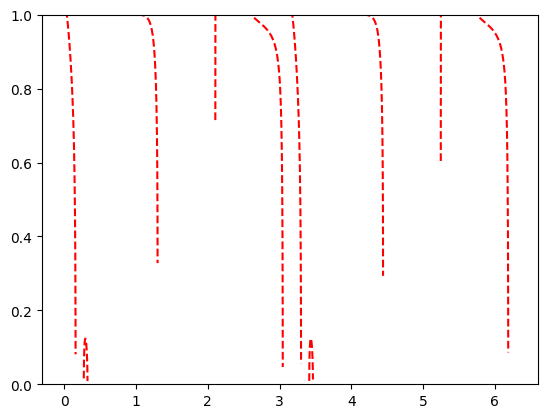

In [103]:
# plt.plot(phi,F_det0_rm2(phi,(alpha,eta1,eta2)),color='black',ls='--')
# plt.plot(phi,F_det0_rm4(phi,(alpha,eta1,eta2)),color='black',ls='--')
plt.plot(phi,F_det0_rm1(phi,alpha,eta1,eta2),color='red',ls='--')
plt.plot(phi,F_det0_rm3(phi,alpha,eta1,eta2),color='red',ls='--')
# plt.plot(phi,F_NN1(phi,alpha,eta1,eta2),color='red',ls='--')
plt.ylim(0,1)


In [138]:
def sol_rdet(phi,alpha,eta1,eta2):
    r = F_det0_rm2(phi,(alpha,eta1,eta2)) - F_dphi0_rm1(phi,(alpha,eta1,eta2))
    # if np.isnan(r):
    #     return 1
    # else:
    return r

In [ ]:
F_beta_rm()

In [235]:
root_scalar(sol_rdet,x0=3,args=(alpha,eta1,eta2),bracket=[0,2*np.pi],method="newton")

      converged: True
           flag: converged
 function_calls: 92
     iterations: 46
           root: 3.141585225981769
         method: newton

In [259]:
rs = root_scalar(sol_rdet,x0=0.1,args=(alpha,eta1,eta2),bracket=[0,2*np.pi],method="secant")


In [257]:
F_det0_rm2(rs.root,(alpha,eta1,eta2))

2.000039546498017

(-1.0, 1.0)

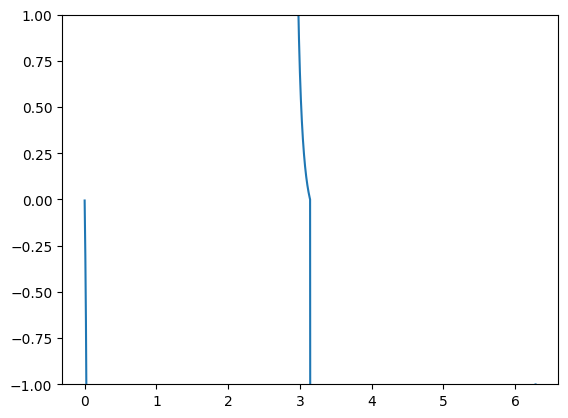

In [240]:
plt.plot(phi,sol_rdet(phi,alpha,eta1,eta2))
plt.ylim(-1,1)

In [224]:
phi = np.linspace(0,2*np.pi,30000)
alpha = np.pi/2 - 0.5
beta = 0.7
eta1 = 0.1
eta2 = 0.05

# plt.plot(phi,F_det0_rm1(phi,(alpha,eta1,eta2)))
# plt.plot(phi,F_det0_rm3(phi,(alpha,eta1,eta2)))
# plt.plot(phi,F_det0_rm2(phi,(alpha,eta1,eta2)),color='black',ls='--')
# plt.plot(phi,F_det0_rm4(phi,(alpha,eta1,eta2)),color='black',ls='--')



# plt.plot(phi,F_det0_rp1(phi,(alpha,eta1,eta2)))
# plt.plot(phi,F_det0_rp3(phi,(alpha,eta1,eta2)))
plt.plot(phi,F_det0_rp2(phi,(alpha,eta1,eta2)),color='green',ls='--')
plt.plot(phi,F_det0_rp4(phi,(alpha,eta1,eta2)),color='green',ls='--')

# plt.plot(phi,F_dphi0_rm1(phi,(alpha,eta1,eta2)),color='red')
# plt.plot(phi,F_dphi0_rm2(phi,(alpha,eta1,eta2)),color='red')
plt.plot(phi,F_dphi0_rp1(phi,(alpha,eta1,eta2)),color='blue')
plt.plot(phi,F_dphi0_rp2(phi,(alpha,eta1,eta2)),color='blue')


# plt.plot(phi,F_trace0_rm(phi,(alpha,eta1,eta2)),ls='--',color='orange')
plt.plot(phi,F_trace0_rp(phi,(alpha,eta1,eta2)),ls='--',color='darkorange')
plt.ylim(0,1)


#  

NameError: name 'F_det0_rp2' is not defined

In [225]:
phi = np.linspace(0,2*np.pi,30000)
alpha = 0.1
beta = 0.3
eta1 = 0.1
eta2 = 0.05

# plt.plot(phi,F_det0_rm1(phi,(alpha,eta1,eta2)))
# plt.plot(phi,F_det0_rm3(phi,(alpha,eta1,eta2)))
plt.plot(phi,F_det0_rm2(phi,(alpha,eta1,eta2)),color='black',ls='--')
plt.plot(phi,F_det0_rm4(phi,(alpha,eta1,eta2)),color='black',ls='--')



# plt.plot(phi,F_det0_rp1(phi,(alpha,eta1,eta2)))
# plt.plot(phi,F_det0_rp3(phi,(alpha,eta1,eta2)))
# plt.plot(phi,F_det0_rp2(phi,(alpha,eta1,eta2)),color='green',ls='--')
# plt.plot(phi,F_det0_rp4(phi,(alpha,eta1,eta2)),color='green',ls='--')

plt.plot(phi,F_dphi0_rm1(phi,(alpha,eta1,eta2)),color='red')
plt.plot(phi,F_dphi0_rm2(phi,(alpha,eta1,eta2)),color='red')
# plt.plot(phi,F_dphi0_rp1(phi,(alpha,eta1,eta2)),color='blue')
# plt.plot(phi,F_dphi0_rp2(phi,(alpha,eta1,eta2)),color='blue')


plt.plot(phi,F_trace0_rm(phi,(alpha,eta1,eta2)),ls='--',color='orange')
# plt.plot(phi,F_trace0_rp(phi,(alpha,eta1,eta2)),ls='--',color='darkorange')
plt.ylim(0,1)


#  

NameError: name 'F_det0_rm2' is not defined

In [ ]:
F_beta_m = sp.lambdify((phi,(alpha,eta1,eta2)),beta_rm)


In [159]:
def F_beta_rm(r,phi,alpha,eta1,eta2):
    beta_rm = eta2*r*(-np.cos(alpha+phi) - np.sin(phi))/ (eta1 * np.cos(alpha+2*phi))
    return beta_rm

def F_beta_rp(r,phi,alpha,eta1,eta2):
    beta_rp = eta2*r*(-np.cos(alpha+phi) + np.sin(phi))/ (eta1 * np.cos(alpha+2*phi))
    return beta_rp

(0.0, 1.0)

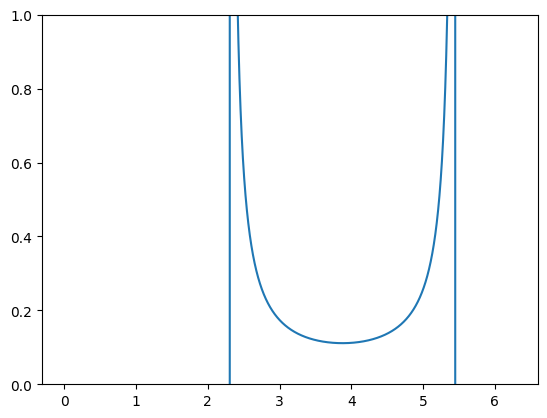

In [162]:
# plt.plot(phi,F_beta_rm(0.9,phi,alpha,eta1,eta2))
plt.plot(phi,F_beta_rp(0.3,phi,alpha,eta1,eta2))
# plt.plot(phi,F_beta_rm(0.3,phi,alpha?,eta1,eta2))
plt.ylim(0,1)